In [214]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from scipy.interpolate import splprep, splev
import itertools

In [215]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
def showbytes(a):
    IPython.display.display(IPython.display.Image(data=a))

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [250]:
def smooth_contours(contours):
    smoothened = []
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]
        sval = (len(x) + (len(x)**(1/2))/8)
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
        tck, u = splprep([x,y], u=None, s=sval, per=1)
        # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
        u_new = np.linspace(u.min(), u.max(), 40)
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
        x_new, y_new = splev(u_new, tck, der=0)
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_array, dtype=np.int32))
    return smoothened

In [266]:
def get_perp_bisector(line):
    (x1, y1), (x2, y2) = line
    cx = (x1+x2)/2;
    cy = (y1+y2)/2;

    x1-=cx; y1-=cy;
    x2-=cx; y2-=cy;

    xtemp = x1; ytemp = y1;
    x1=-ytemp; y1=xtemp; 

    xtemp = x2; ytemp = y2;
    x2=-ytemp; y2=xtemp; 

    x1+=cx; y1+=cy;
    x2+=cx; y2+=cy;
    
    return ((int(x1), int(y1)), (int(x2), int(y2)))

def get_md_pt(line, contours, image):
    perp1 = get_perp_bisector(line)
    img_blk_ln = np.zeros(image.shape).astype(image.dtype)
    cv2.line(img_blk_ln, perp1[0], perp1[1], (255,255,255), thickness=1, lineType=8, shift=0)
    img_blk_cnt = np.zeros(image.shape).astype(image.dtype)
    cv2.drawContours(img_blk_cnt, contours, 0, (255,255, 255), 1)
    img_blk = np.zeros(image.shape).astype(image.dtype)
    cv2.bitwise_and(img_blk_cnt, img_blk_ln, img_blk)
#     cv2.line(image, line[0], line[1], (255, 0, 0), thickness=1, lineType=8, shift=0)
    pixelpoints = np.transpose(np.nonzero(img_blk))
    s = sorted(pixelpoints, key=lambda k: np.linalg.norm(k-line[0][:-1]))
#     plt.imshow(img_blk)
    return (s[0][0], s[0][1])


In [269]:
def makemask(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    old_contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    old_contours = imutils.grab_contours(old_contours)
    def wrapping_slice(lst, *args):
        return [lst[i%len(lst)] for i in range(*args)]

    rect = cv2.minAreaRect(old_contours[0])

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    width = int(rect[1][0])
    height = int(rect[1][1])
    thresh = (width if width < height else height) / 2.0
    contours = smooth_contours(old_contours)
#     contours = old_contours

    cv2.drawContours(img, contours, 0, (255, 0, 0), 1)
    adj = contours[0][:-1]
    pts = []
    for idx,x in enumerate(adj):
        arr = wrapping_slice(adj, idx, idx+3)
        area = cv2.contourArea(np.array(arr))
        xy = np.linalg.norm(arr[0]-arr[1])
        yz = np.linalg.norm(arr[1]-arr[2])
        zx = np.linalg.norm(arr[2]-arr[0])
        pts.append(((idx + 1) % len(adj), (4*area)/(xy*yz*zx)))
    t = sorted(pts, key=lambda k: k[1], reverse=True)
    t4 = []
    combs = []
    
    
    for x in range(0, 4):
        t4.append(t.pop(0))

    is_fine = False
    while is_fine == False:
        is_fine = True
        combs = list(itertools.combinations(t4, 2))
        dists = []
        for x in combs:
            dists.append(np.linalg.norm(adj[x[0][0]][0] - adj[x[1][0]][0]))
        for idx, d in enumerate(dists):
            if d < thresh:
                is_fine = False
                x = combs[idx]
                item_to_remove = x[1] if x[0][1] > x[1][1] else x[0]
                try:
                    t4.pop(t4.index(item_to_remove))
                    t4.append(t.pop(0))
                except:
                    pass
    corners = []
    for pt in t4:
        x,y = adj[pt[0]][0]
        corners.append((x,y))
        cv2.circle(img, (x,y), 1, (0,0,255), thickness=2, lineType=8, shift=0)
    scorners = sorted(corners, key=lambda k: k[1])
    top = scorners[0], scorners[1]
    bottom = scorners[2], scorners[3]
    
#     cv2.line(img, top[0], top[1], (0, 255, 0), 2)
#     cv2.line(img, bottom[0], bottom[1], (0, 255, 0), 2)
    ty, tx = get_md_pt(top, old_contours, img)
    by, bx = get_md_pt(bottom, old_contours, img)
    
    cv2.circle(img, (tx,ty), 1, (0,0,255), thickness=2, lineType=8, shift=0)
    cv2.circle(img, (bx,by), 1, (0,0,255), thickness=2, lineType=8, shift=0)

#     # Extract corners
#     corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 20)
#     corners = np.int0(corners)
    
#     for pt in corners:
#         x,y = pt[0]
#         cv2.circle(img, (x,y), 1, (0,255,255), thickness=2, lineType=8, shift=0)
    showarray(img)

MR_1141_L_3.png


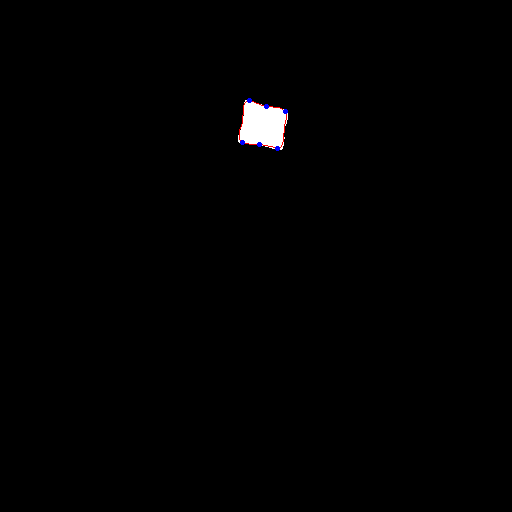

MR_0533_L_3.png


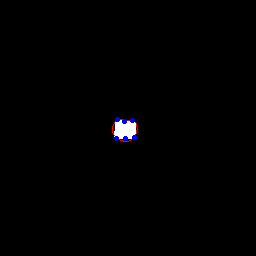

MR_1732_L_1.png


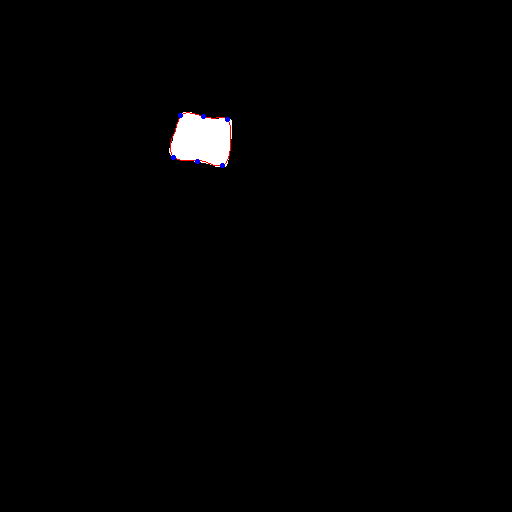

MR_0238_L_1.png


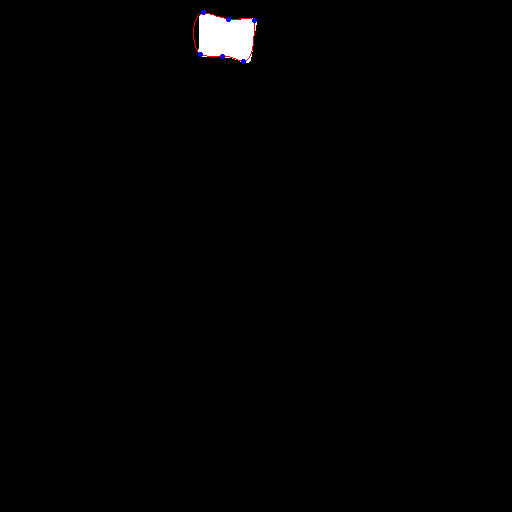

MR_0757_L_5.png


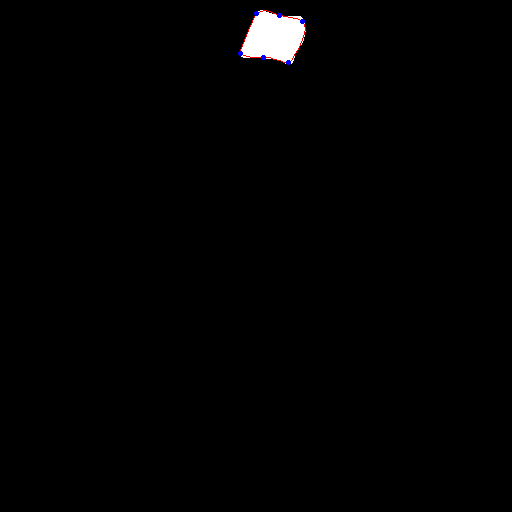

MR_2353_L_3.png


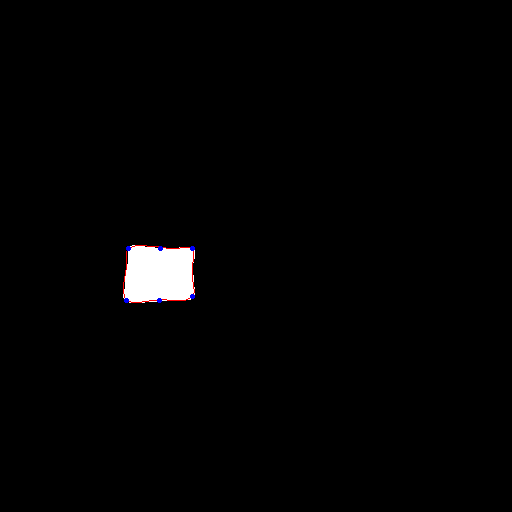

MR_1335_L_5.png
list index out of range
MR_0859_L_6.png


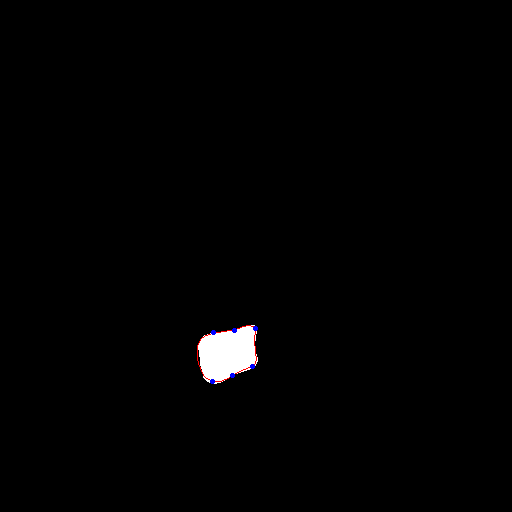

MR_0350_L_1.png


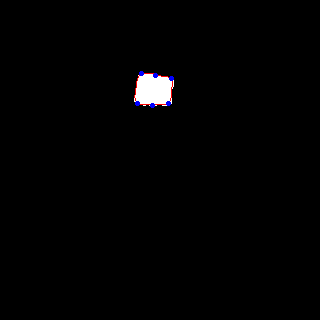

MR_2343_L_3.png


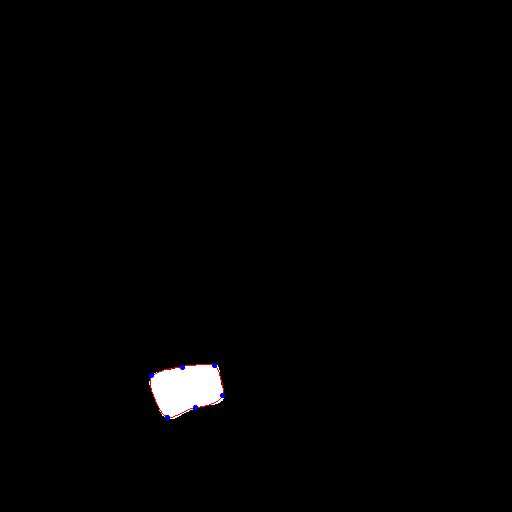

MR_1722_L_1.png


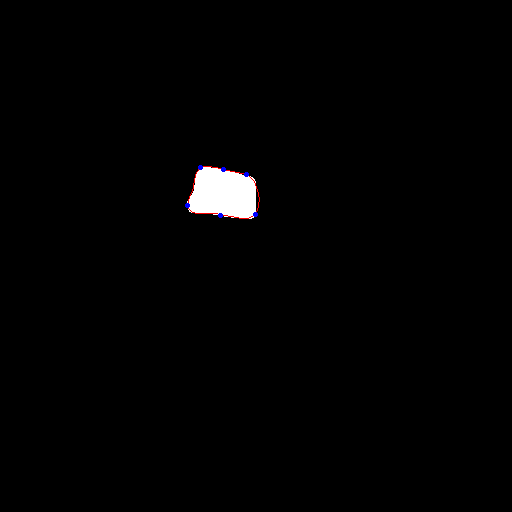

MR_0523_L_3.png
list index out of range
MR_0921_L_6.png


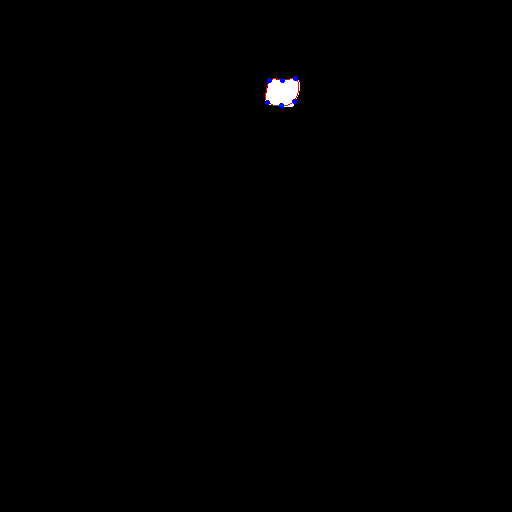

MR_0917_L_4.png


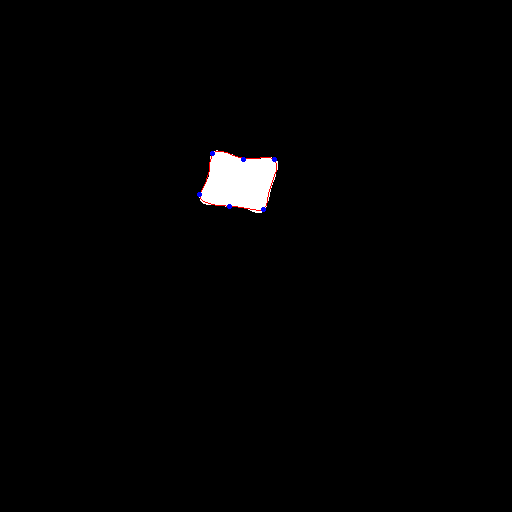

MR_0785_L_6.png


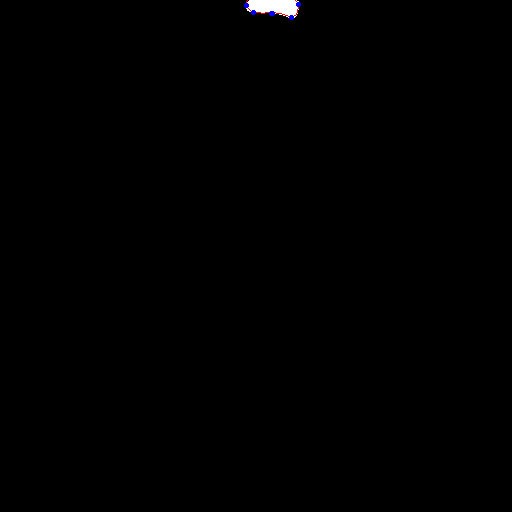

MR_0499_L_0.png


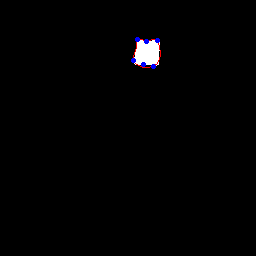

MR_1996_L_1.png


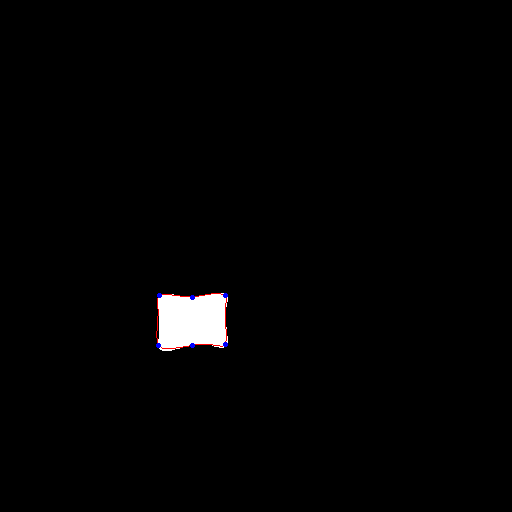

MR_2365_L_1.png
list index out of range
MR_1560_L_5.png


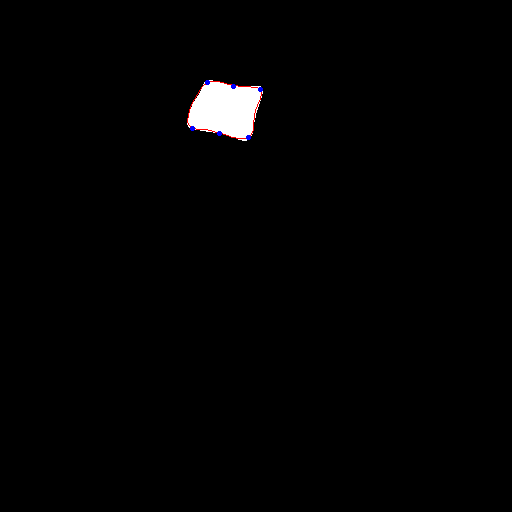

MR_0907_L_4.png


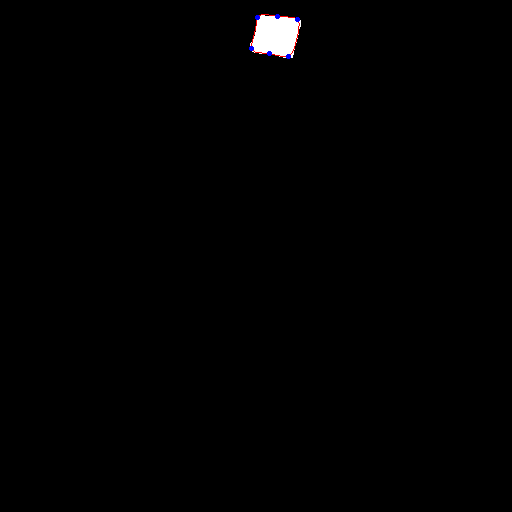

MR_0505_L_1.png


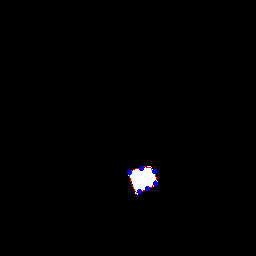

MR_1418_L_5.png


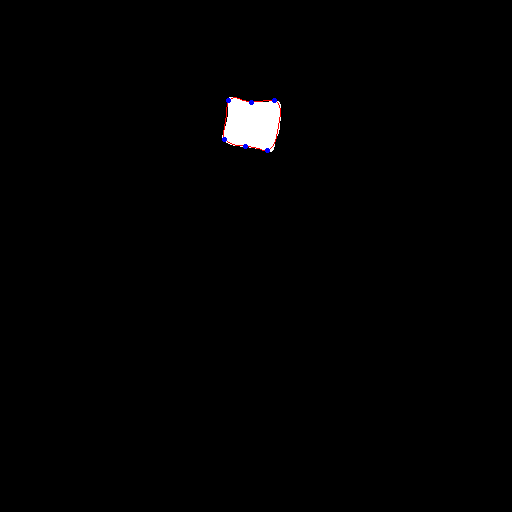

MR_1177_L_1.png


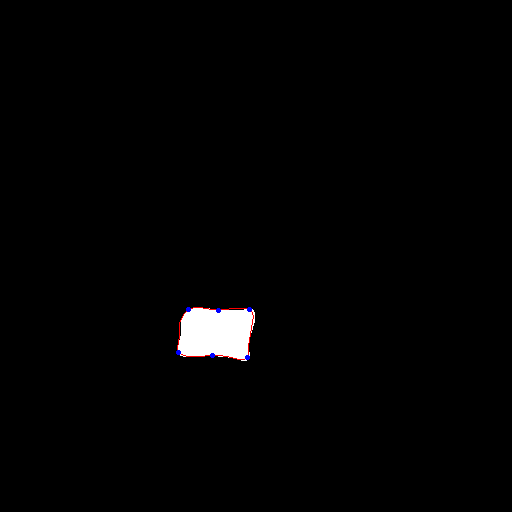

MR_1688_L_2.png


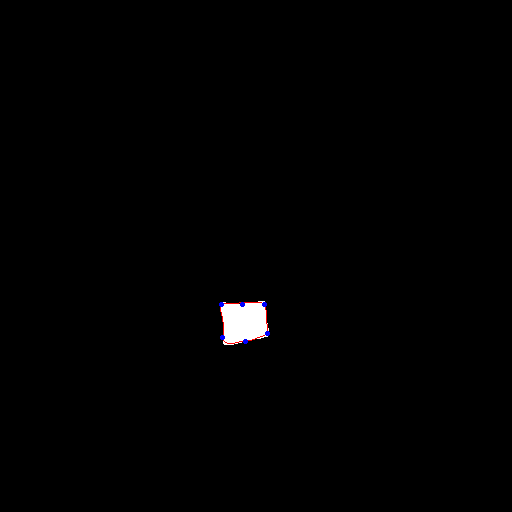

MR_1616_L_5.png


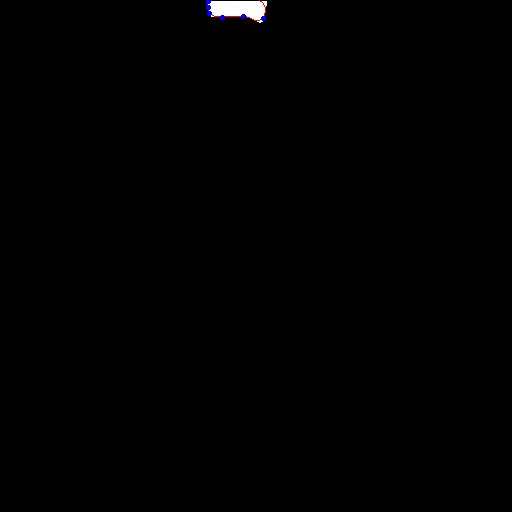

MR_0815_L_2.png


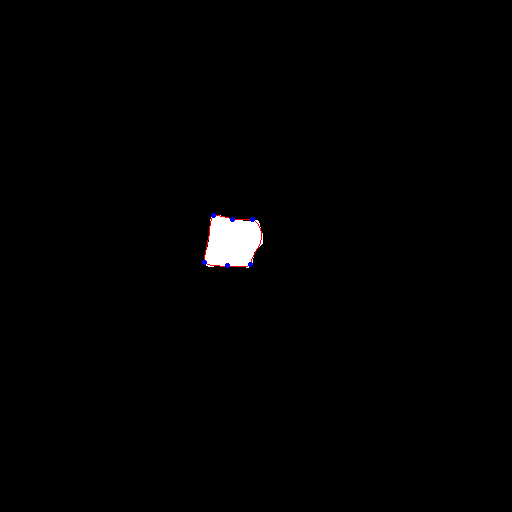

MR_0687_L_0.png


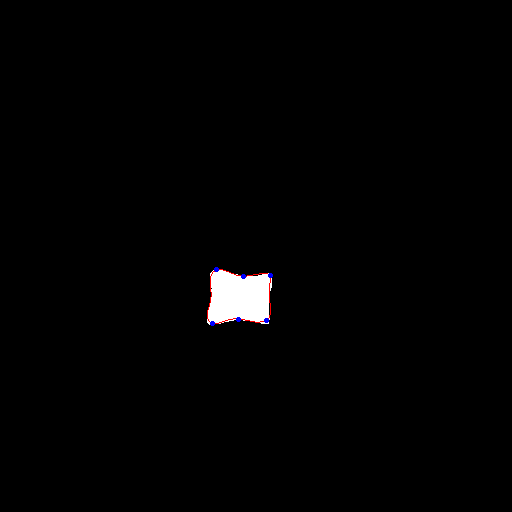

MR_1472_L_3.png


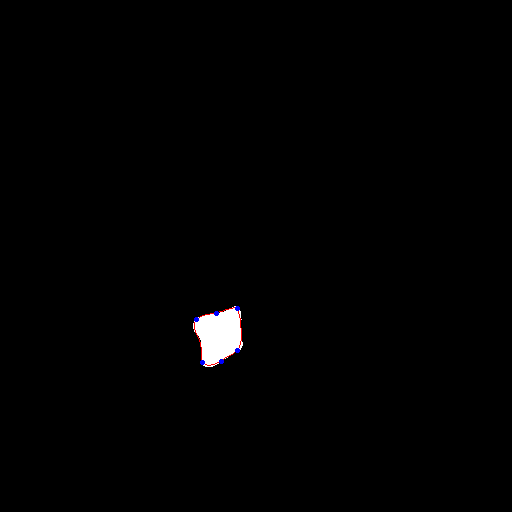

MR_1486_L_2.png


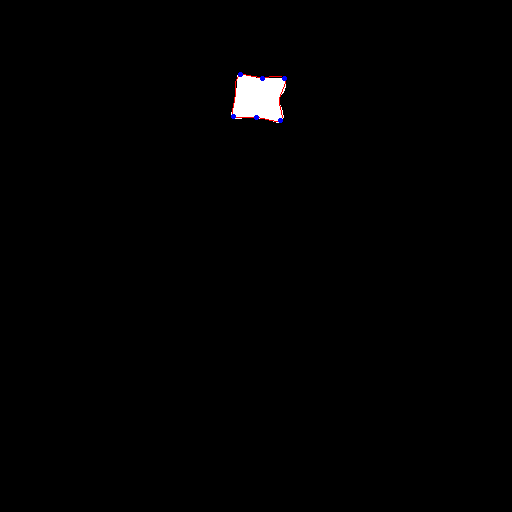

MR_1870_L_6.png


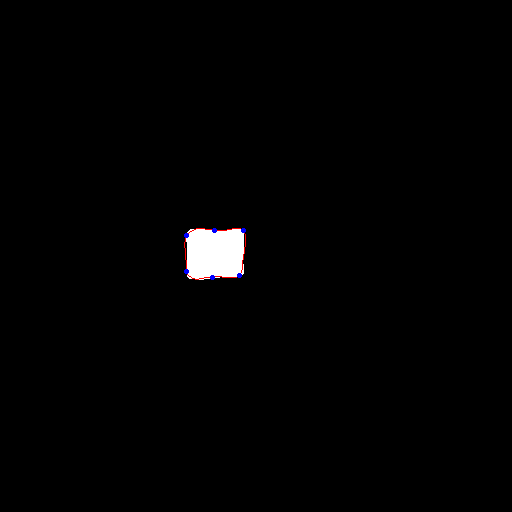

MR_2283_L_6.png


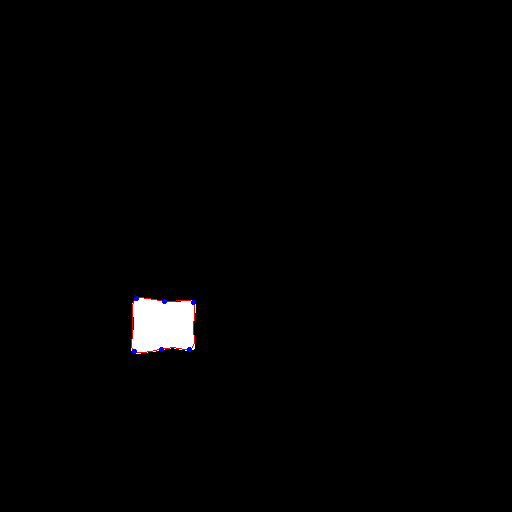

MR_1379_L_1.png


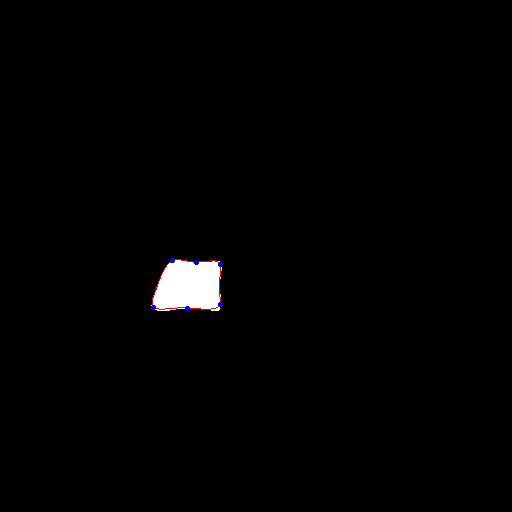

MR_1065_L_7.png


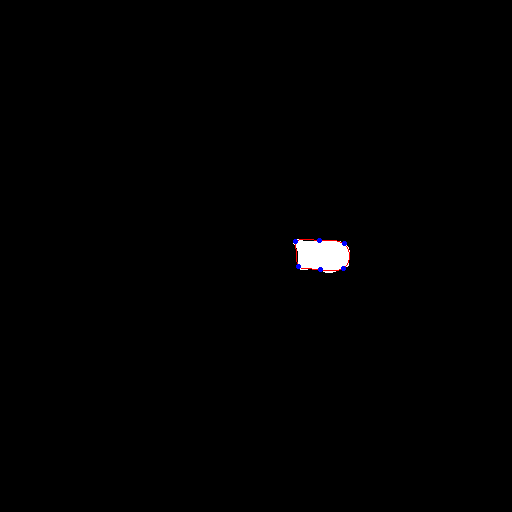

MR_0999_L_3.png


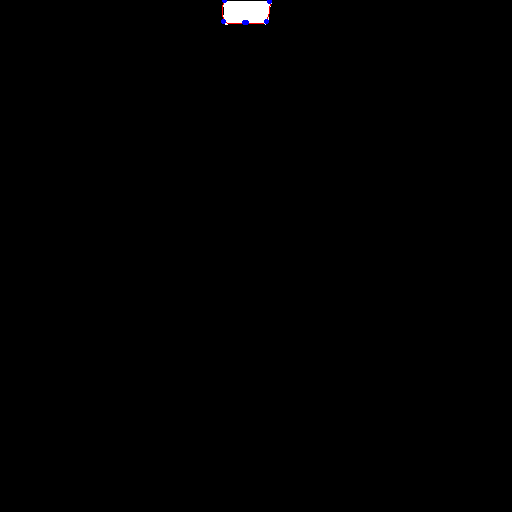

MR_1908_L_6.png


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


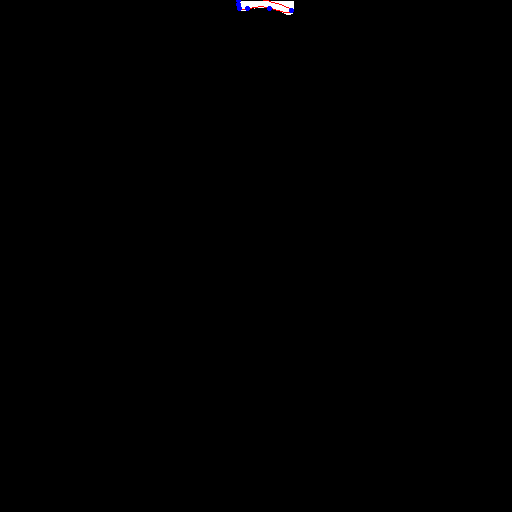

MR_1496_L_2.png


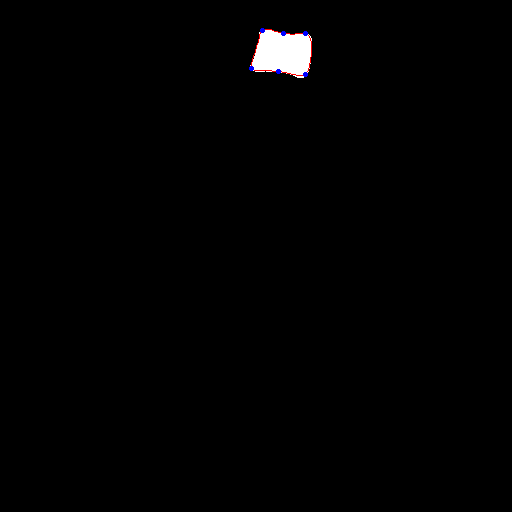

MR_2293_L_6.png


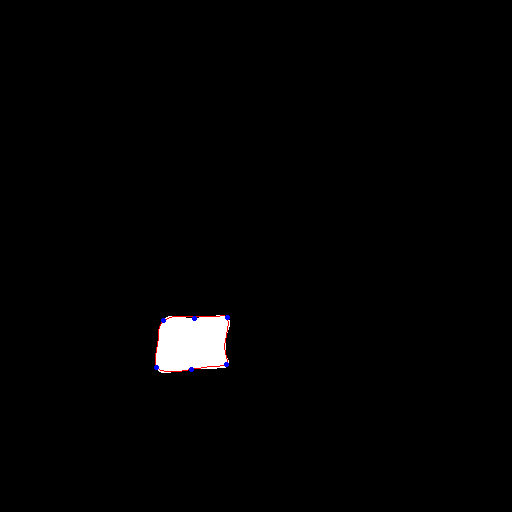

MR_0805_L_2.png


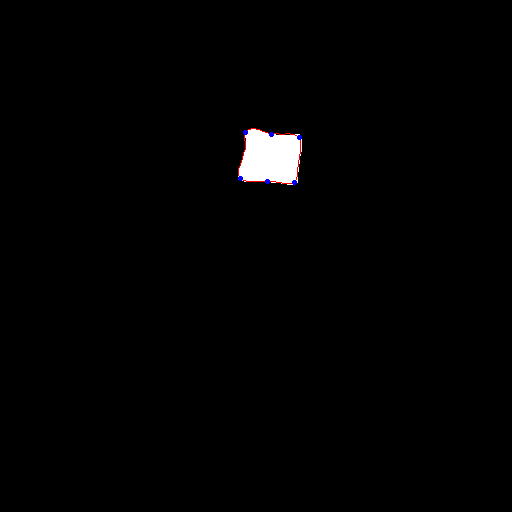

MR_0989_L_3.png


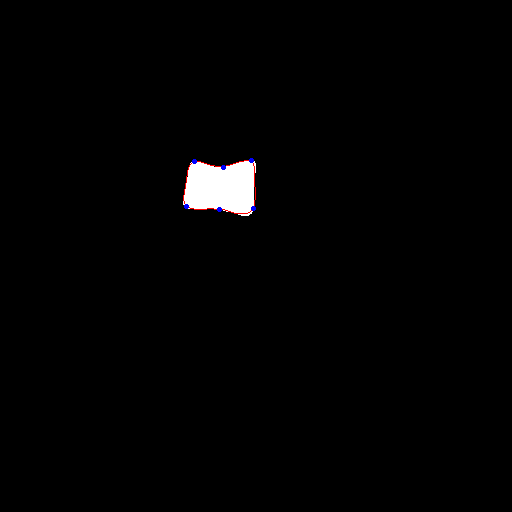

MR_1075_L_7.png


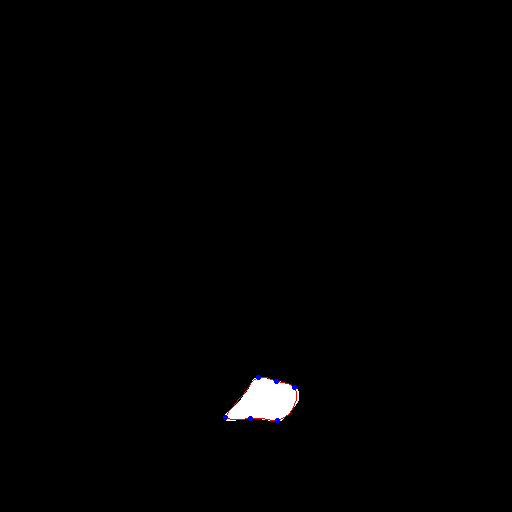

MR_1081_L_6.png


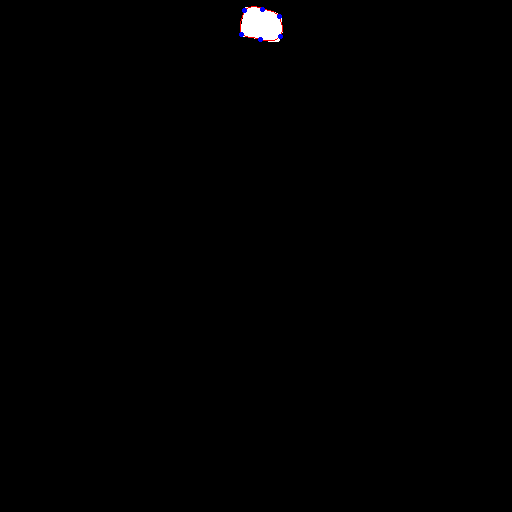

MR_1043_L_5.png


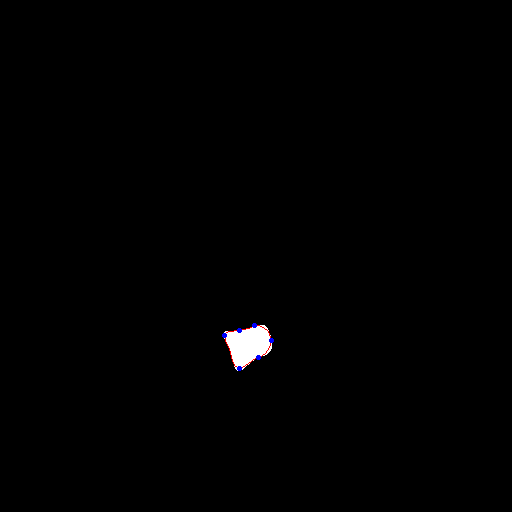

MR_1748_L_7.png
list index out of range
MR_0549_L_5.png


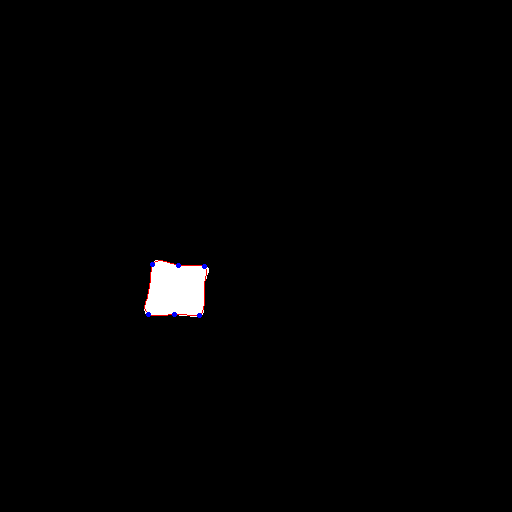

MR_1227_L_3.png


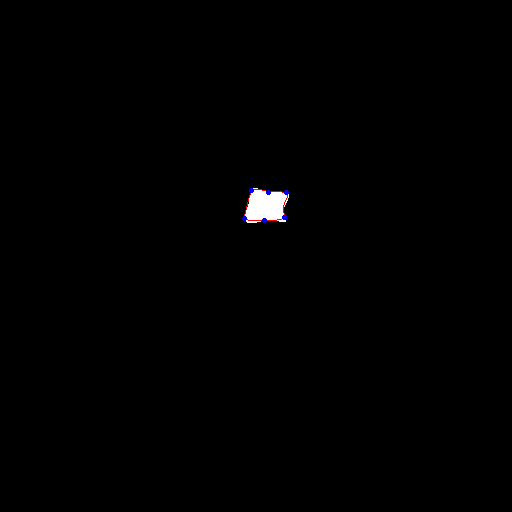

MR_0833_L_0.png


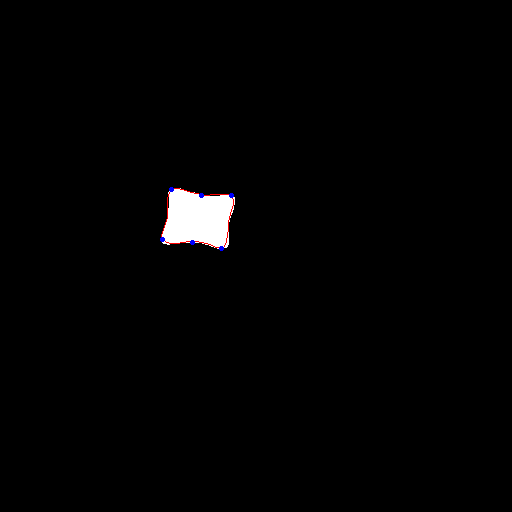

MR_2035_L_3.png


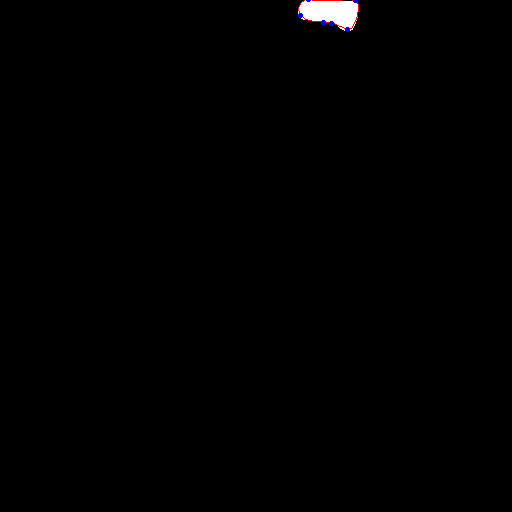

MR_0431_L_5.png


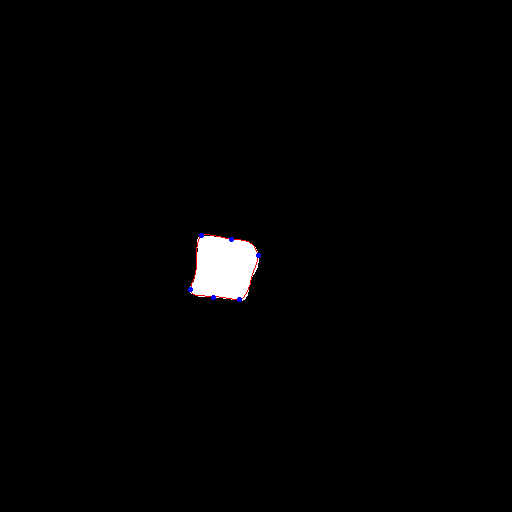

MR_1856_L_4.png


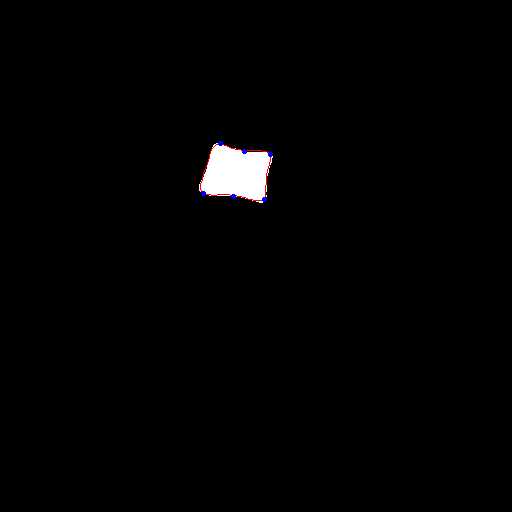

MR_0655_L_3.png


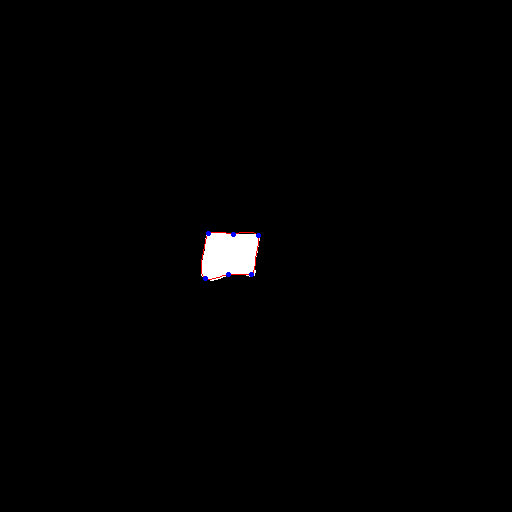

MR_1237_L_3.png


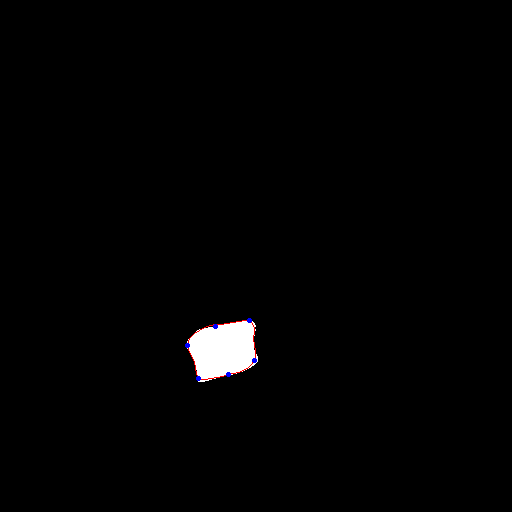

MR_1053_L_5.png
list index out of range
MR_0559_L_5.png


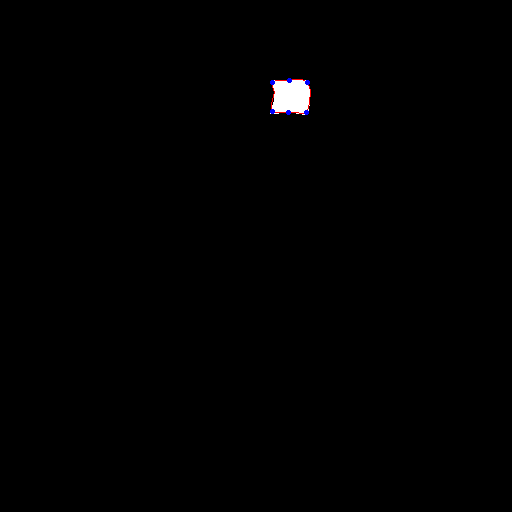

MR_1846_L_4.png


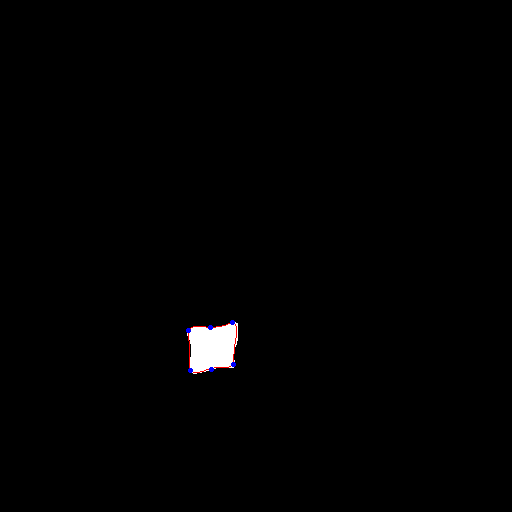

MR_2025_L_3.png


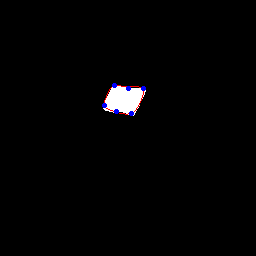

MR_0135_L_2.png


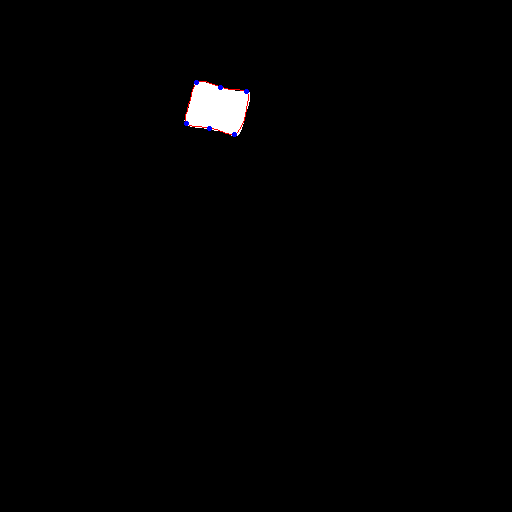

MR_1334_L_0.png


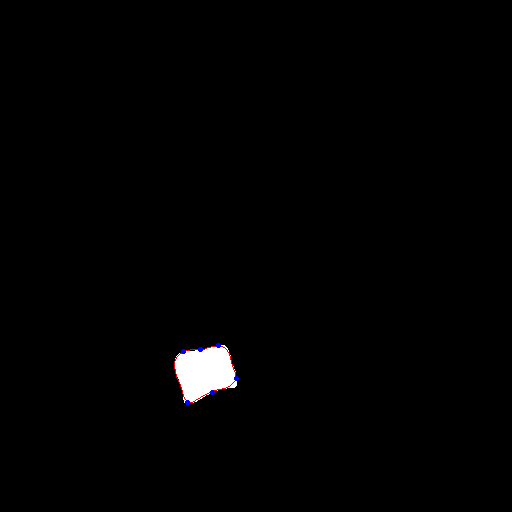

MR_1547_L_2.png


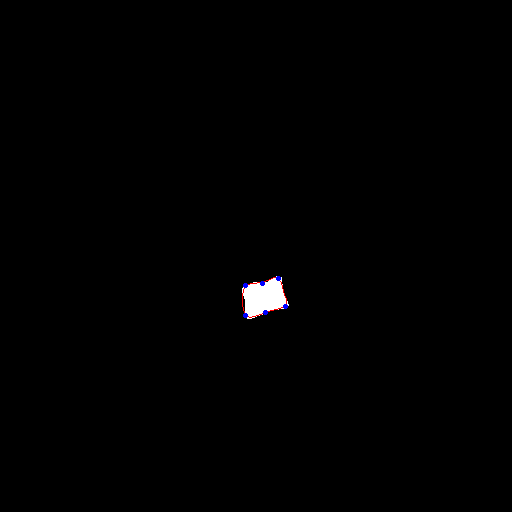

MR_2126_L_0.png


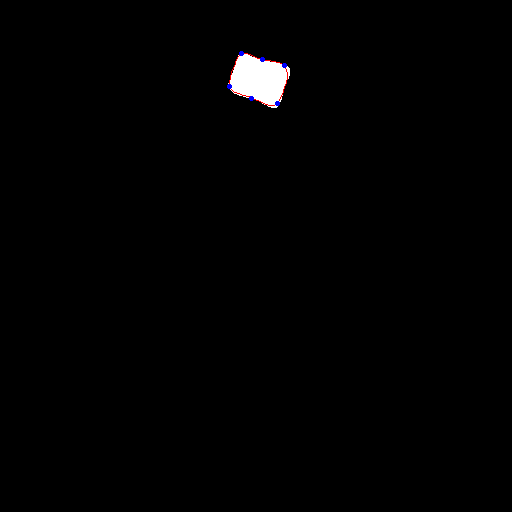

MR_1723_L_4.png


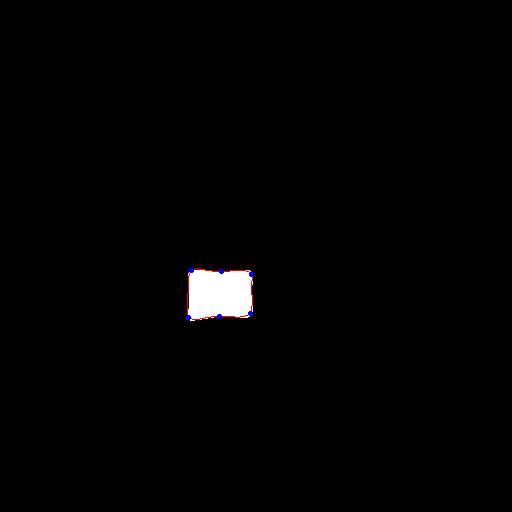

MR_0756_L_0.png


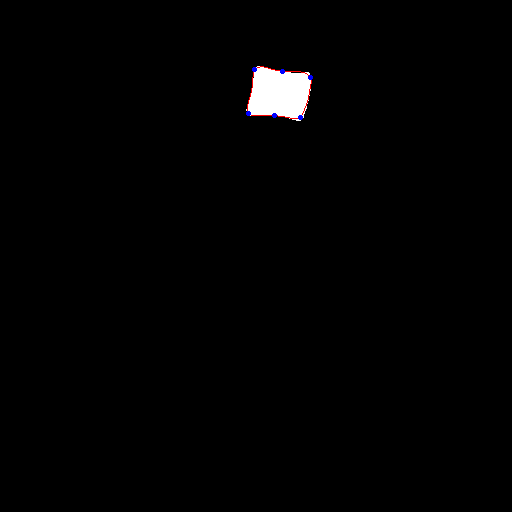

MR_1557_L_2.png


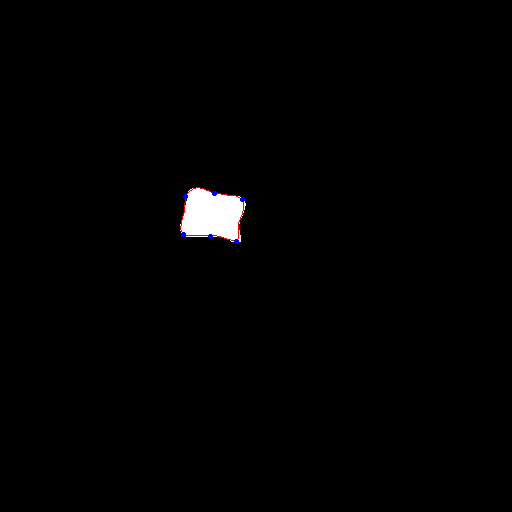

MR_1595_L_1.png
list index out of range
MR_0794_L_3.png


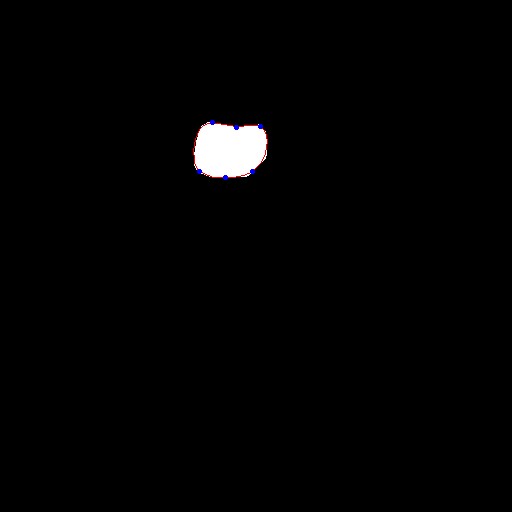

MR_1963_L_5.png


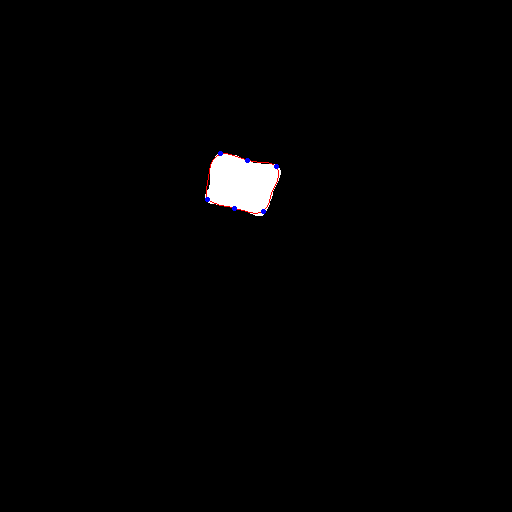

MR_1997_L_4.png
list index out of range
MR_1705_L_6.png


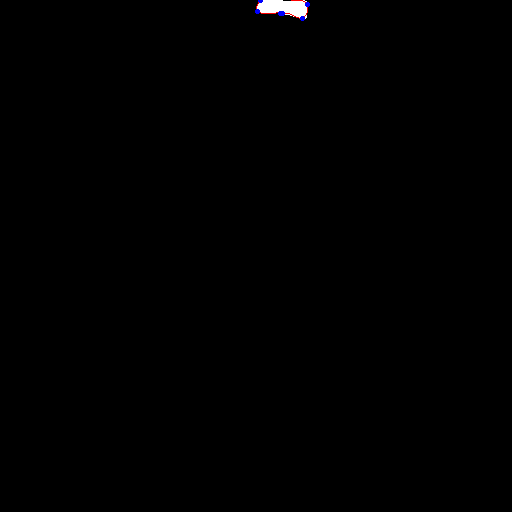

MR_2078_L_2.png


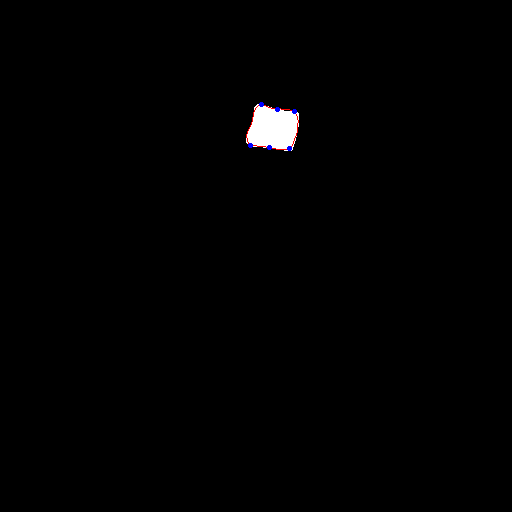

MR_1176_L_4.png


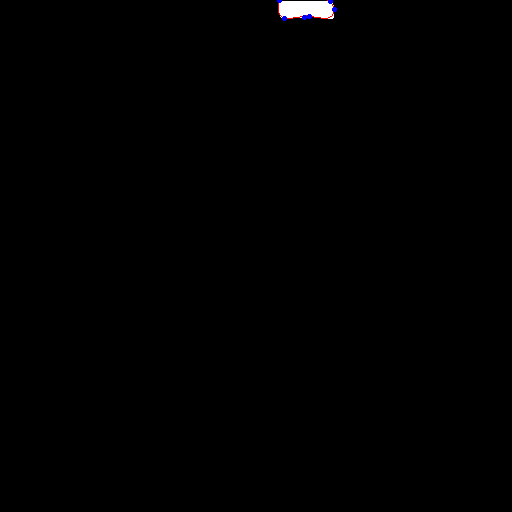

MR_1715_L_6.png


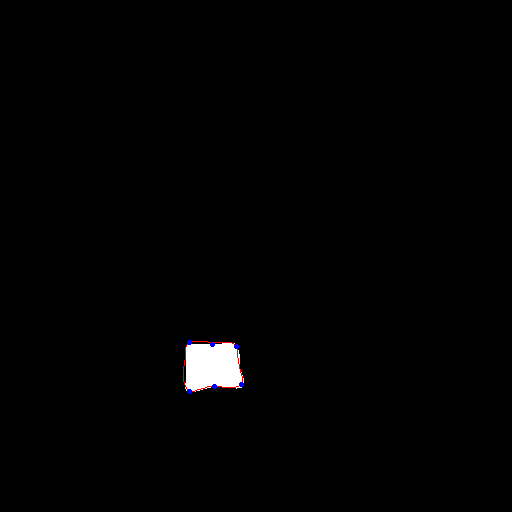

MR_2110_L_2.png


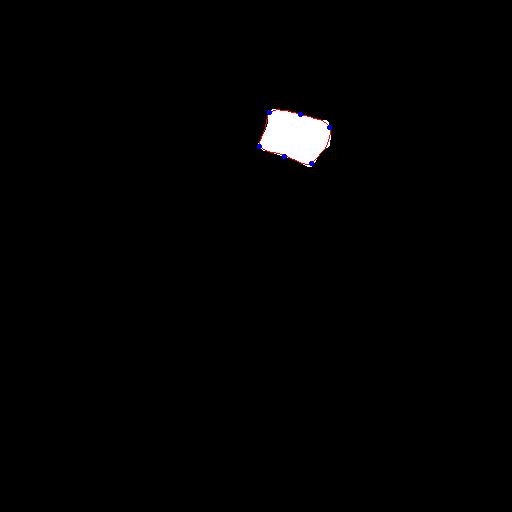

MR_0770_L_2.png


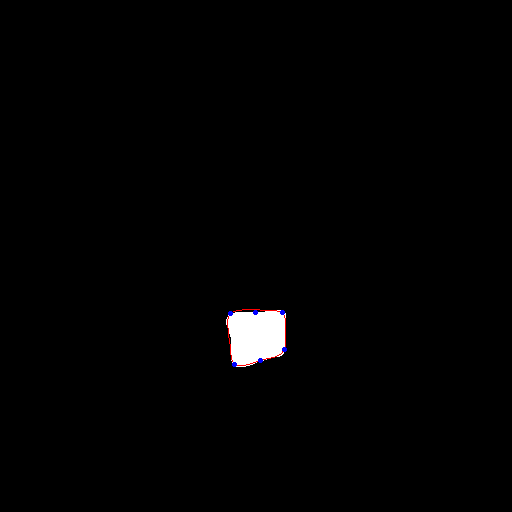

MR_1585_L_1.png


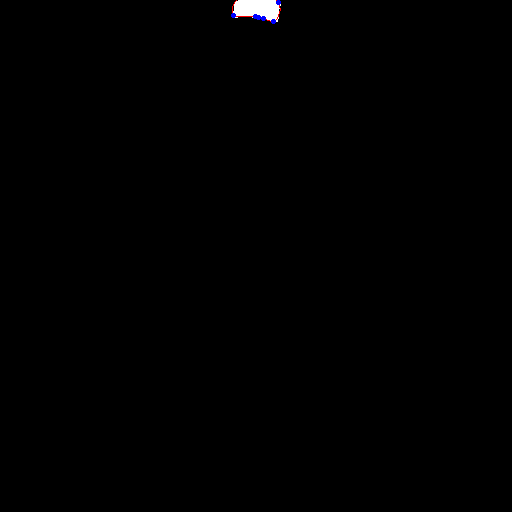

MR_1973_L_5.png


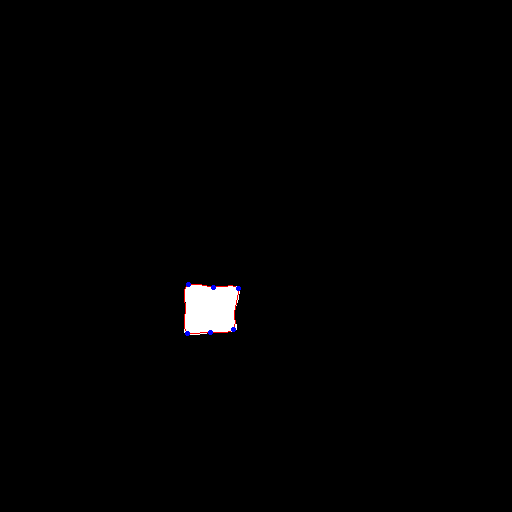

MR_1699_L_7.png


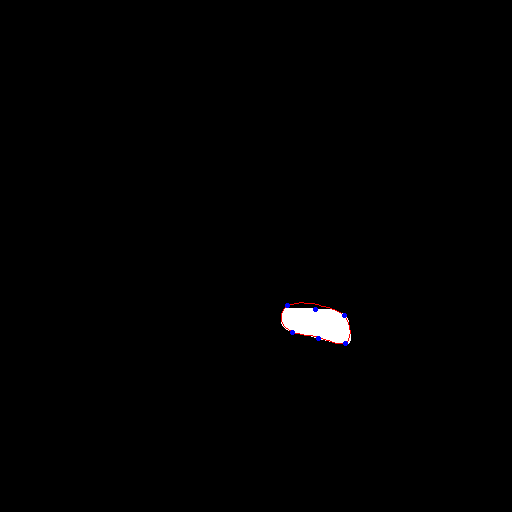

MR_1166_L_4.png


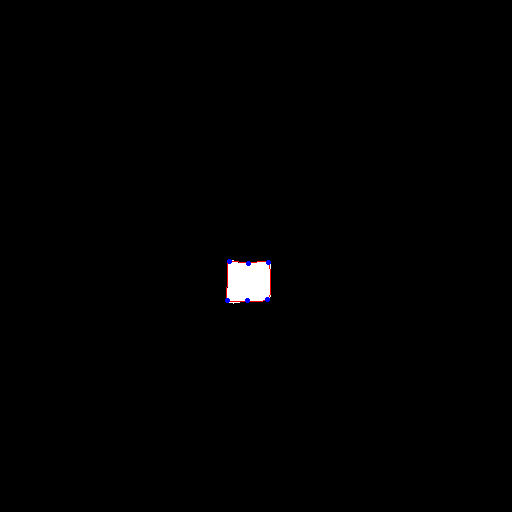

MR_1192_L_5.png


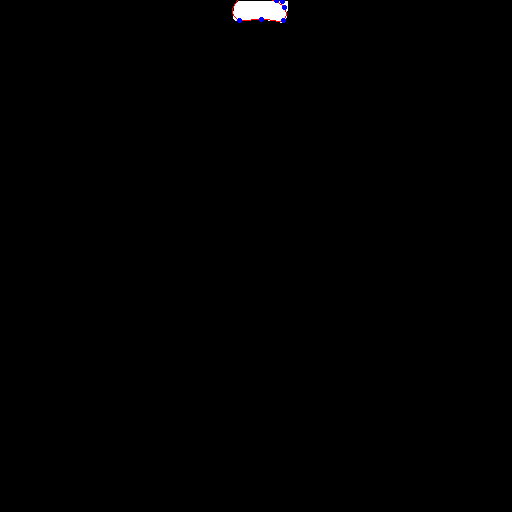

MR_2068_L_2.png


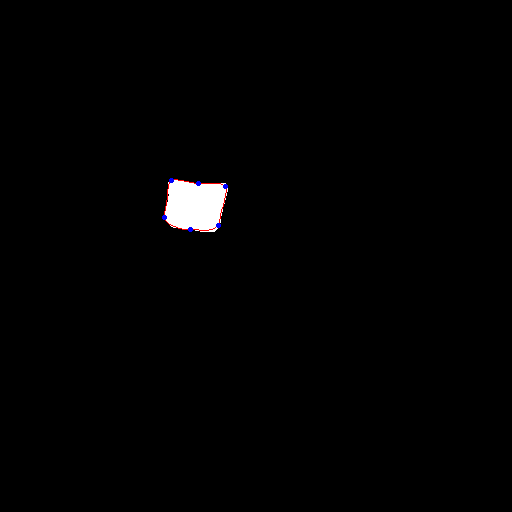

MR_1409_L_0.png
list index out of range
MR_2266_L_2.png


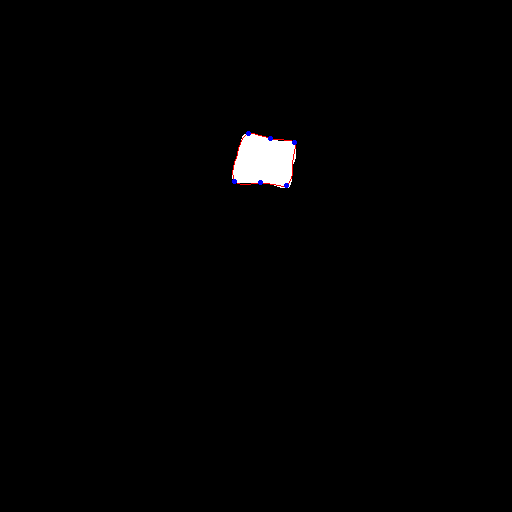

MR_1895_L_2.png


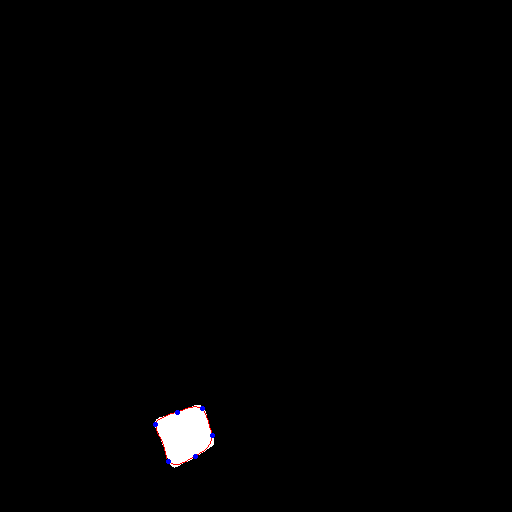

MR_1368_L_4.png


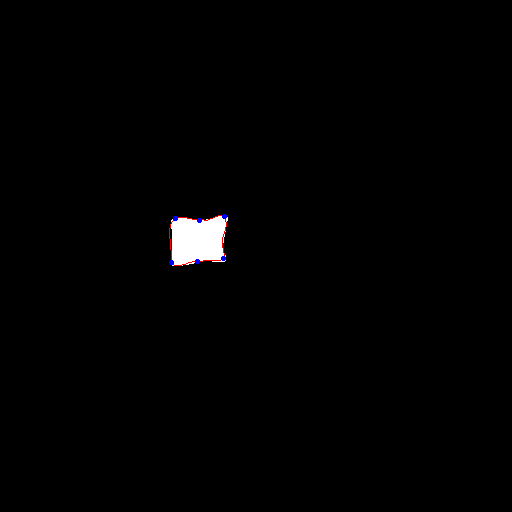

MR_0662_L_4.png


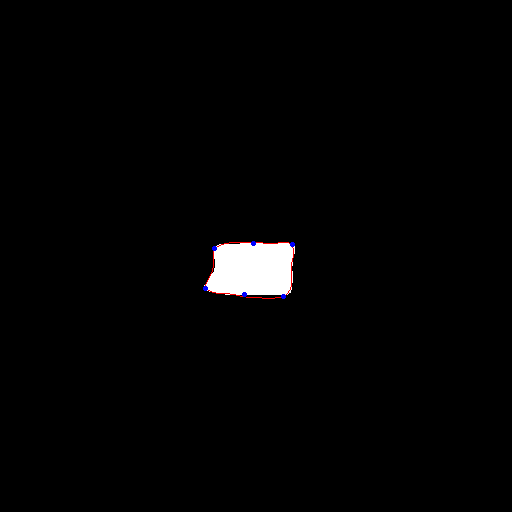

MR_0696_L_5.png


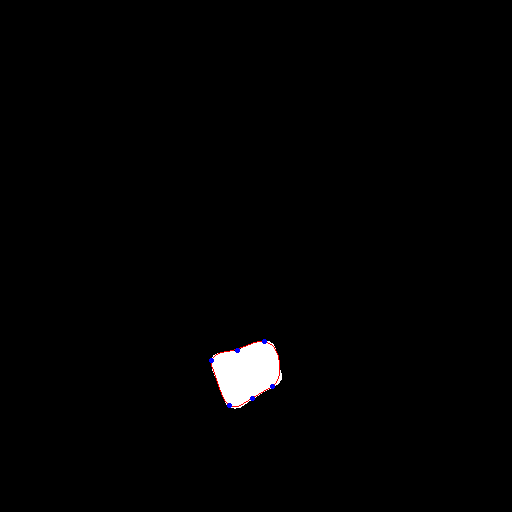

MR_2002_L_4.png


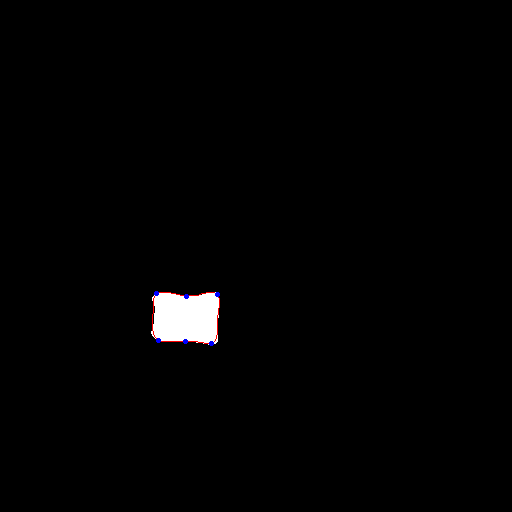

MR_1607_L_0.png


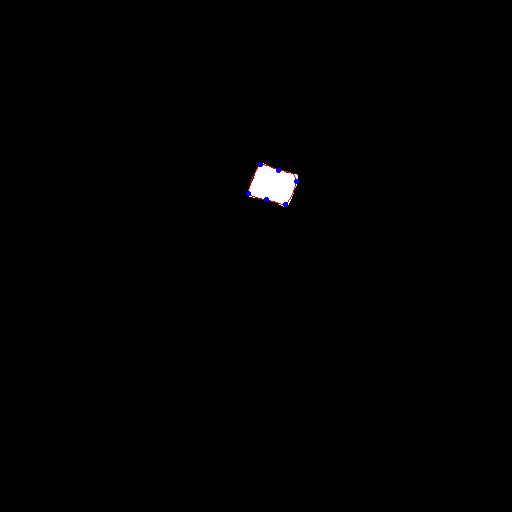

MR_1074_L_2.png


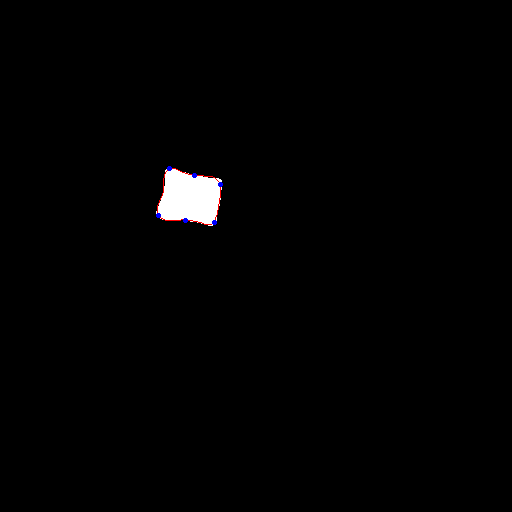

MR_2012_L_4.png


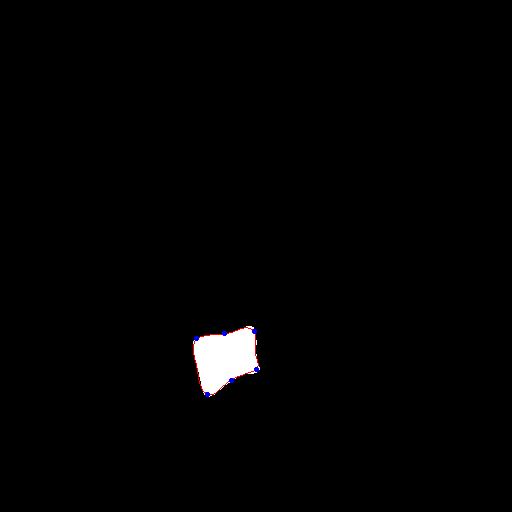

MR_1378_L_4.png


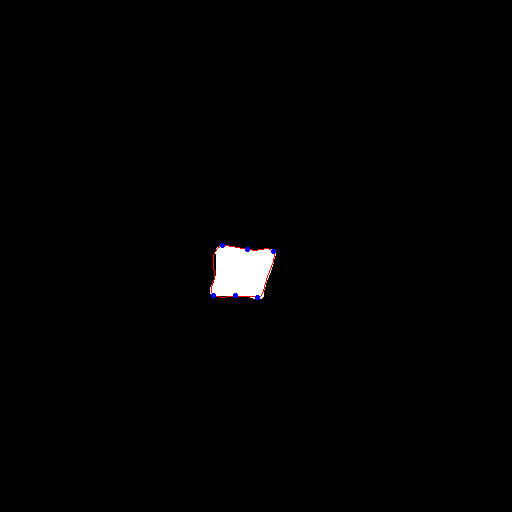

MR_2282_L_3.png


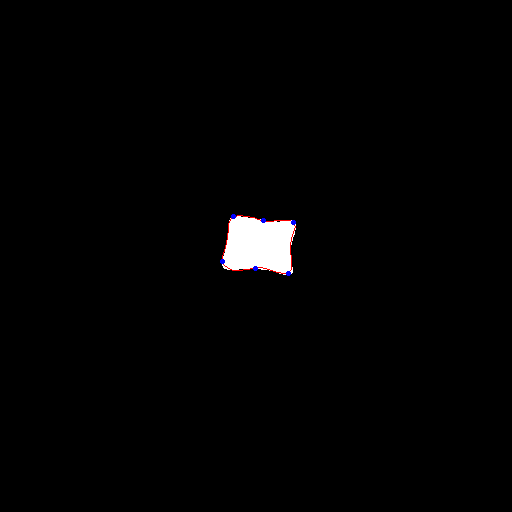

MR_1871_L_3.png


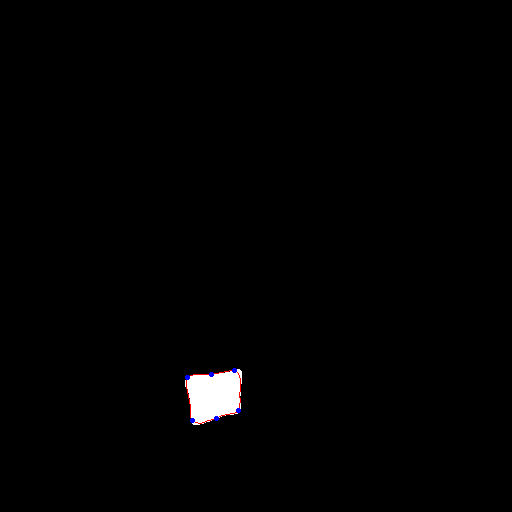

MR_0686_L_5.png
list index out of range
MR_1473_L_6.png


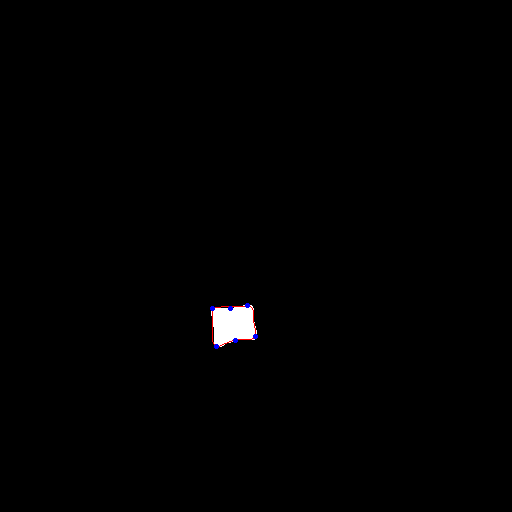

MR_0265_L_0.png


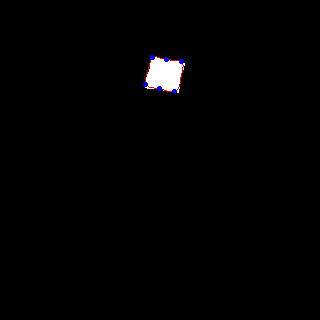

MR_1909_L_3.png


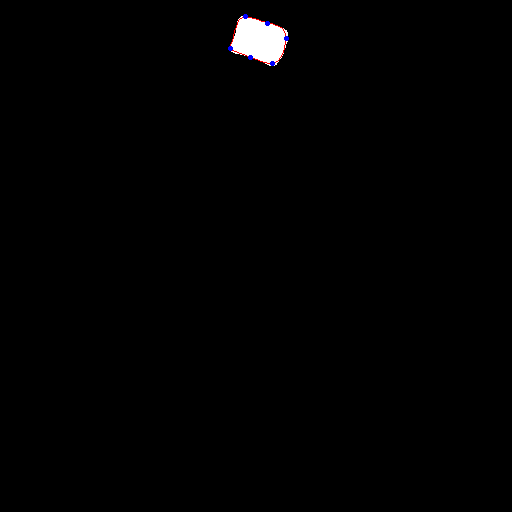

MR_0558_L_0.png


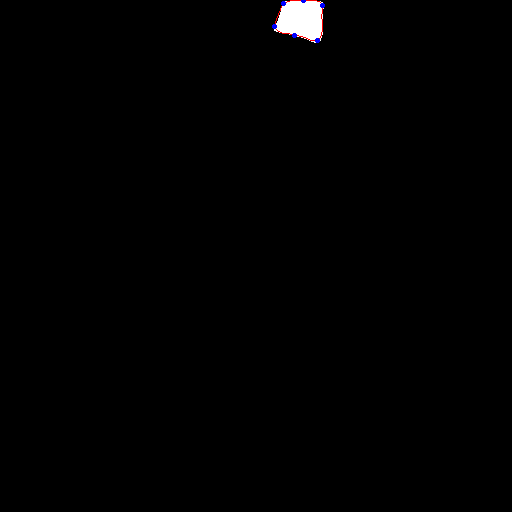

MR_1759_L_2.png


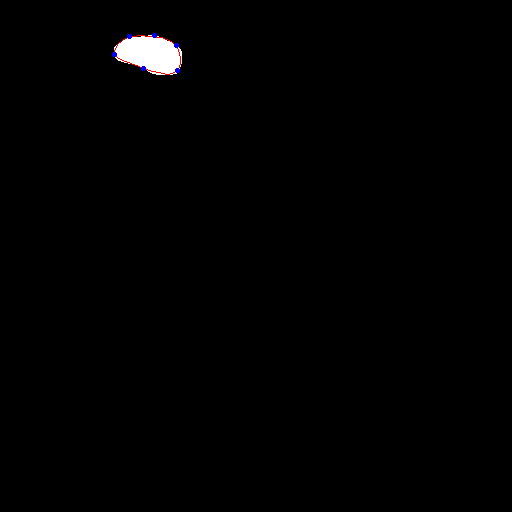

MR_1052_L_0.png


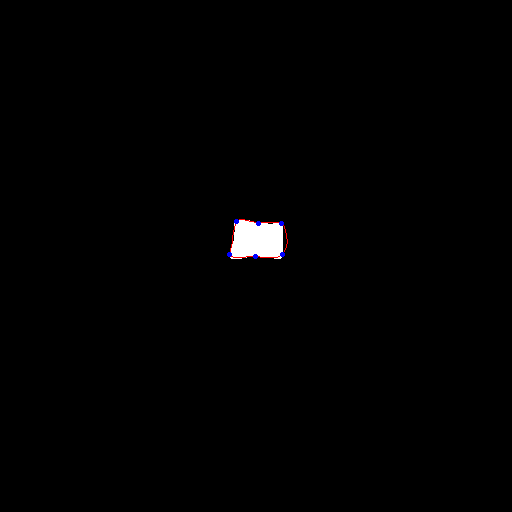

MR_1445_L_4.png


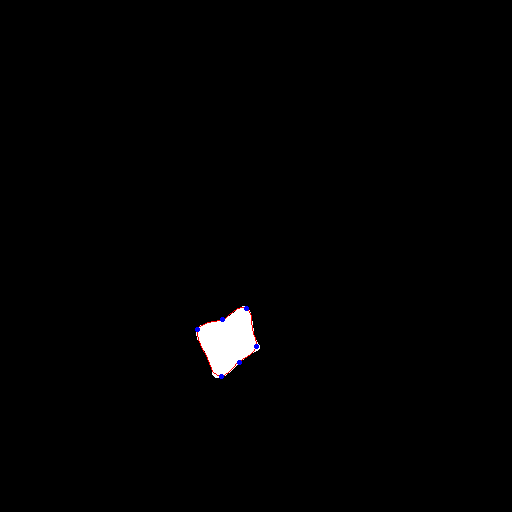

MR_1847_L_1.png


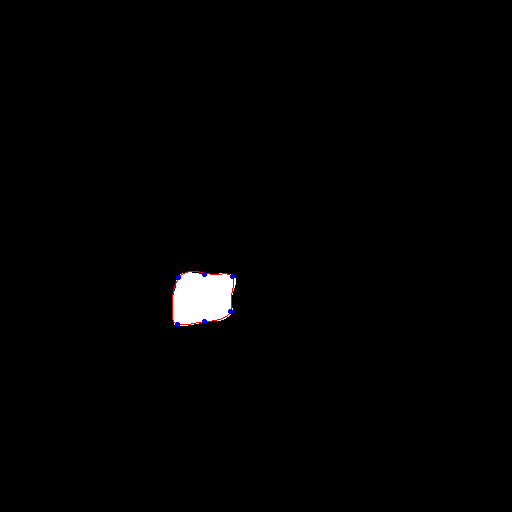

MR_0822_L_5.png


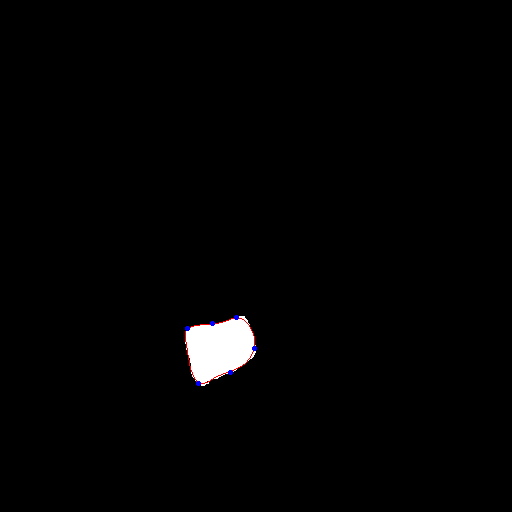

MR_0548_L_0.png


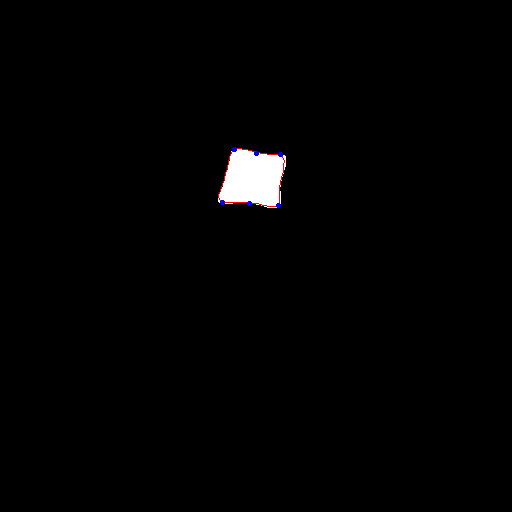

MR_1042_L_0.png


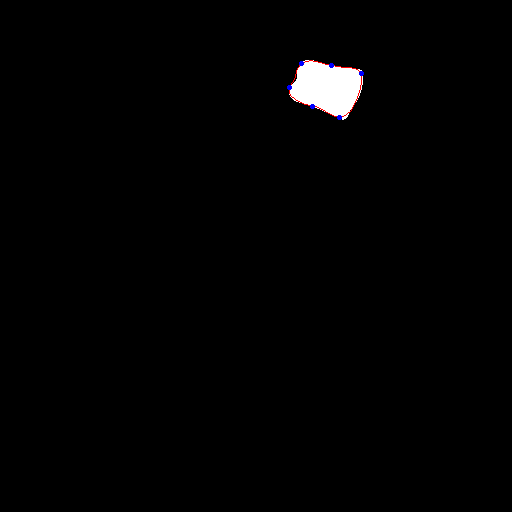

MR_1631_L_2.png


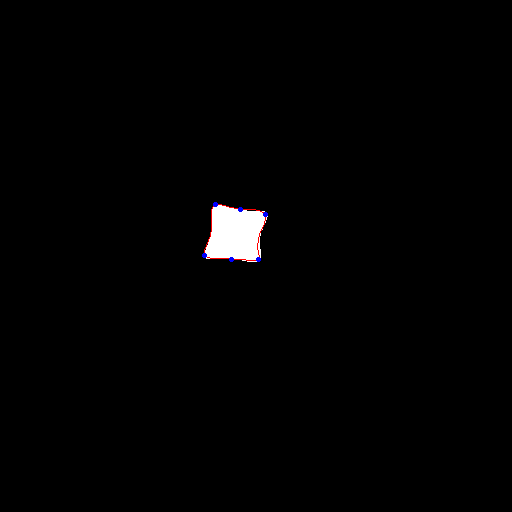

MR_2034_L_6.png


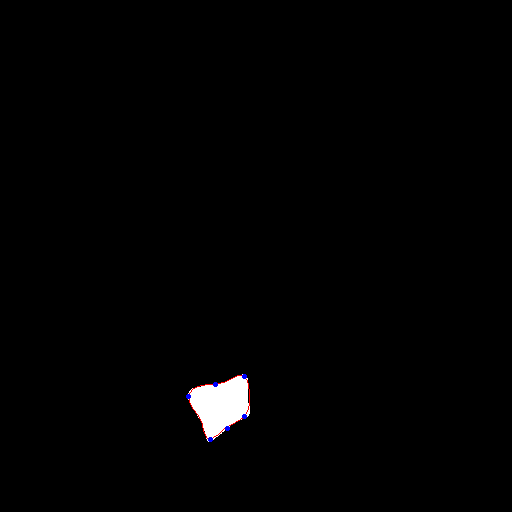

MR_1857_L_1.png


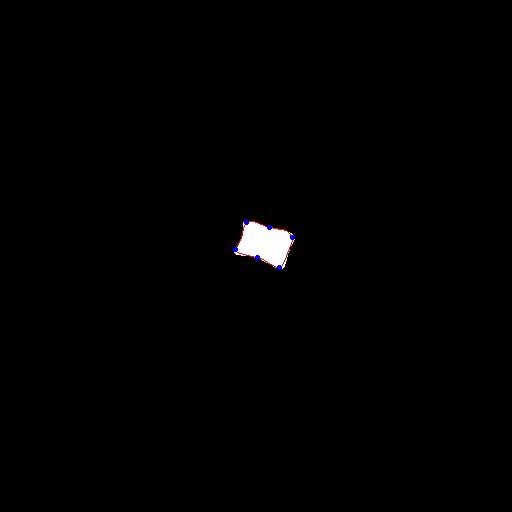

MR_2250_L_0.png


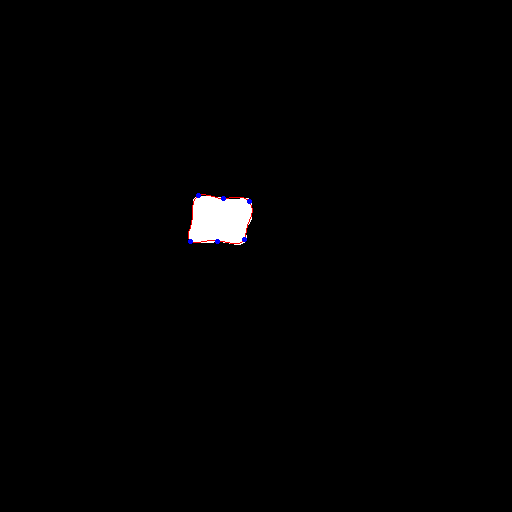

MR_0055_L_4.png


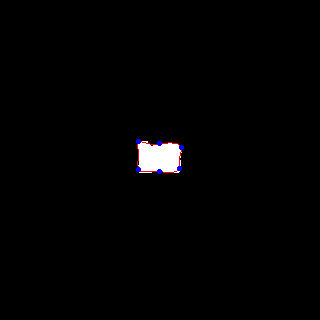

MR_1643_L_2.png


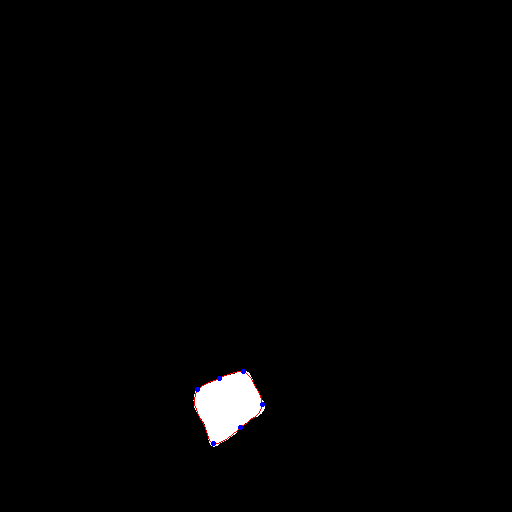

MR_1148_L_0.png


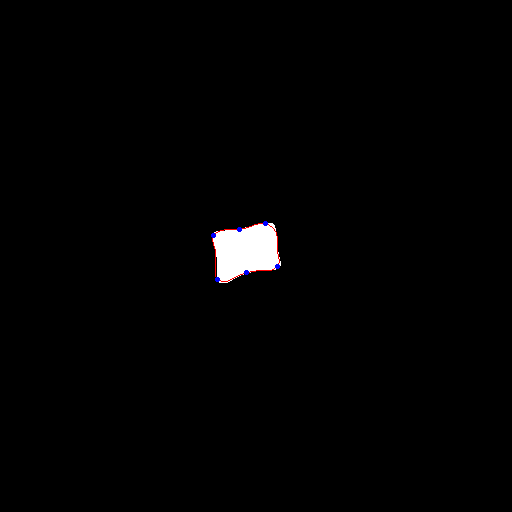

MR_1427_L_4.png
list index out of range
MR_0626_L_6.png


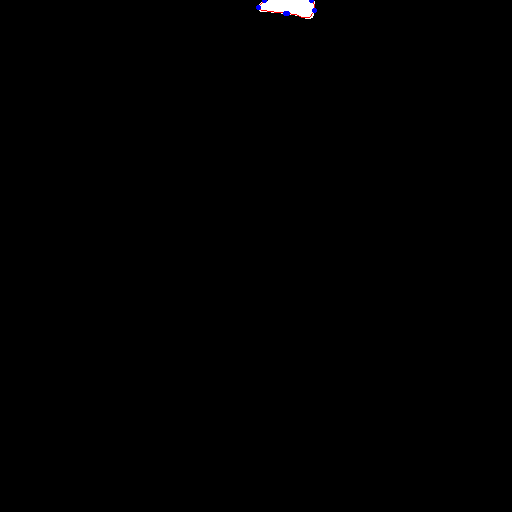

MR_1825_L_1.png


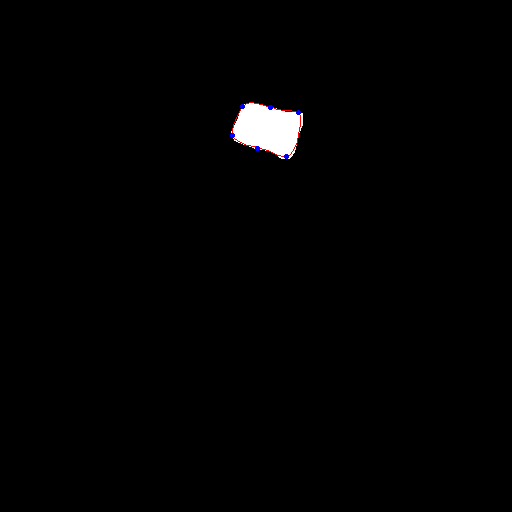

MR_2222_L_0.png


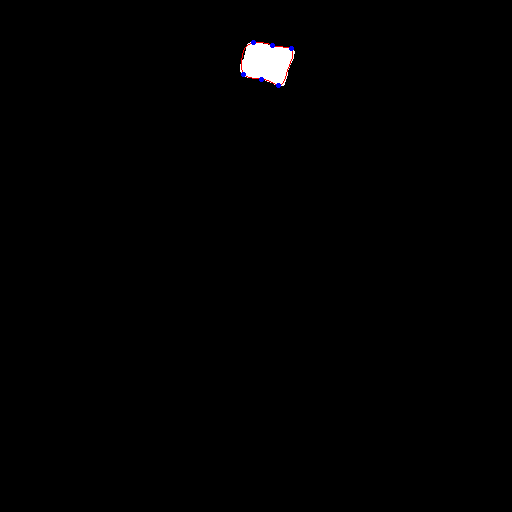

MR_0928_L_5.png


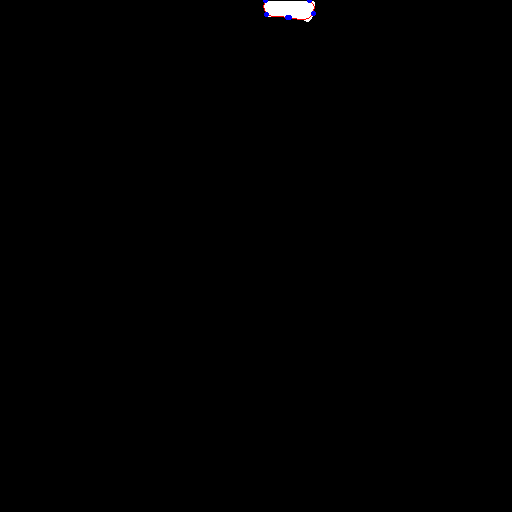

MR_1437_L_4.png


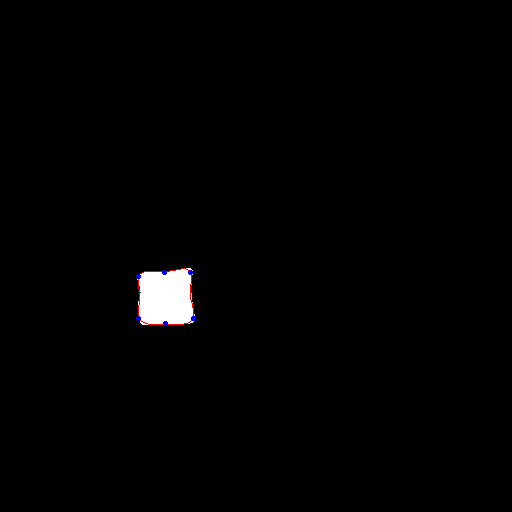

MR_1835_L_1.png


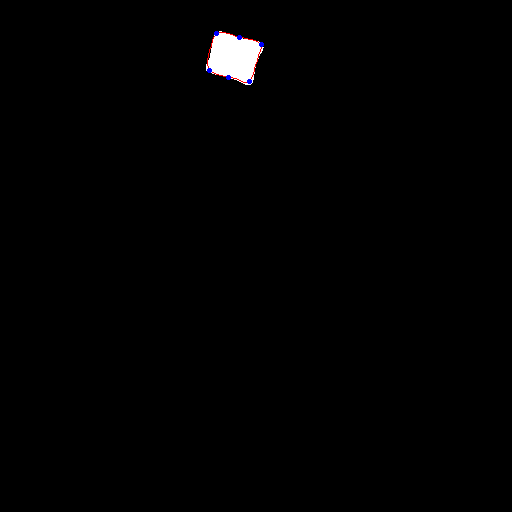

MR_2094_L_5.png


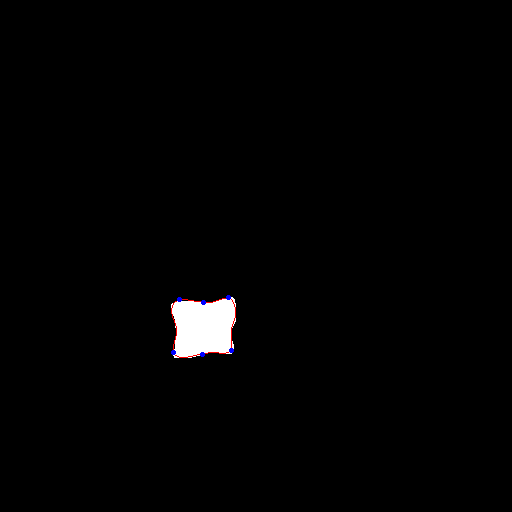

MR_0892_L_6.png


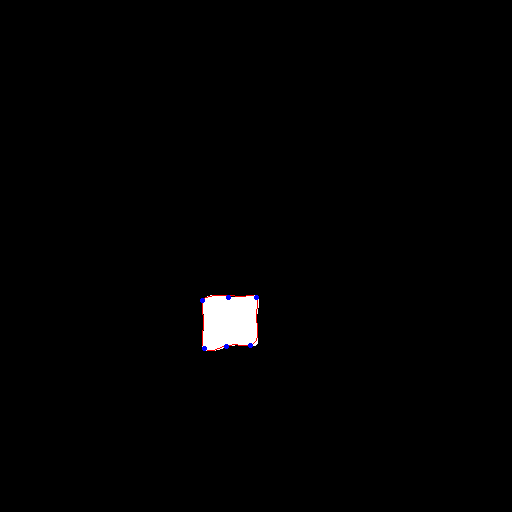

MR_1665_L_0.png


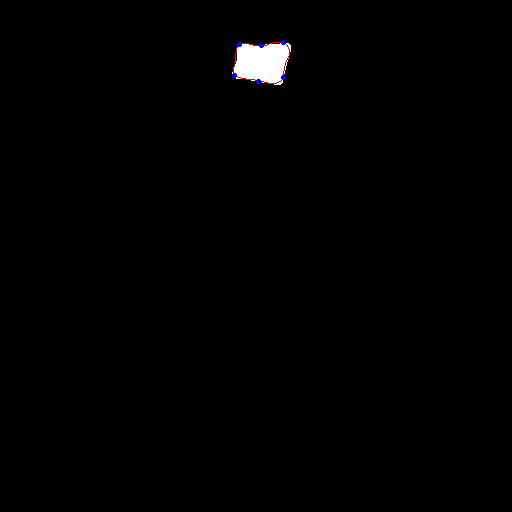

MR_2204_L_2.png


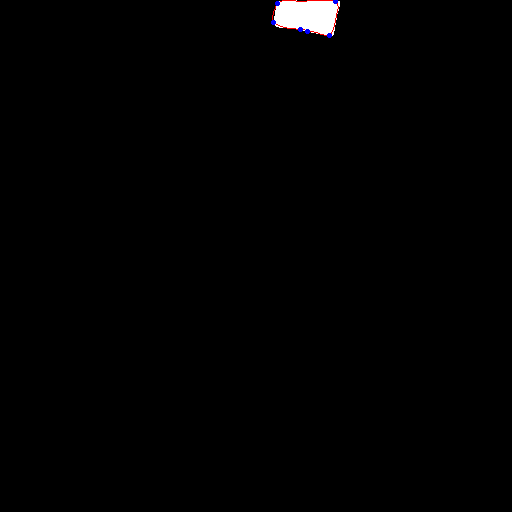

MR_1401_L_6.png


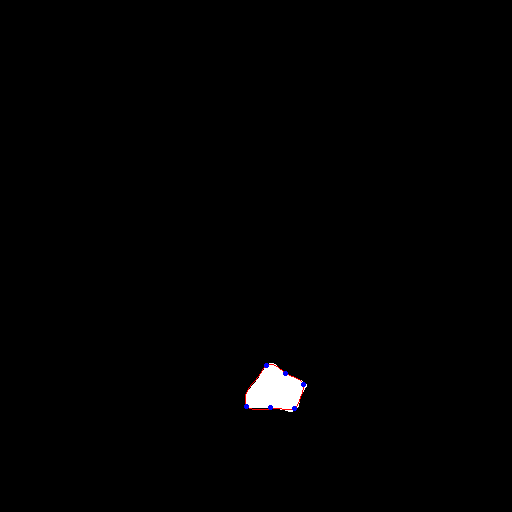

MR_0600_L_4.png


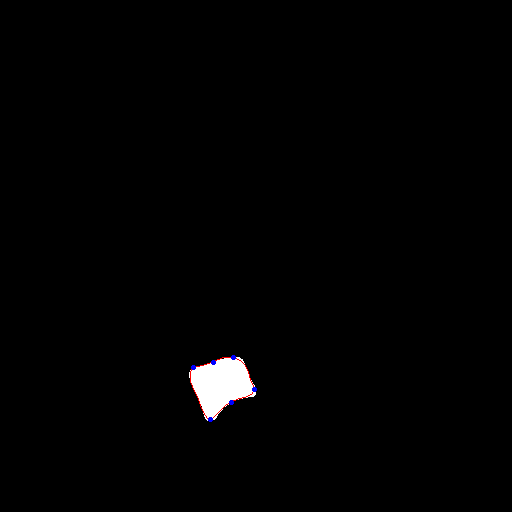

MR_0217_L_0.png


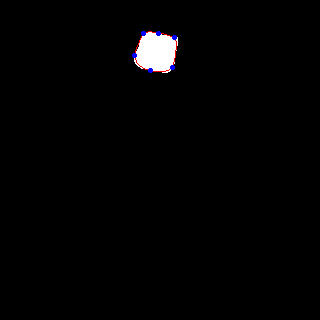

MR_2118_L_4.png


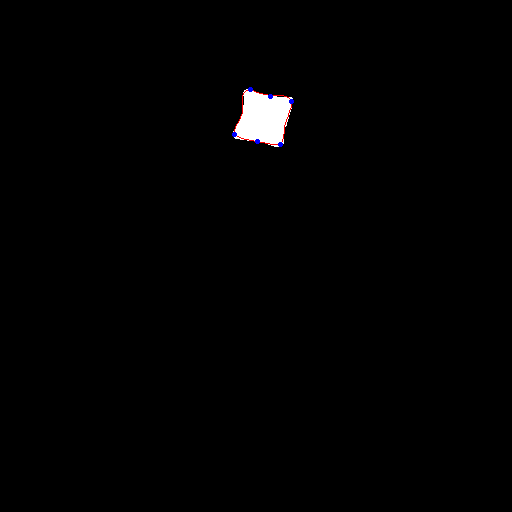

MR_0778_L_4.png


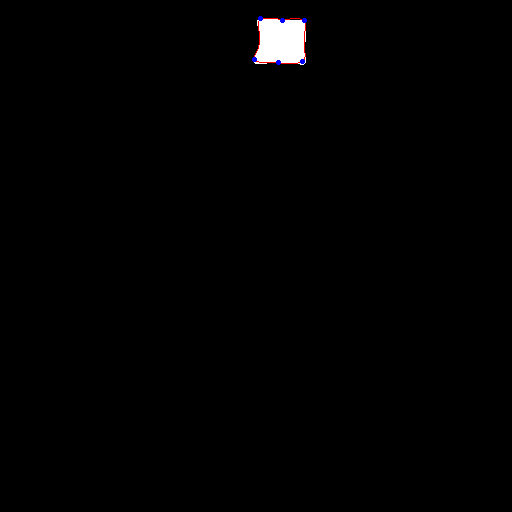

MR_2214_L_2.png


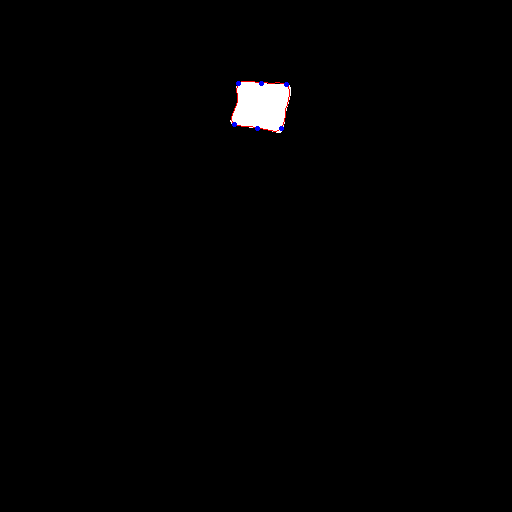

MR_0610_L_4.png


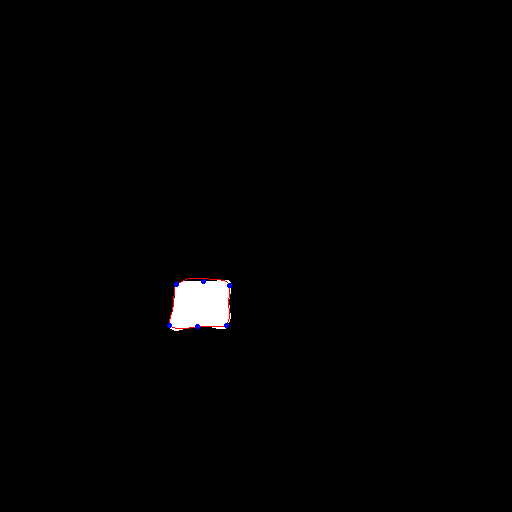

MR_0882_L_6.png


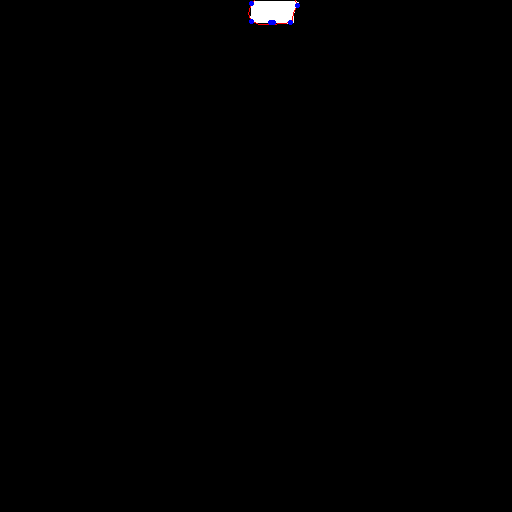

MR_2070_L_4.png


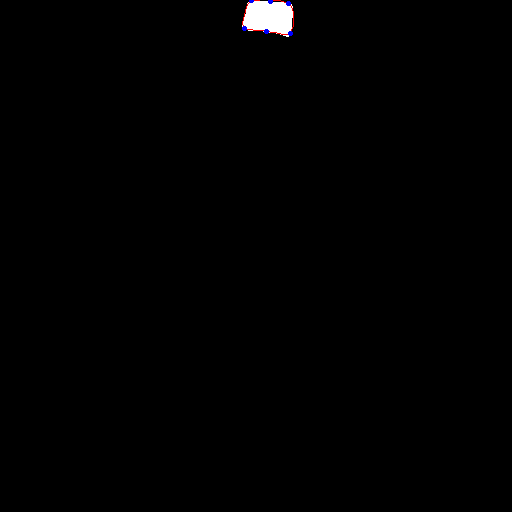

MR_2084_L_5.png


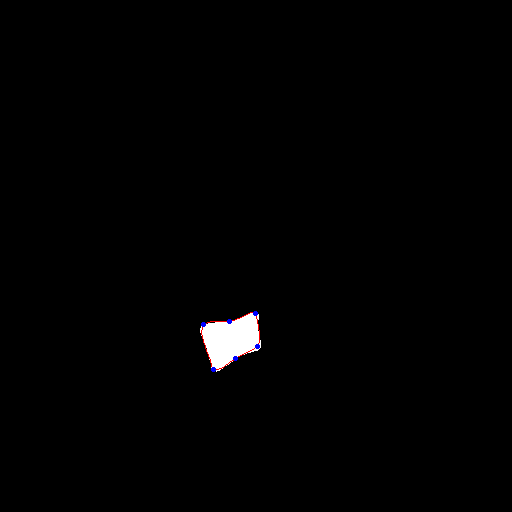

MR_0480_L_3.png


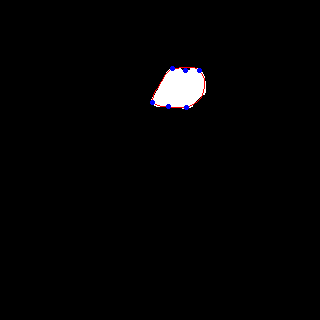

MR_1681_L_1.png


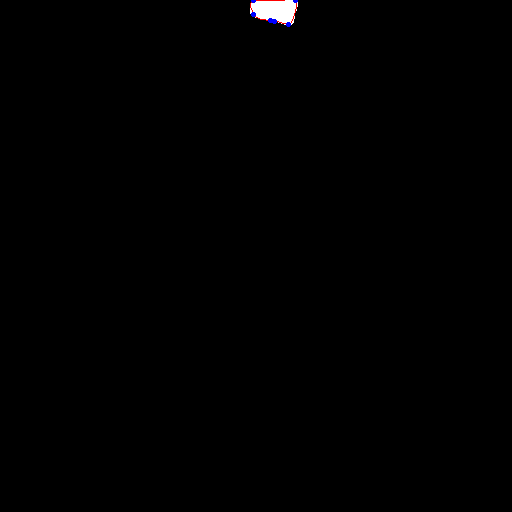

MR_0063_L_6.png


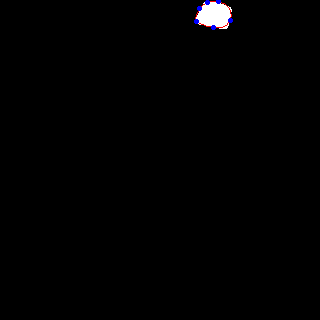

MR_0768_L_4.png
list index out of range
MR_1006_L_2.png


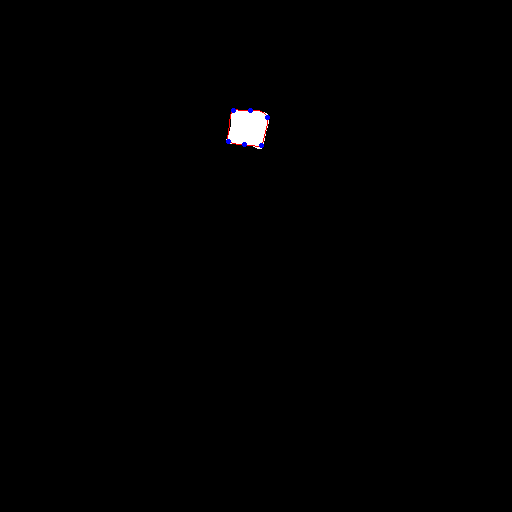

MR_0566_L_4.png


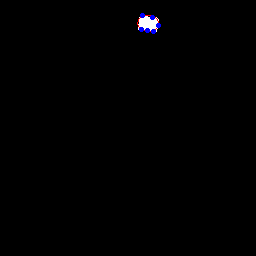

MR_2162_L_2.png


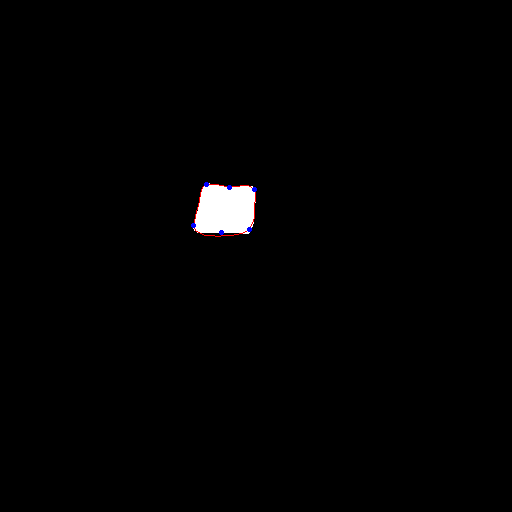

MR_2196_L_3.png


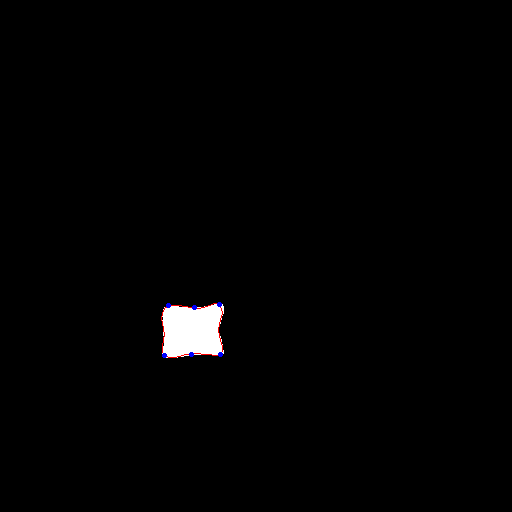

MR_0964_L_1.png


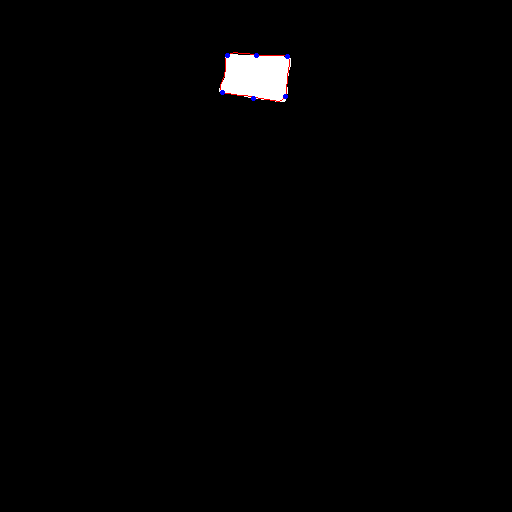

MR_0990_L_0.png


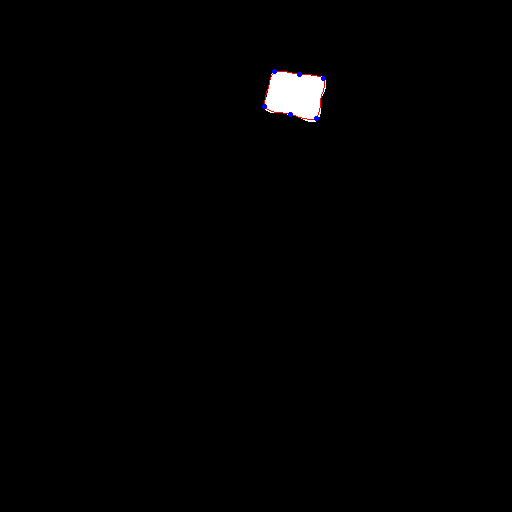

MR_1370_L_2.png


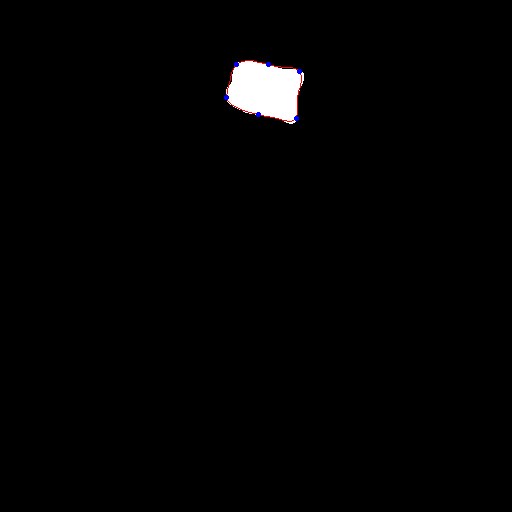

MR_1513_L_0.png
list index out of range
MR_1911_L_5.png


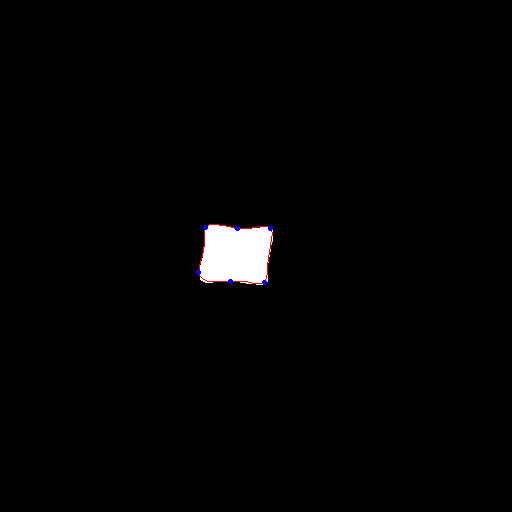

MR_2172_L_2.png


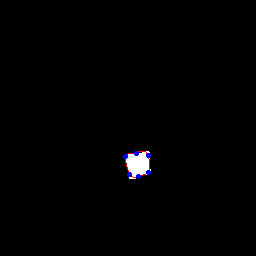

MR_0827_L_8.png


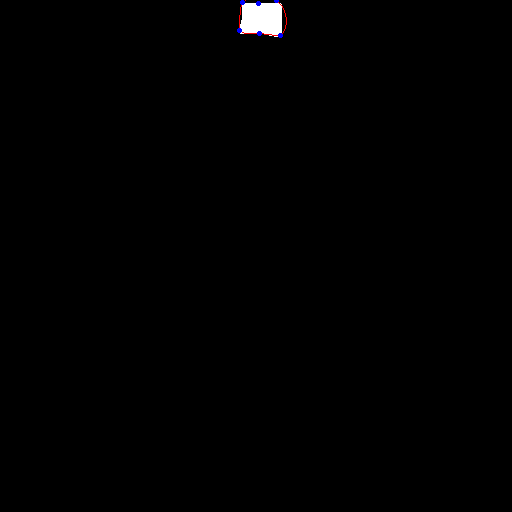

MR_1869_L_5.png


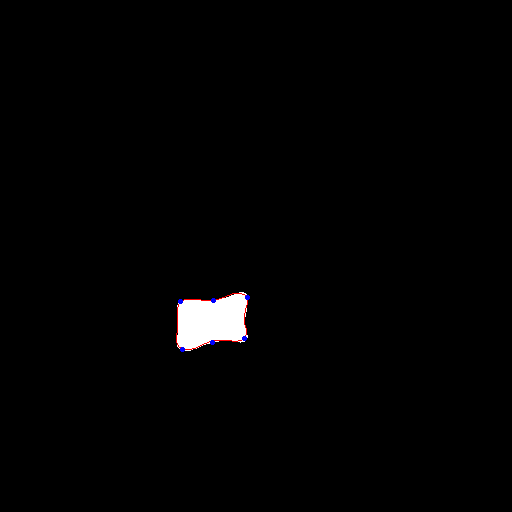

MR_1360_L_2.png


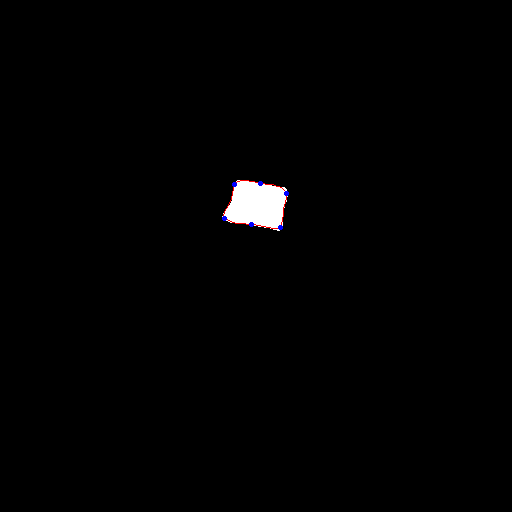

MR_1394_L_3.png


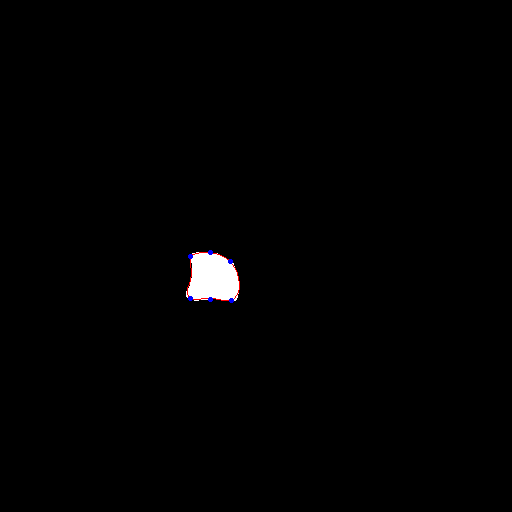

MR_1132_L_6.png


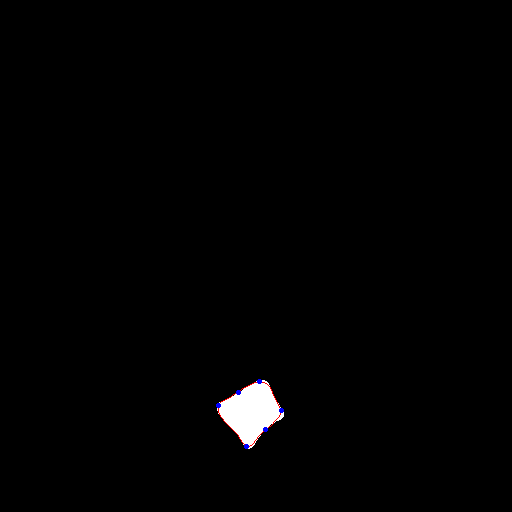

MR_1356_L_0.png


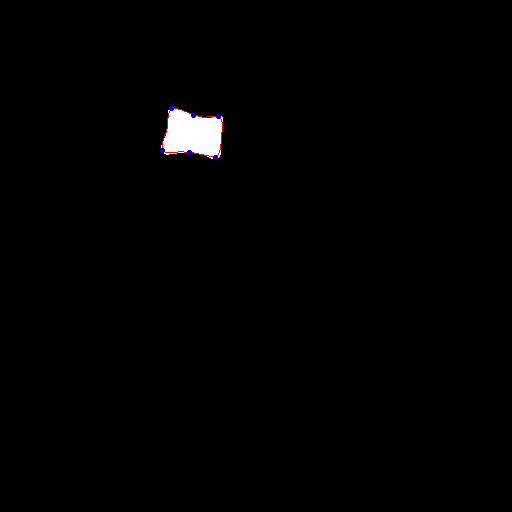

MR_2144_L_0.png


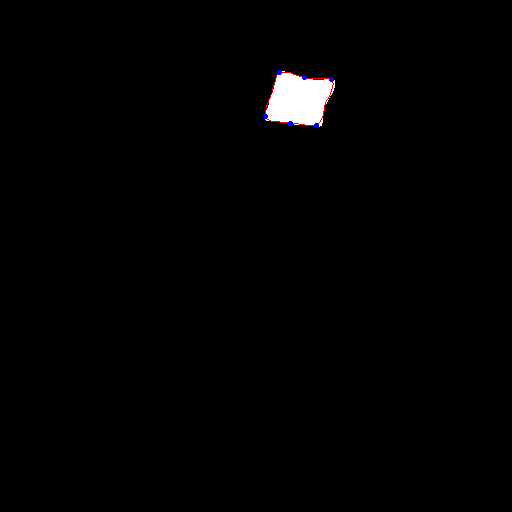

MR_1525_L_2.png


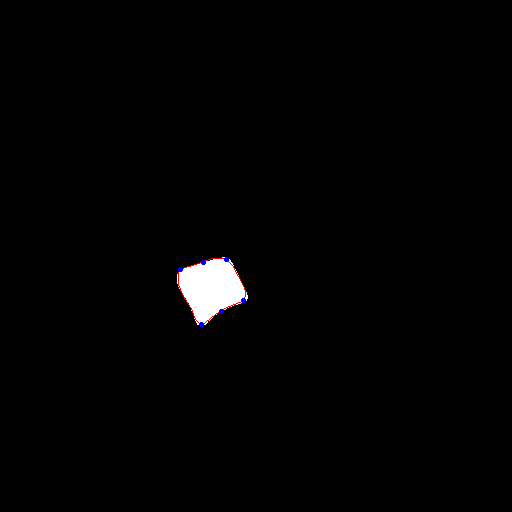

MR_2248_L_6.png


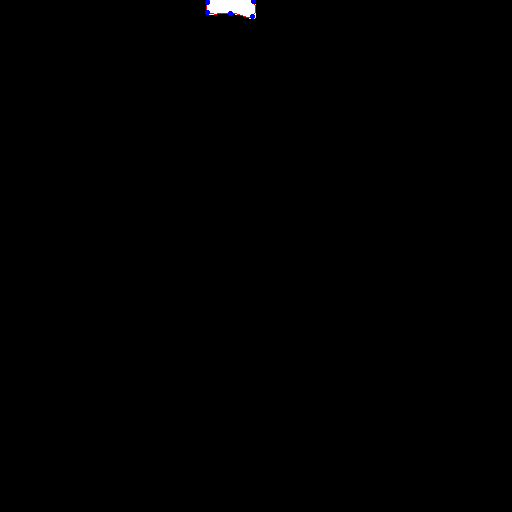

MR_1629_L_4.png


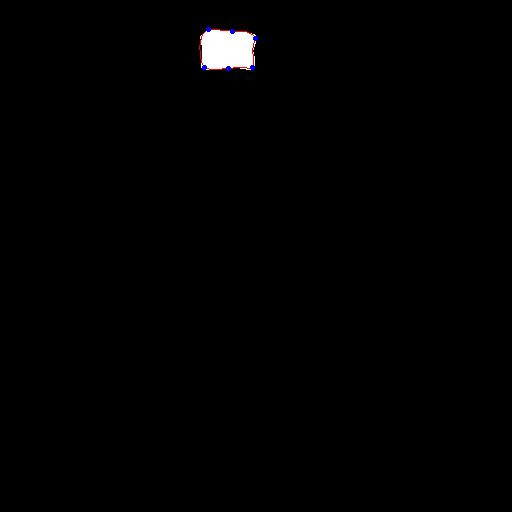

MR_0428_L_6.png


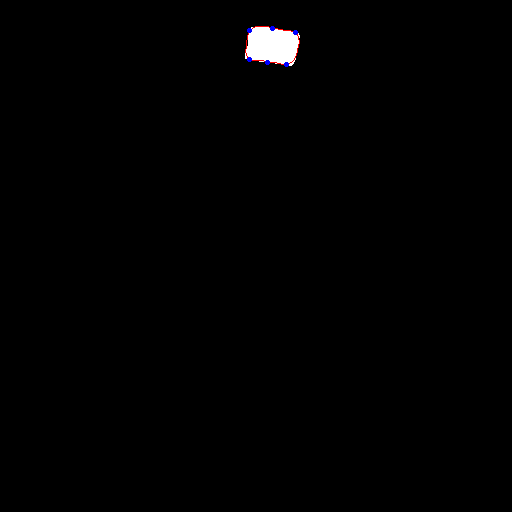

MR_1535_L_2.png


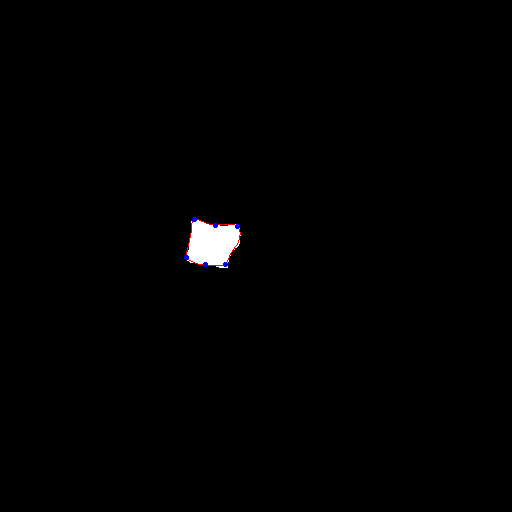

MR_0952_L_3.png


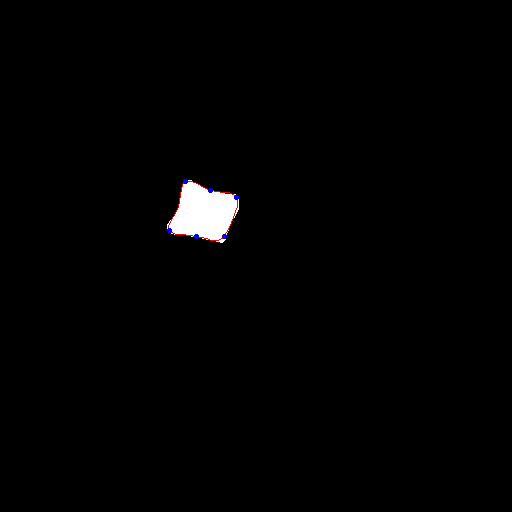

MR_2154_L_0.png


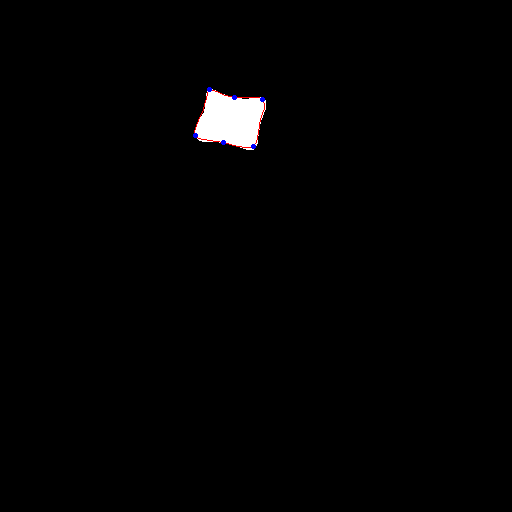

MR_0550_L_6.png


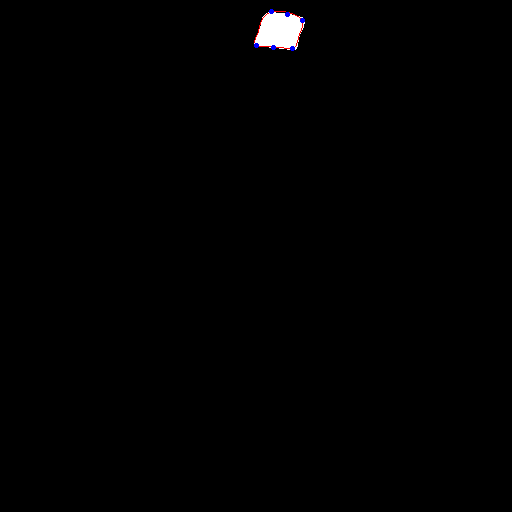

MR_1245_L_3.png


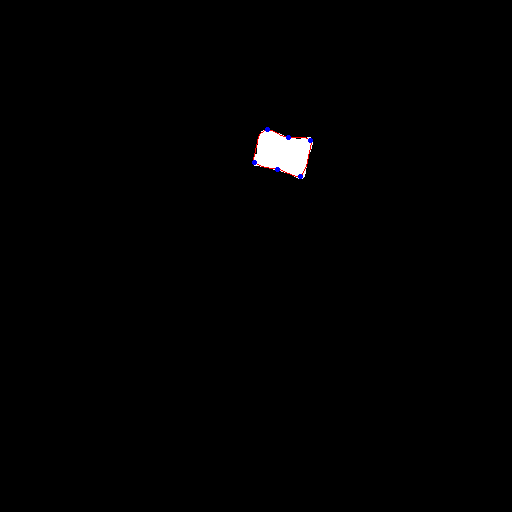

MR_2233_L_5.png


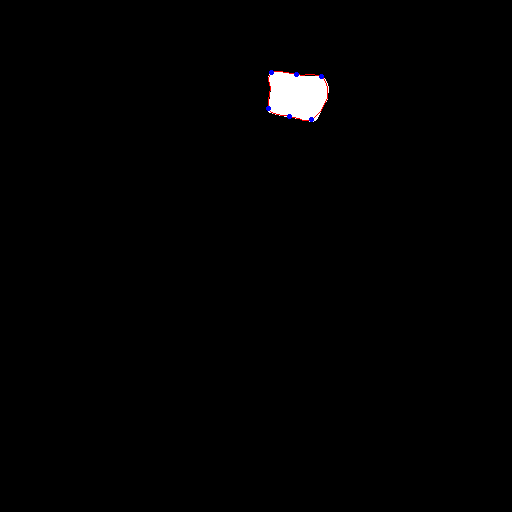

MR_0637_L_3.png


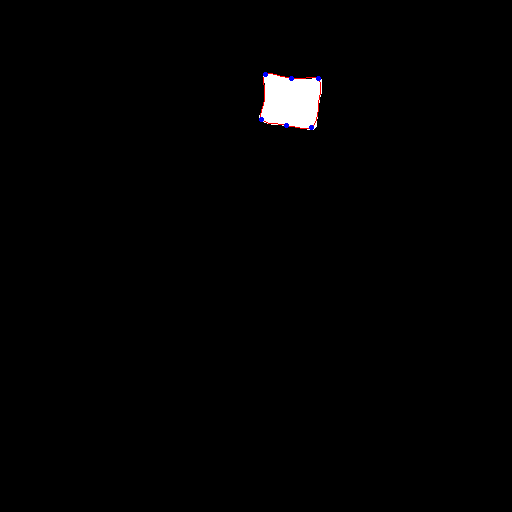

MR_1436_L_1.png


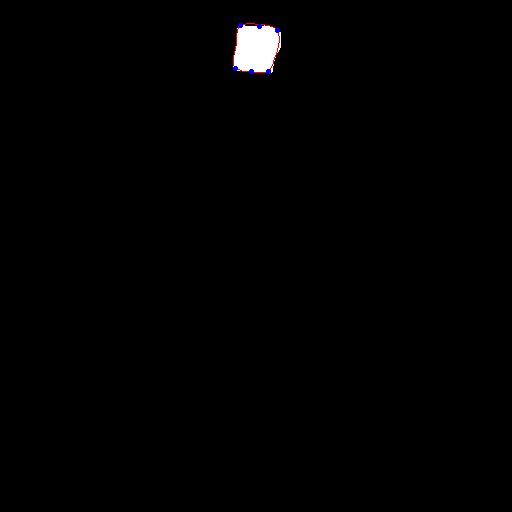

MR_0851_L_0.png


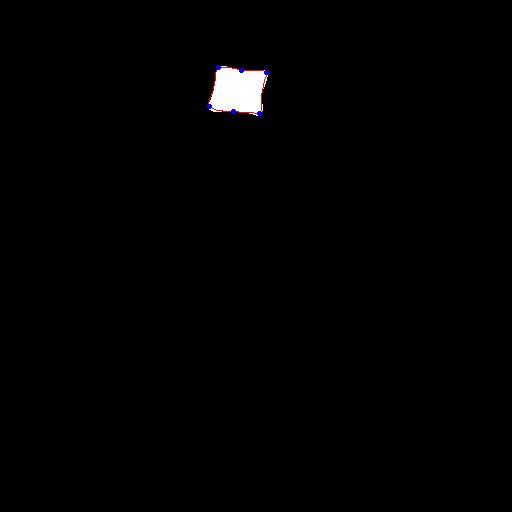

MR_2057_L_3.png


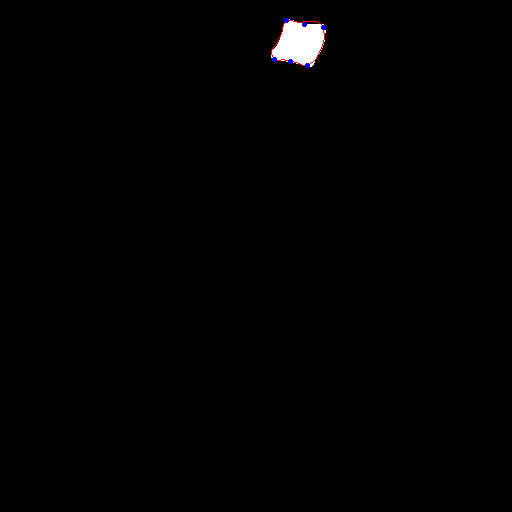

MR_0453_L_5.png


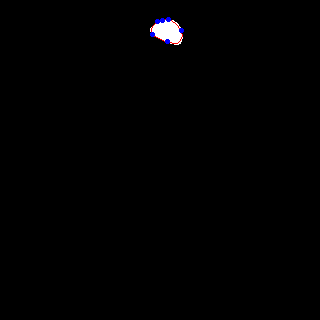

MR_0054_L_1.png


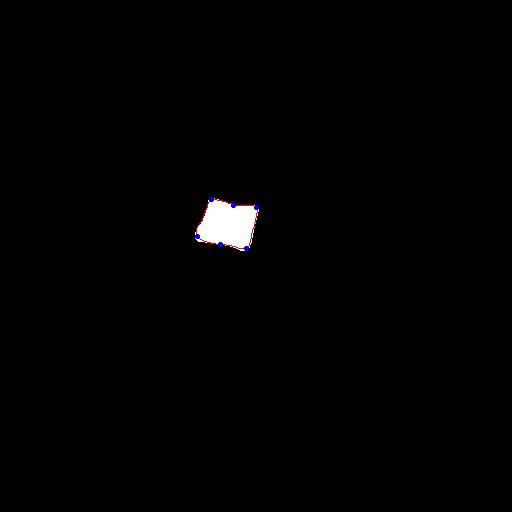

MR_2047_L_3.png


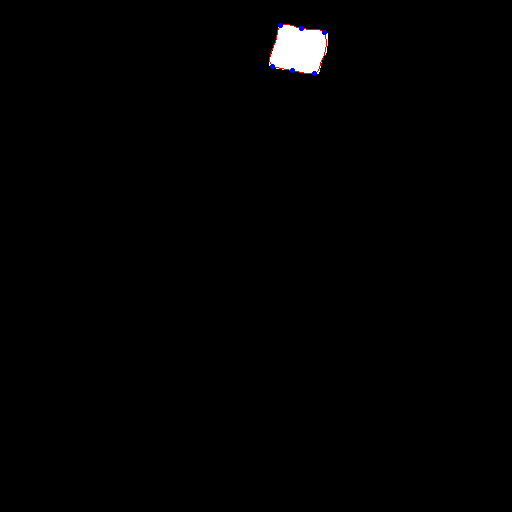

MR_0841_L_0.png


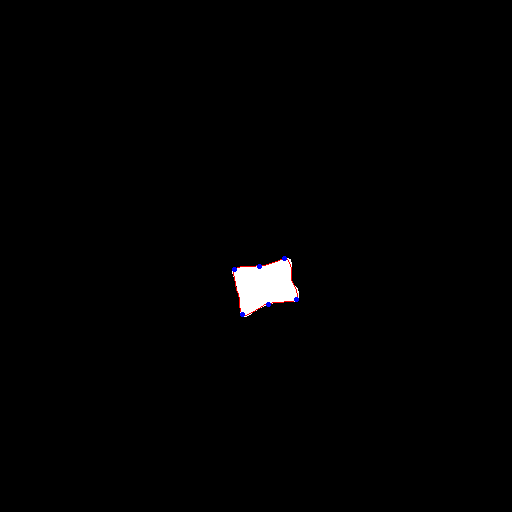

MR_1642_L_7.png


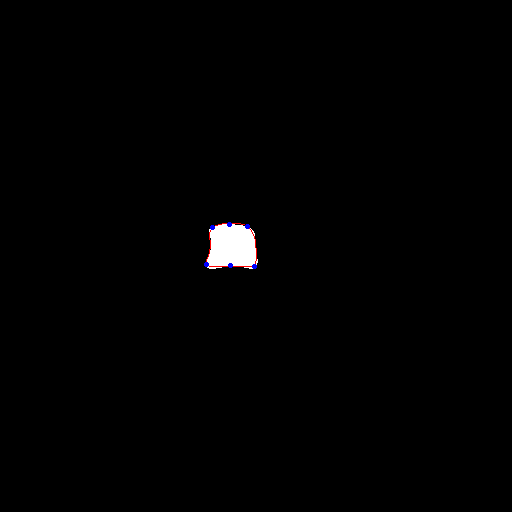

MR_0443_L_5.png


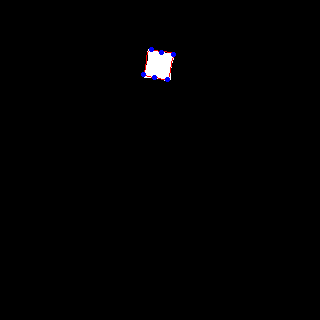

MR_1824_L_4.png


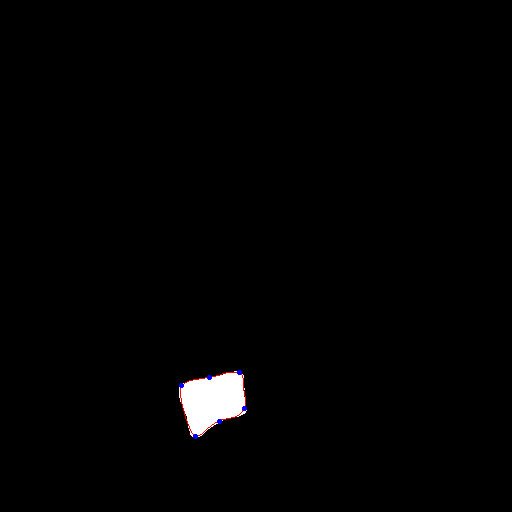

MR_1680_L_4.png
list index out of range
MR_2071_L_1.png


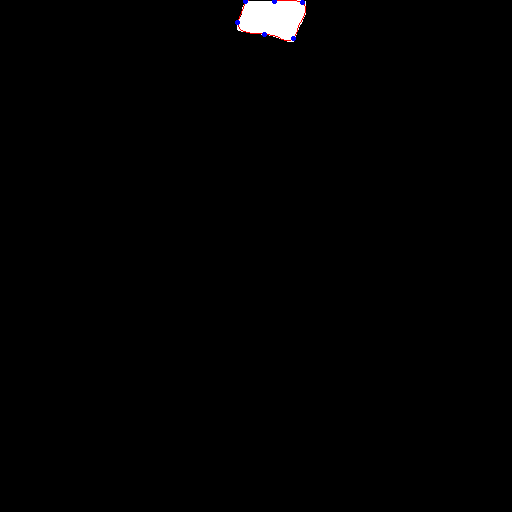

MR_1263_L_1.png


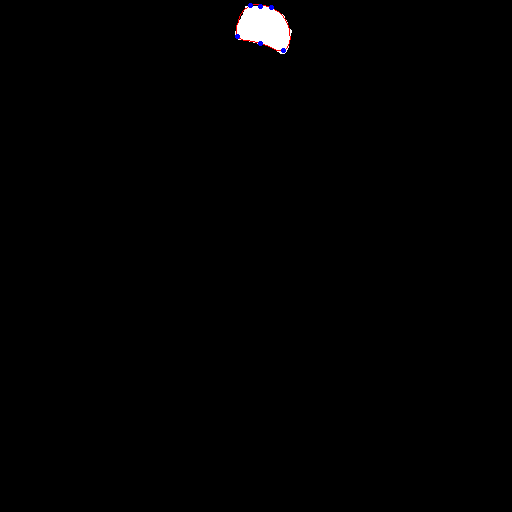

MR_1297_L_0.png


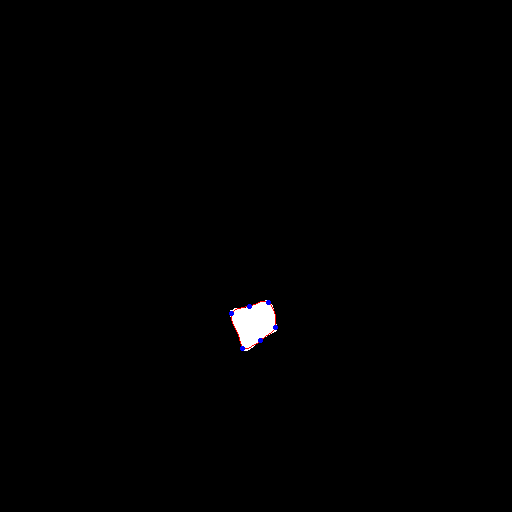

MR_2109_L_1.png


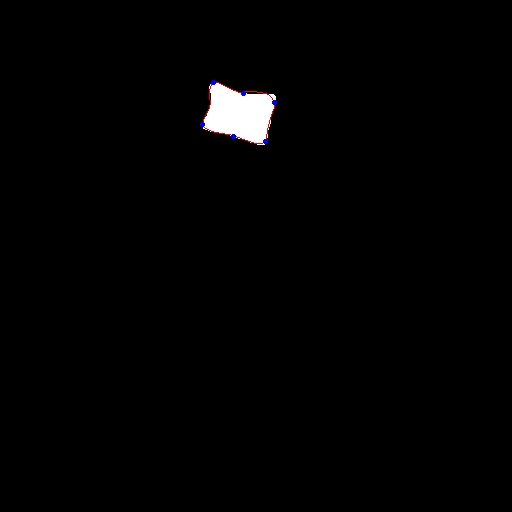

MR_2095_L_0.png


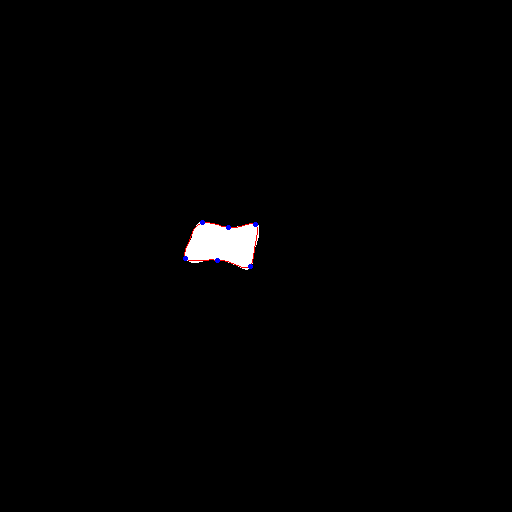

MR_0893_L_3.png


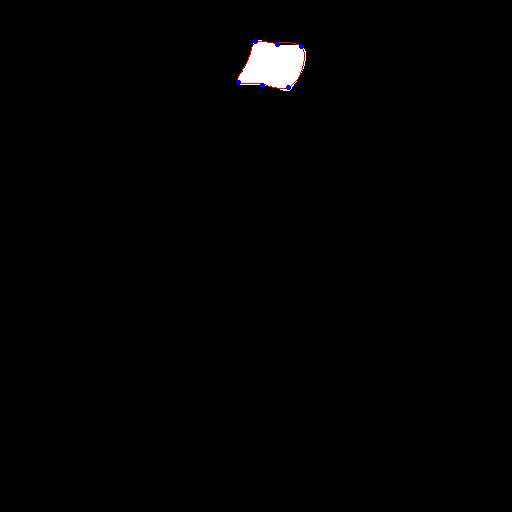

MR_0601_L_1.png


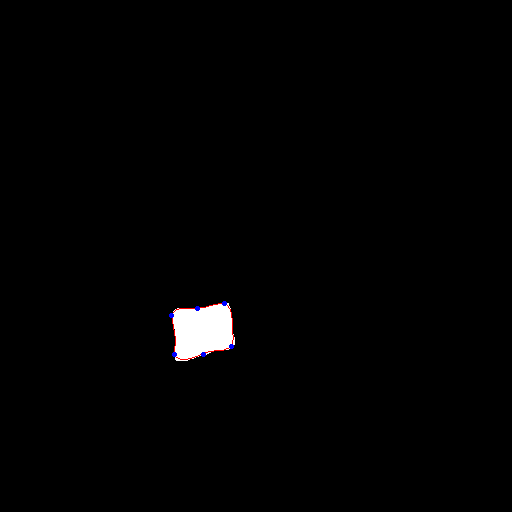

MR_1802_L_6.png


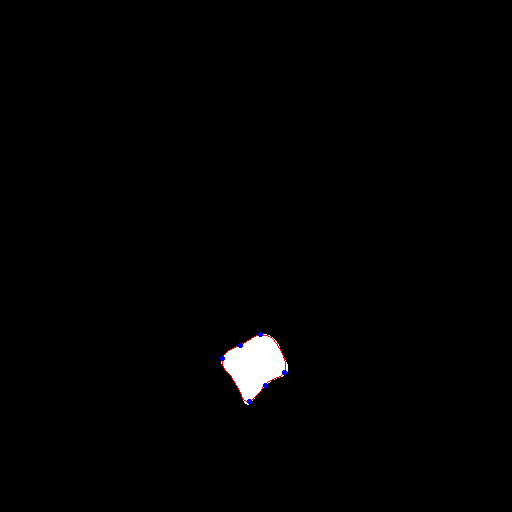

MR_2119_L_1.png


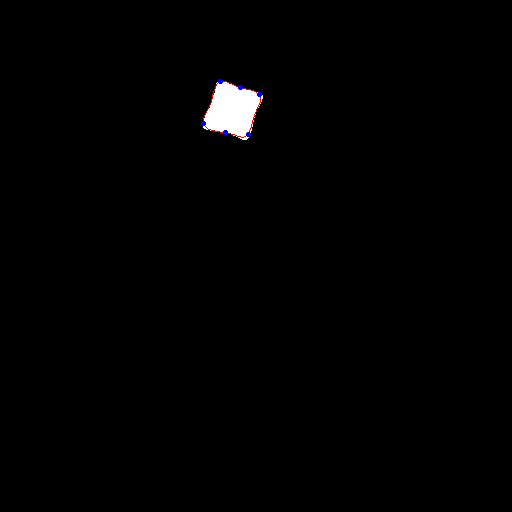

MR_1017_L_7.png


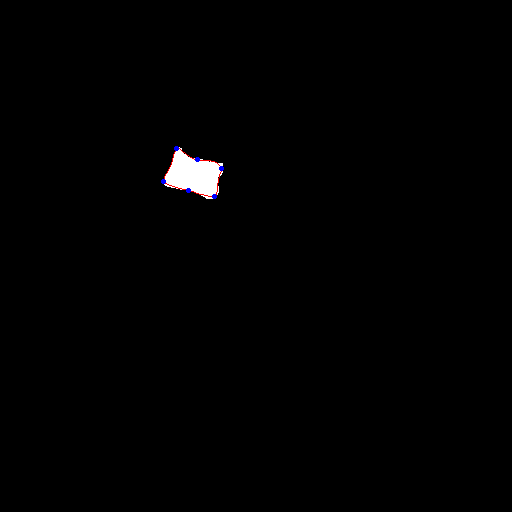

MR_1578_L_3.png


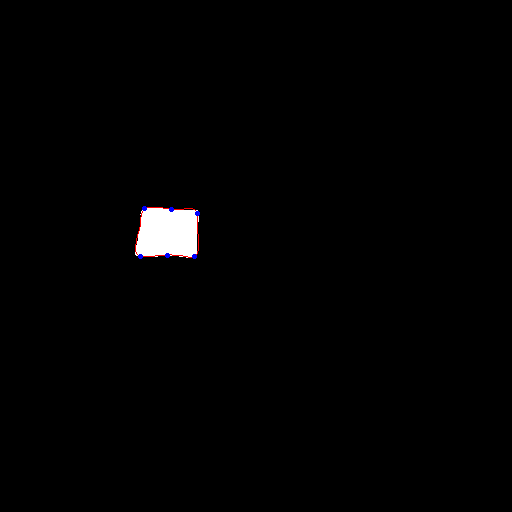

MR_0086_L_2.png


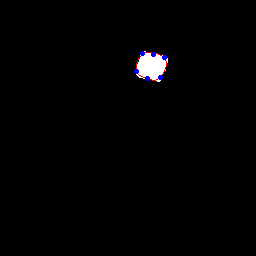

MR_1273_L_1.png


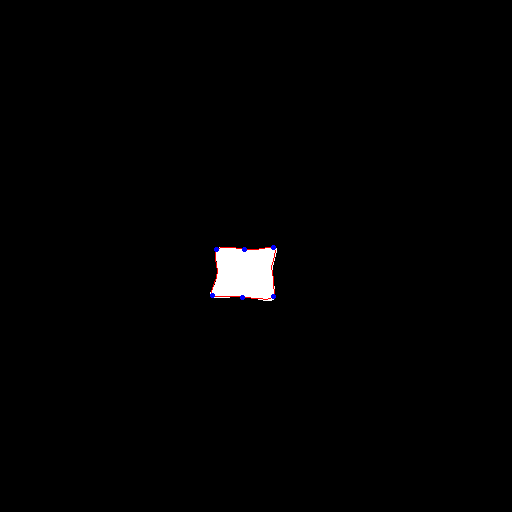

MR_1910_L_0.png


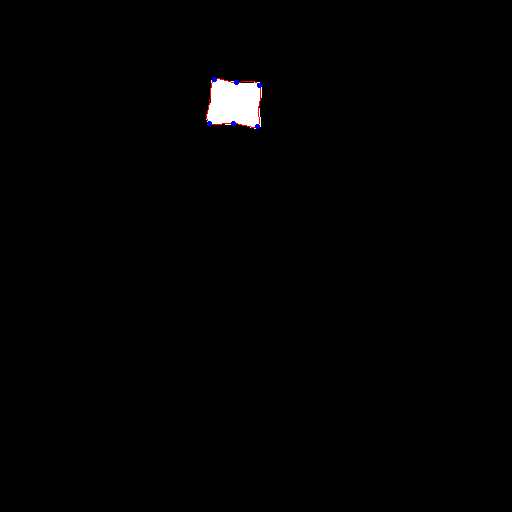

MR_0975_L_4.png


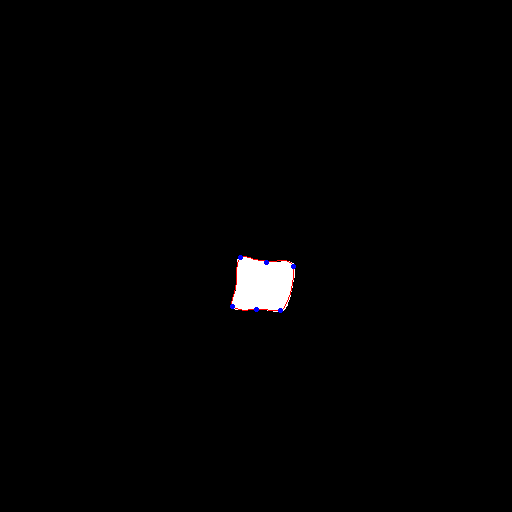

MR_1089_L_0.png
list index out of range
MR_0577_L_1.png
list index out of range
MR_0583_L_0.png


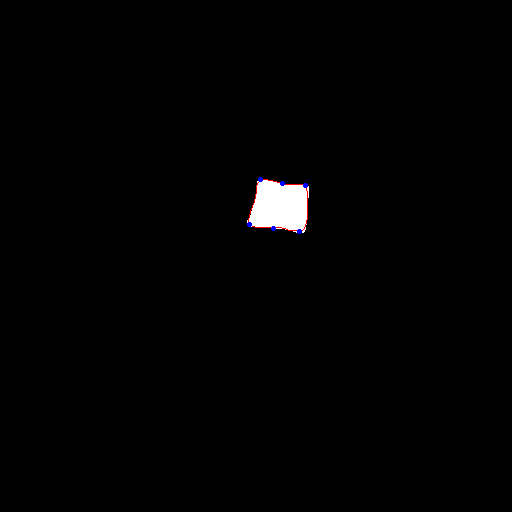

MR_1782_L_2.png


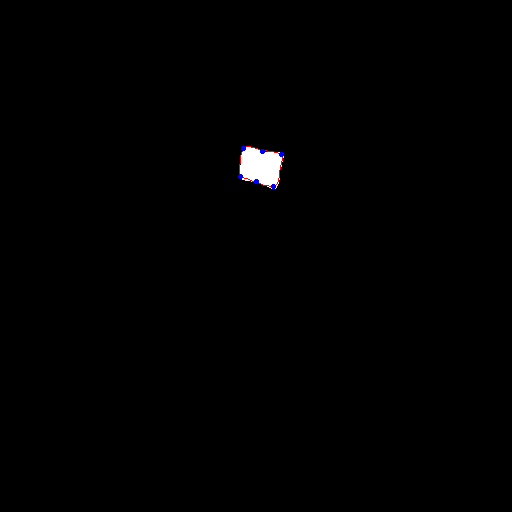

MR_1395_L_6.png


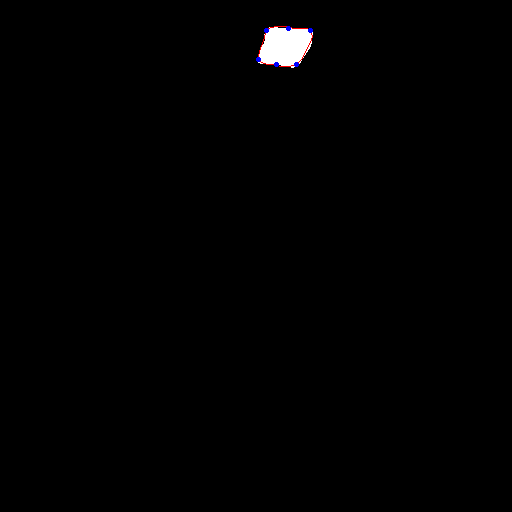

MR_1868_L_0.png


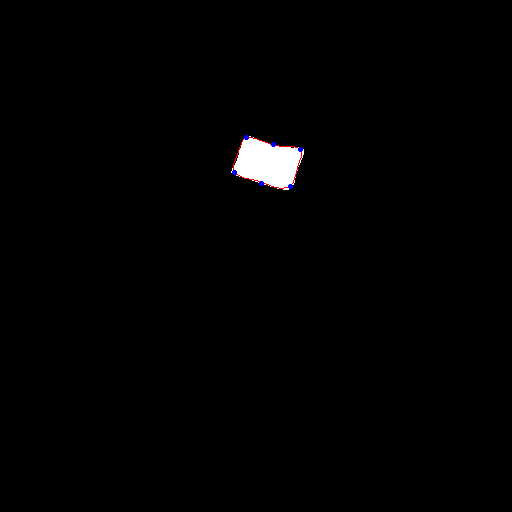

MR_0194_L_4.png


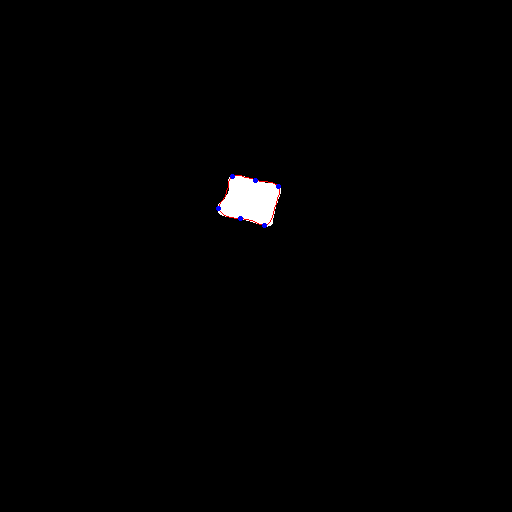

MR_1105_L_1.png


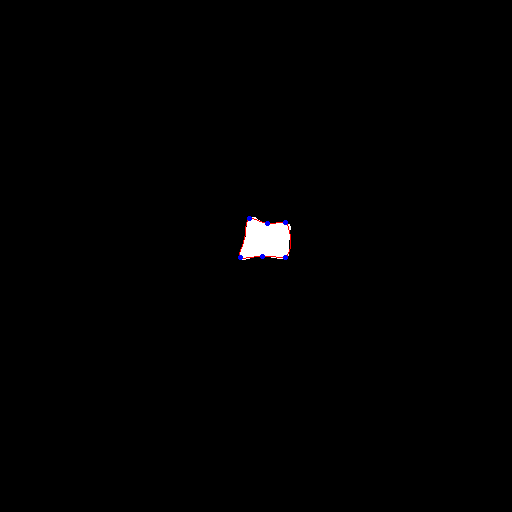

MR_0991_L_5.png


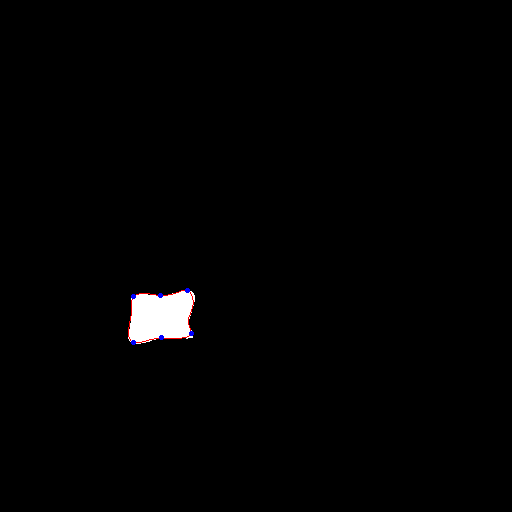

MR_0567_L_1.png


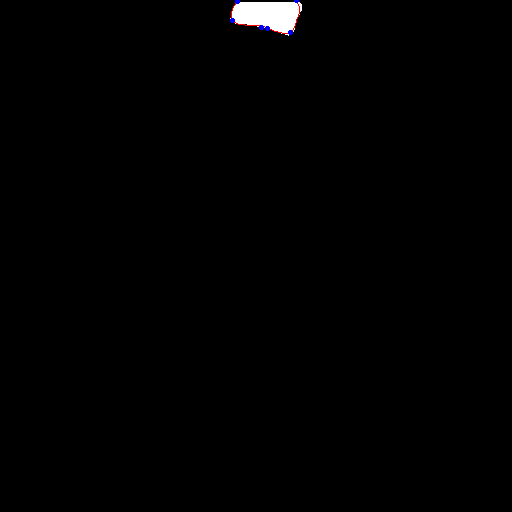

MR_1900_L_0.png


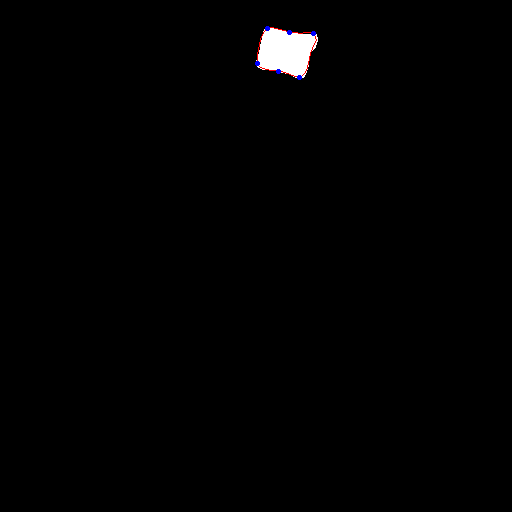

MR_0008_L_5.png


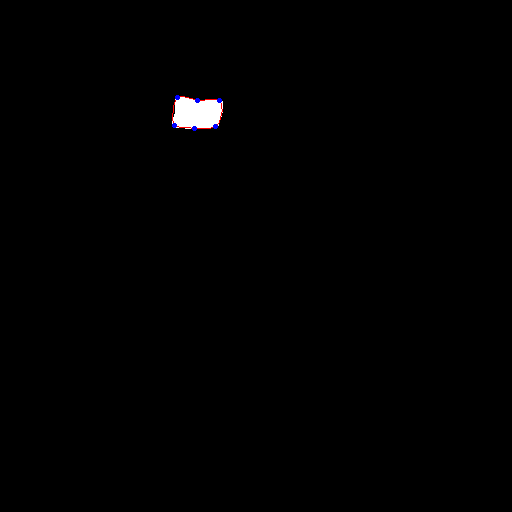

MR_1502_L_5.png


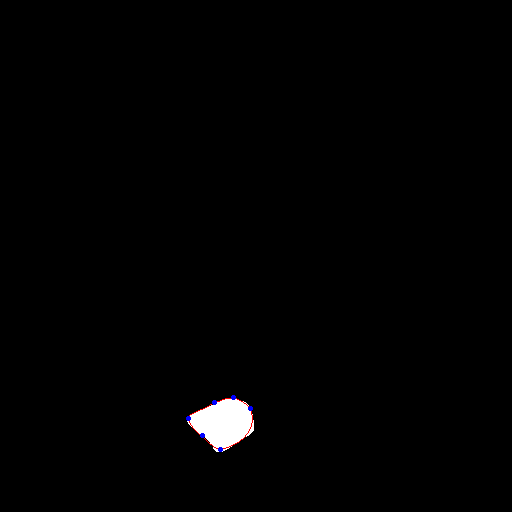

MR_2254_L_8.png


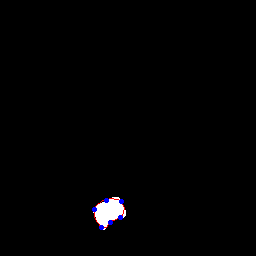

MR_0184_L_4.png


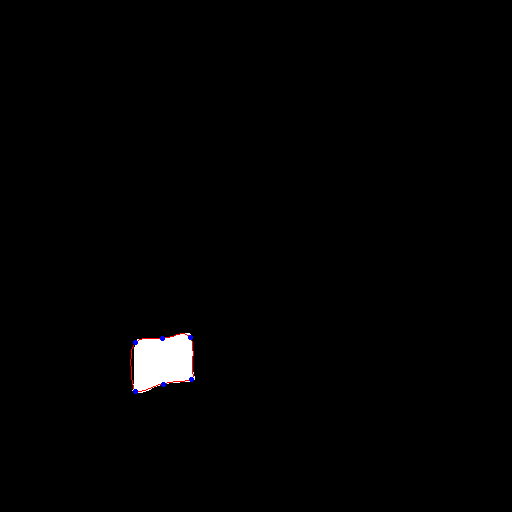

MR_1347_L_5.png


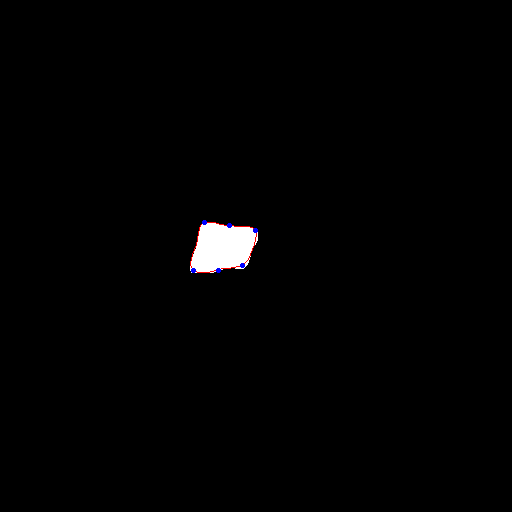

MR_2331_L_3.png


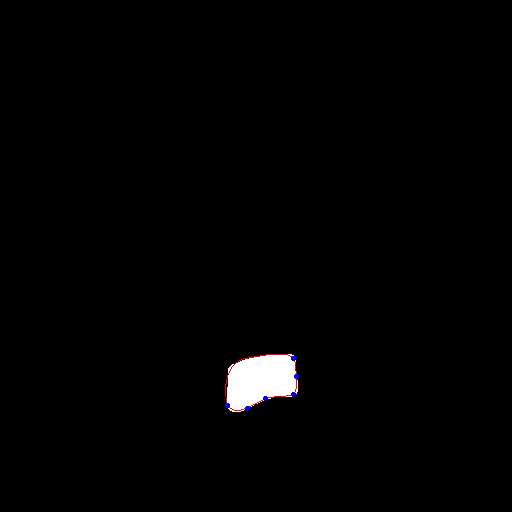

MR_0551_L_3.png


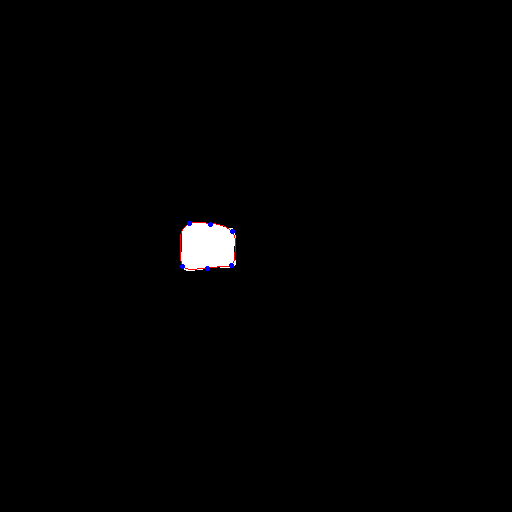

MR_1750_L_1.png


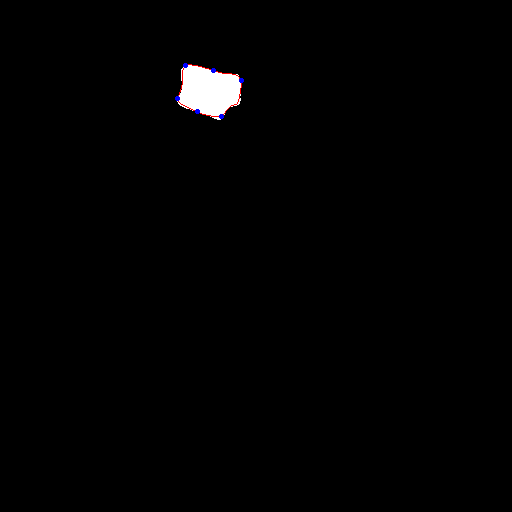

MR_0953_L_6.png


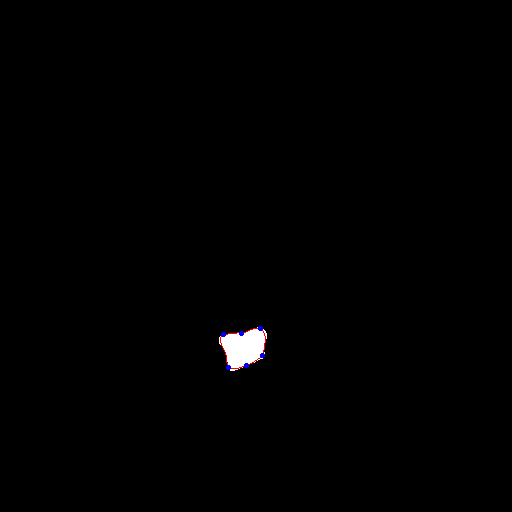

MR_2155_L_5.png


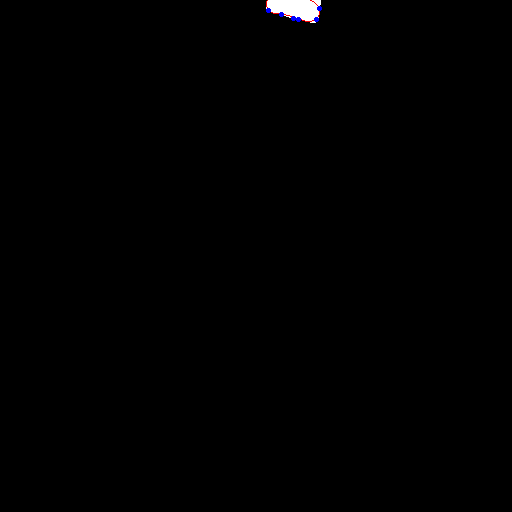

MR_1133_L_3.png


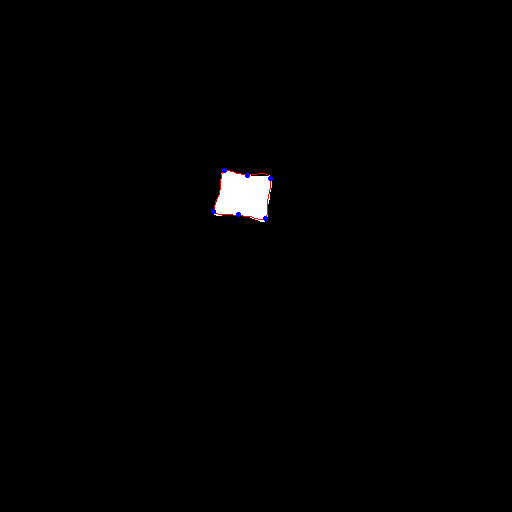

MR_1357_L_5.png


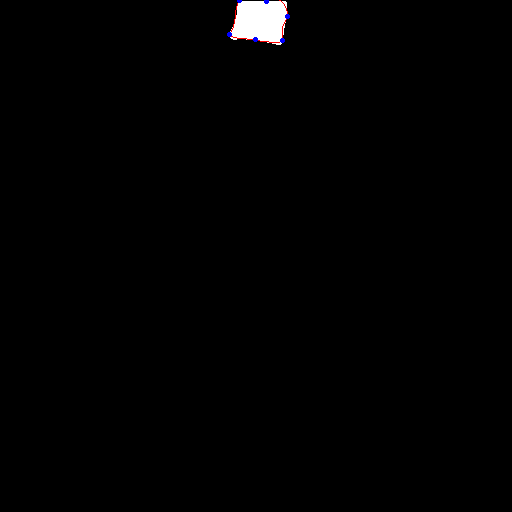

MR_0541_L_3.png


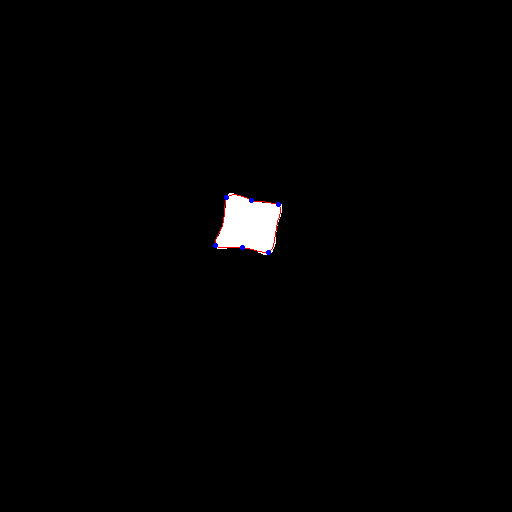

MR_0943_L_6.png
list index out of range
MR_0725_L_5.png


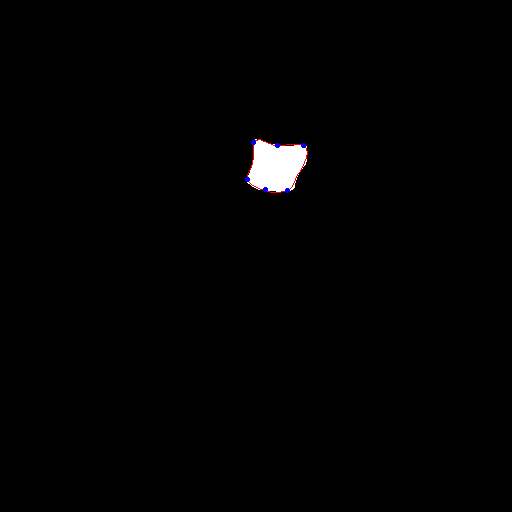

MR_2321_L_3.png


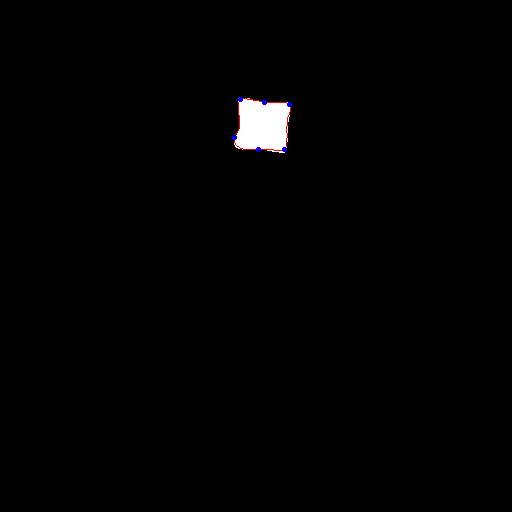

MR_1357_L_4.png
list index out of range
MR_1133_L_2.png


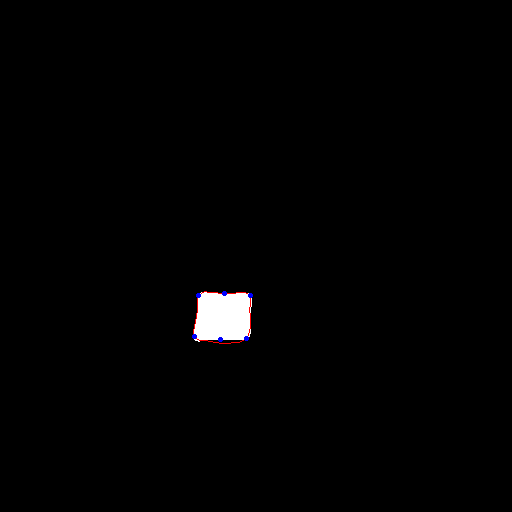

MR_2321_L_2.png


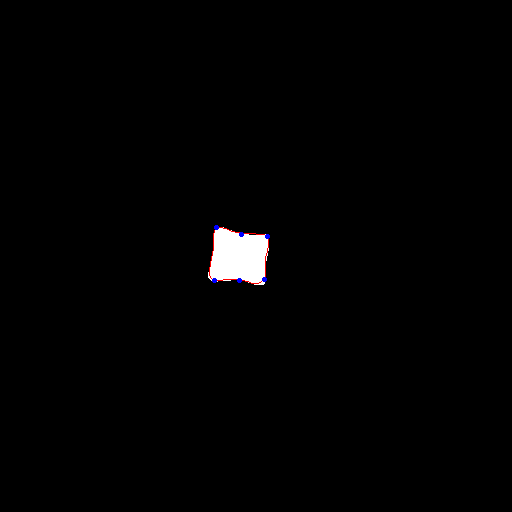

MR_0725_L_4.png


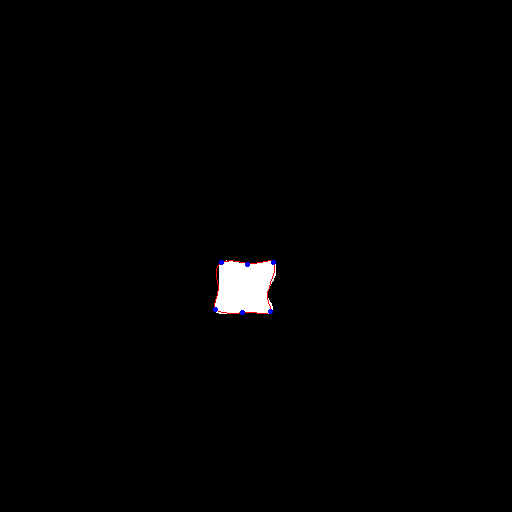

MR_0943_L_7.png


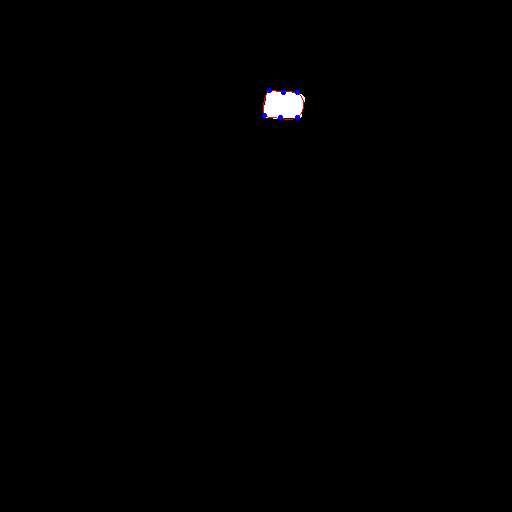

MR_0541_L_2.png


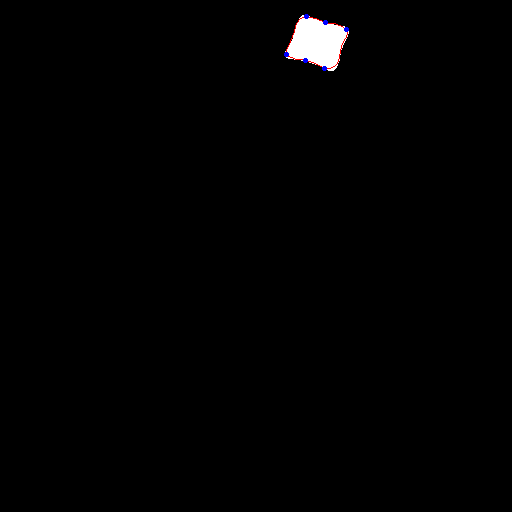

MR_1347_L_4.png


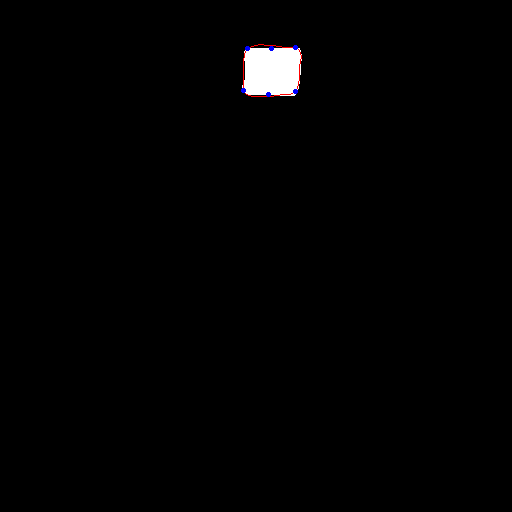

MR_2155_L_4.png
list index out of range
MR_0953_L_7.png


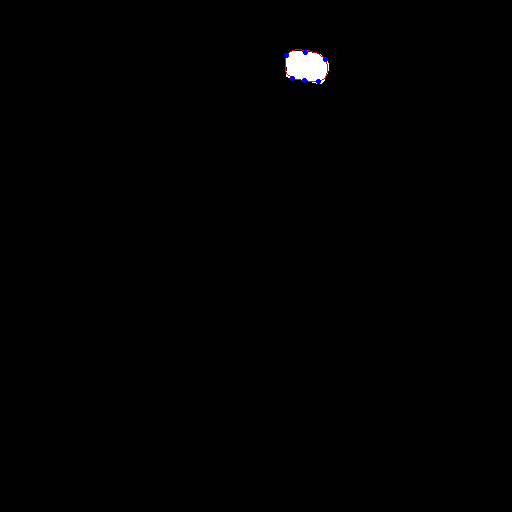

MR_1750_L_0.png


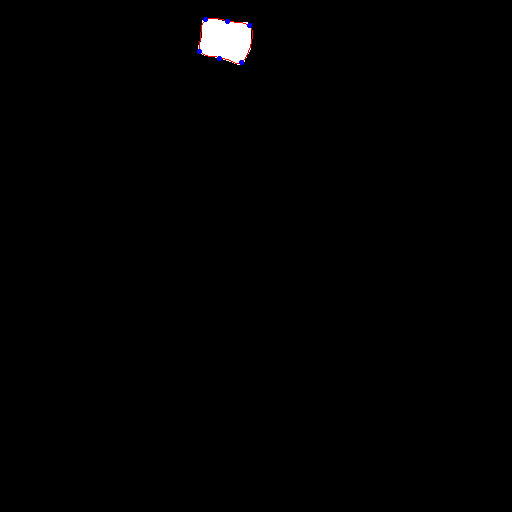

MR_0551_L_2.png


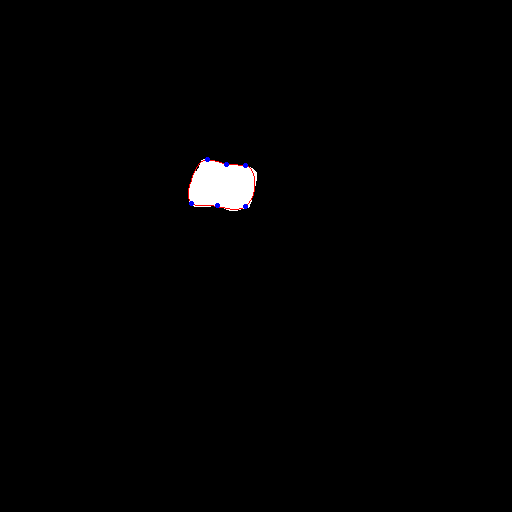

MR_2331_L_2.png


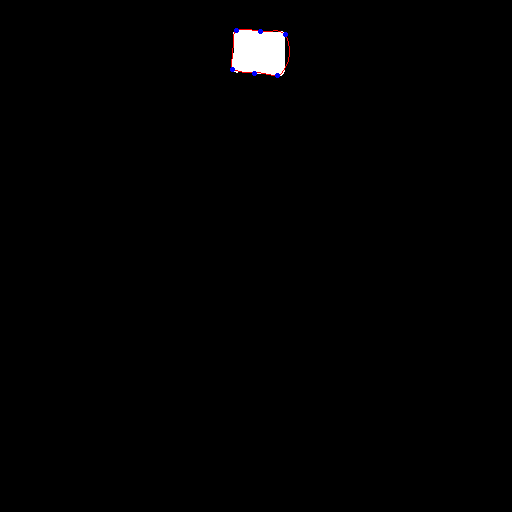

MR_1534_L_6.png


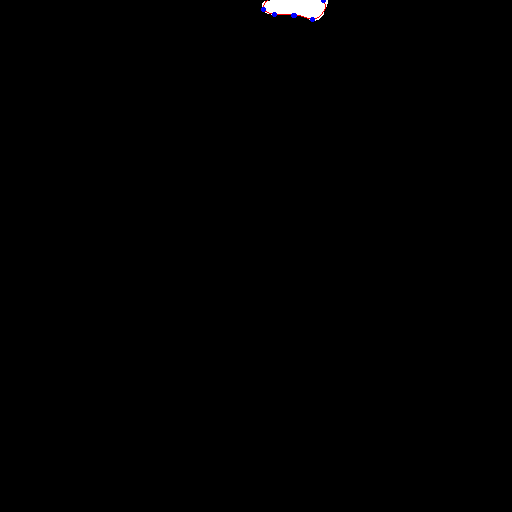

MR_1502_L_4.png


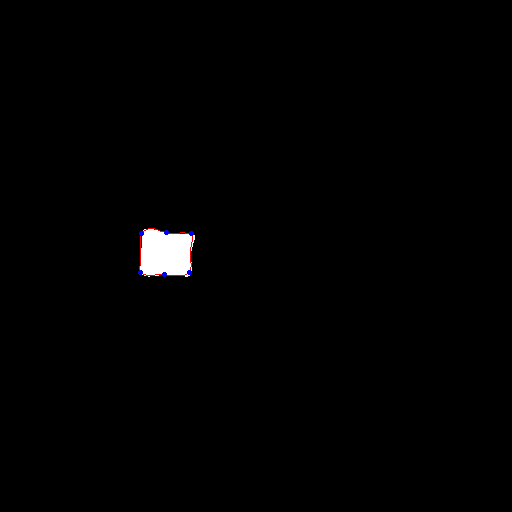

MR_0008_L_4.png


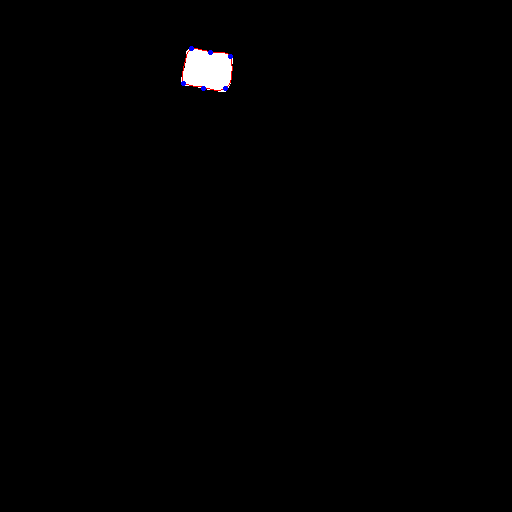

MR_1900_L_1.png


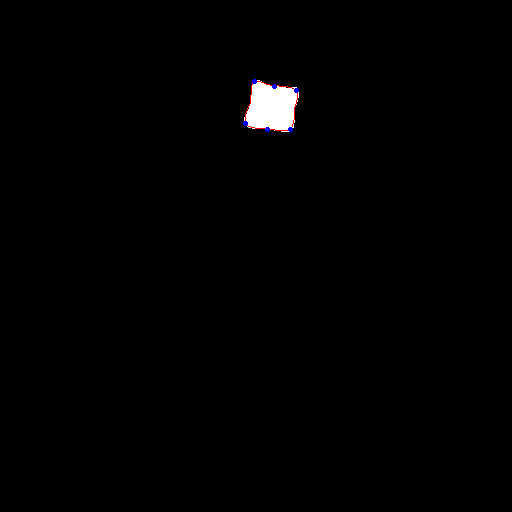

MR_0567_L_0.png


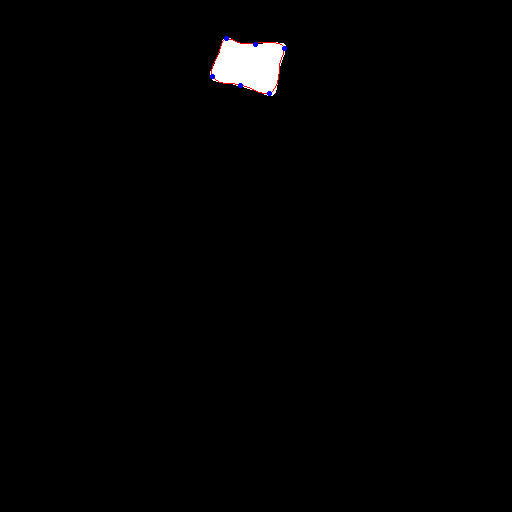

MR_0991_L_4.png


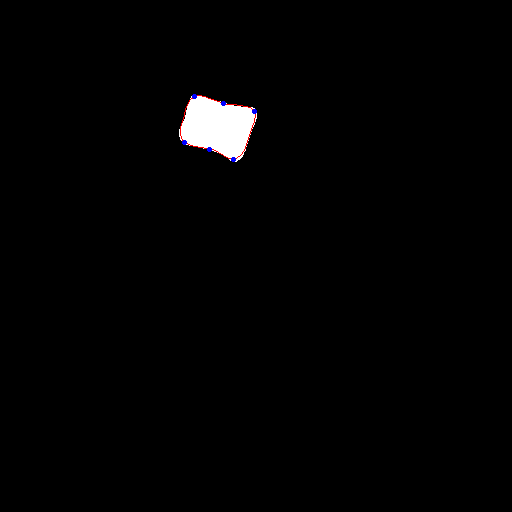

MR_1371_L_6.png


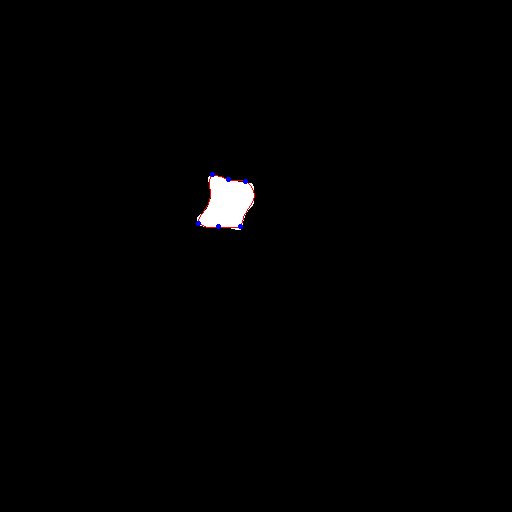

MR_0184_L_5.png


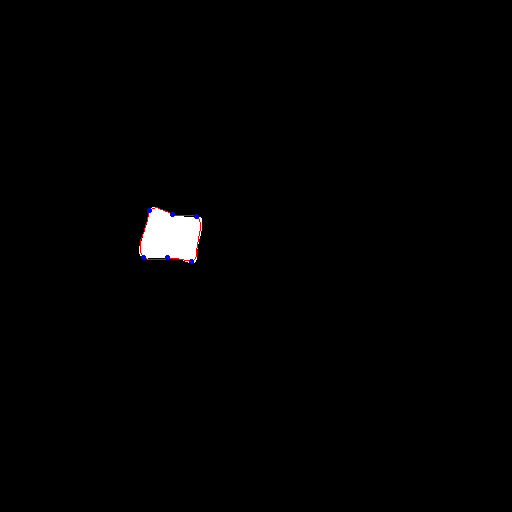

MR_2254_L_9.png


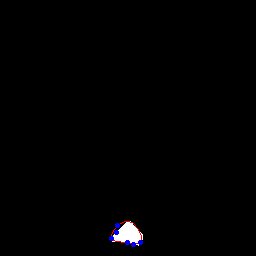

MR_1782_L_3.png


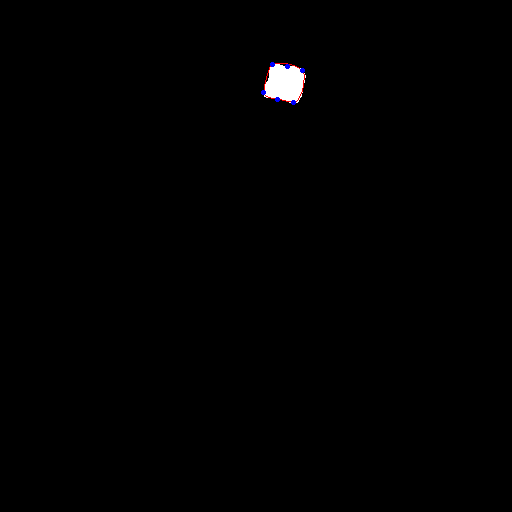

MR_0577_L_0.png


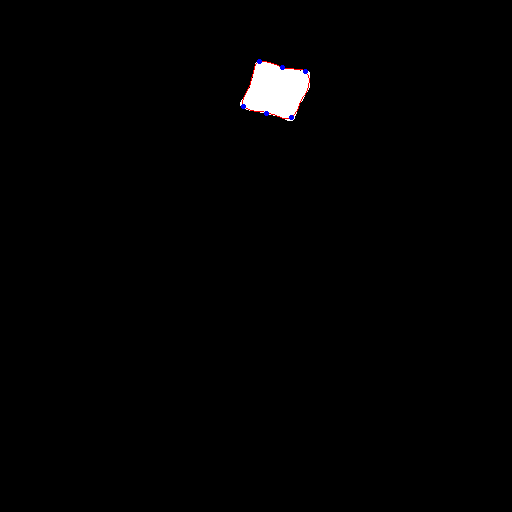

MR_0583_L_1.png


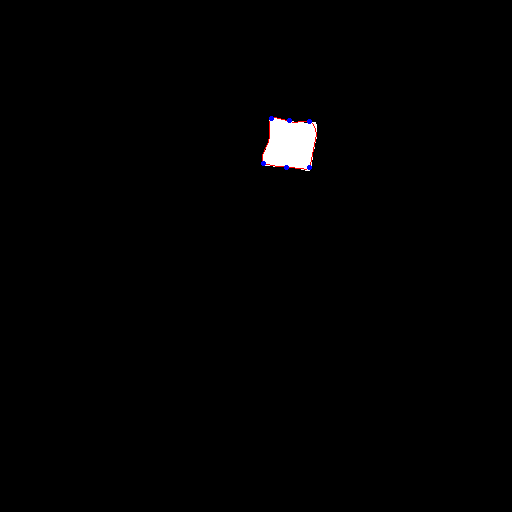

MR_2173_L_6.png


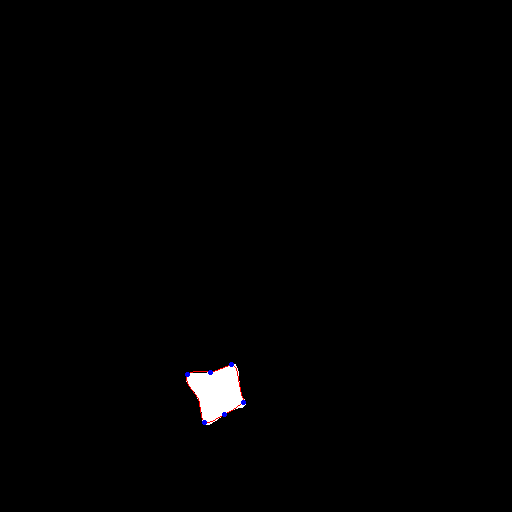

MR_1089_L_1.png


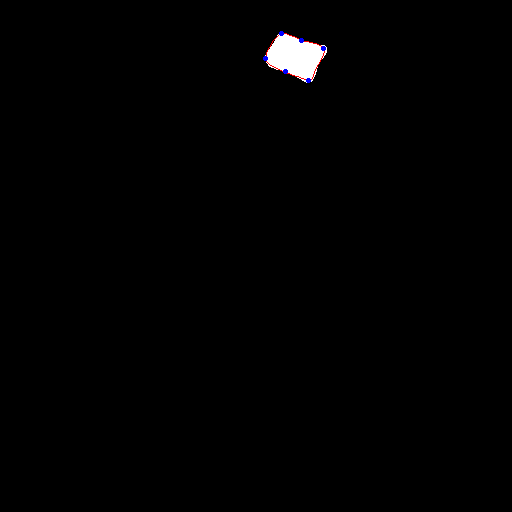

MR_0975_L_5.png


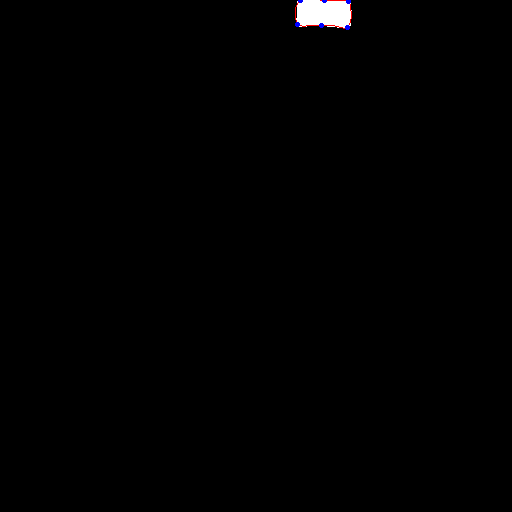

MR_1910_L_1.png


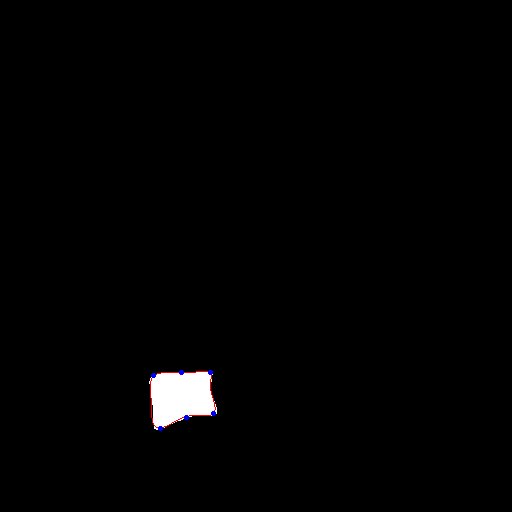

MR_1219_L_6.png
list index out of range
MR_1105_L_0.png


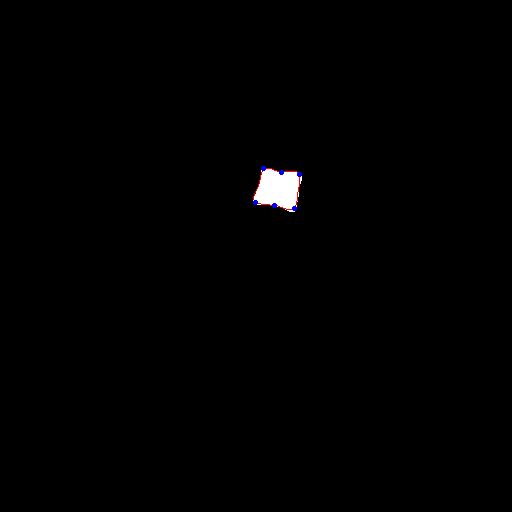

MR_0194_L_5.png


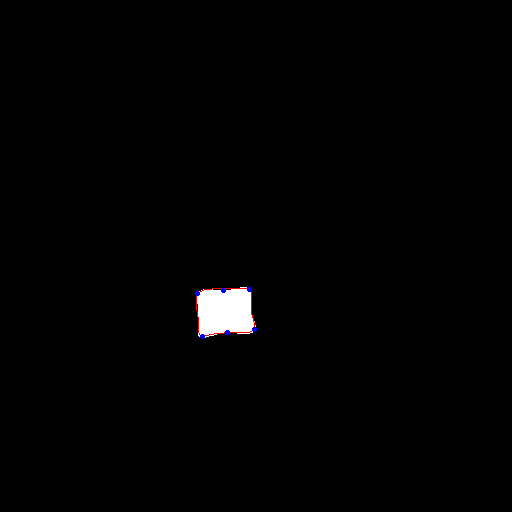

MR_1868_L_1.png


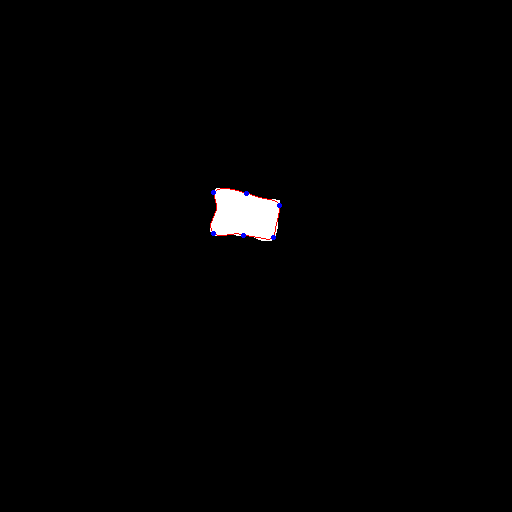

MR_1395_L_7.png


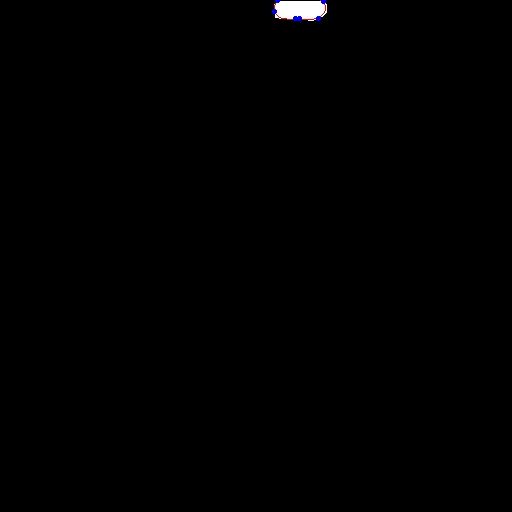

MR_0601_L_0.png


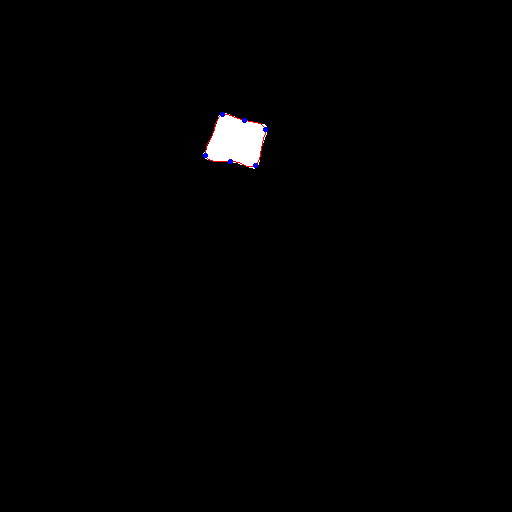

MR_0893_L_2.png


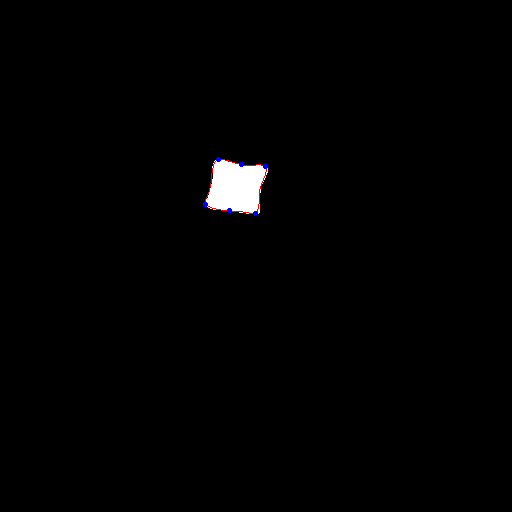

MR_2095_L_1.png


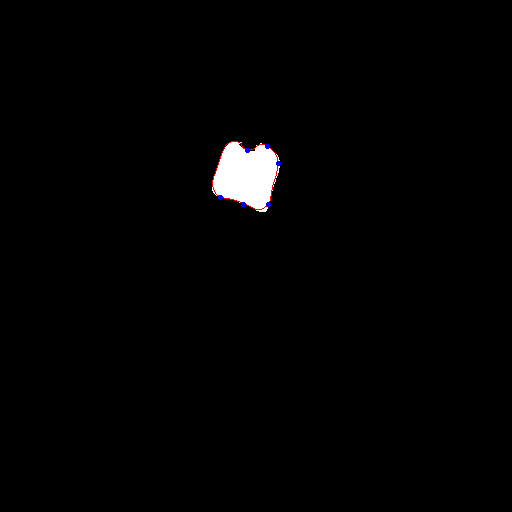

MR_1273_L_0.png


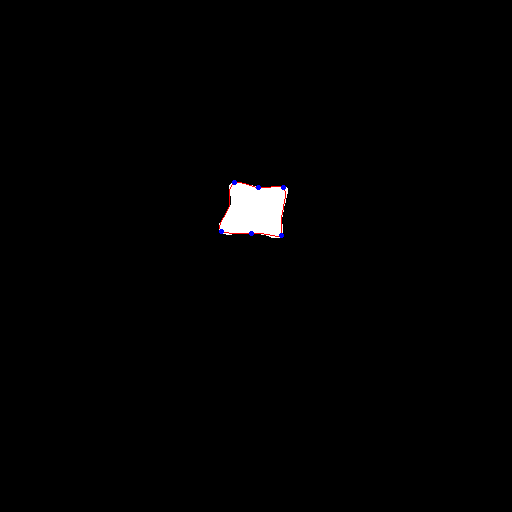

MR_0086_L_3.png


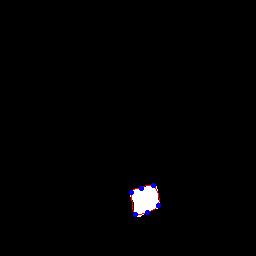

MR_1578_L_2.png


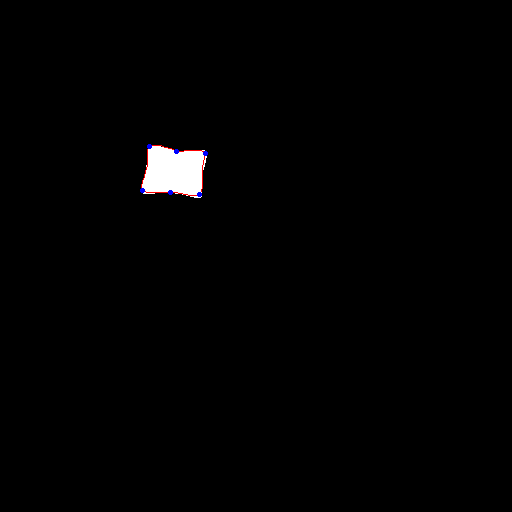

MR_1017_L_6.png


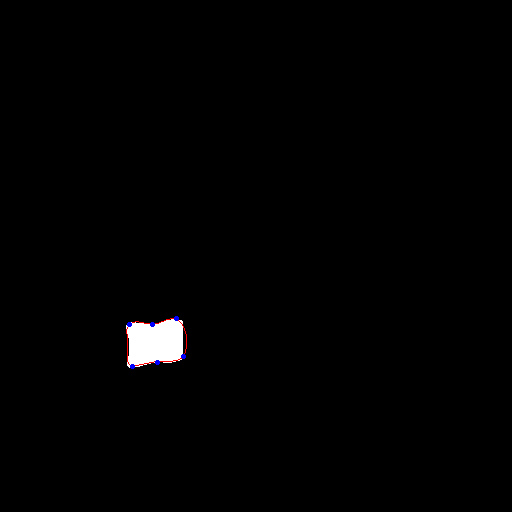

MR_2119_L_0.png


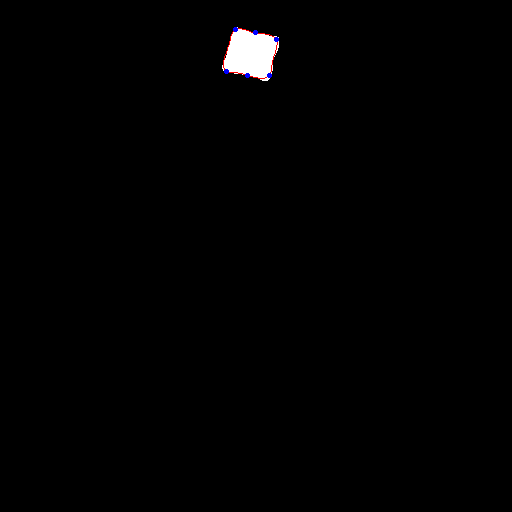

MR_2071_L_0.png


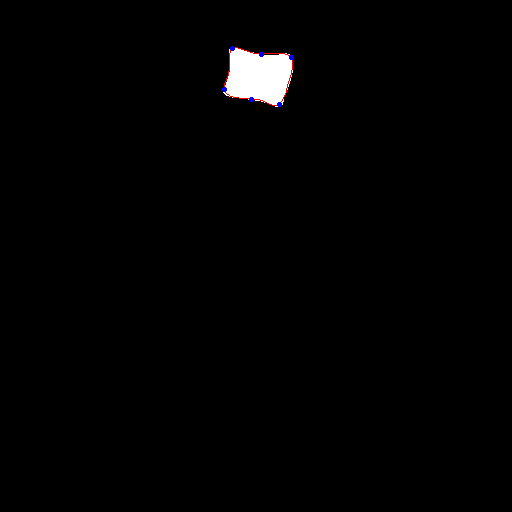

MR_1680_L_5.png


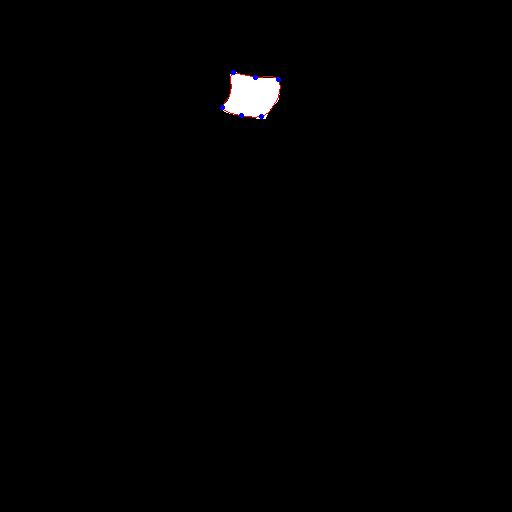

MR_2109_L_0.png
list index out of range
MR_1007_L_6.png


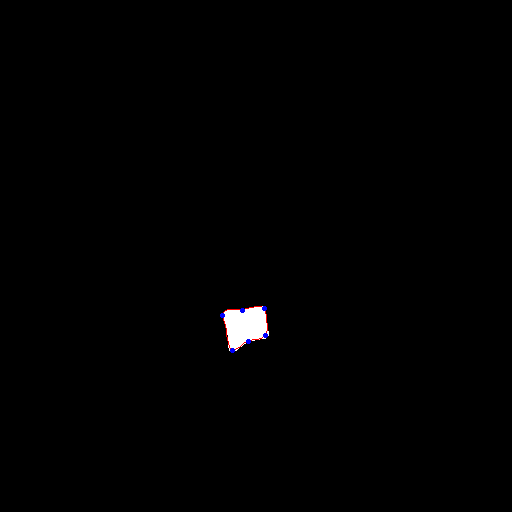

MR_1263_L_0.png


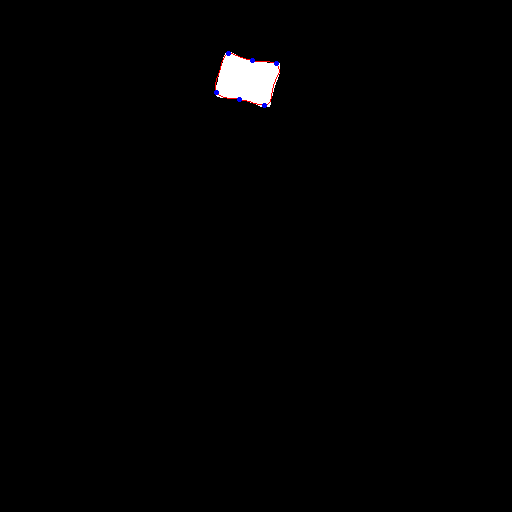

MR_1297_L_1.png


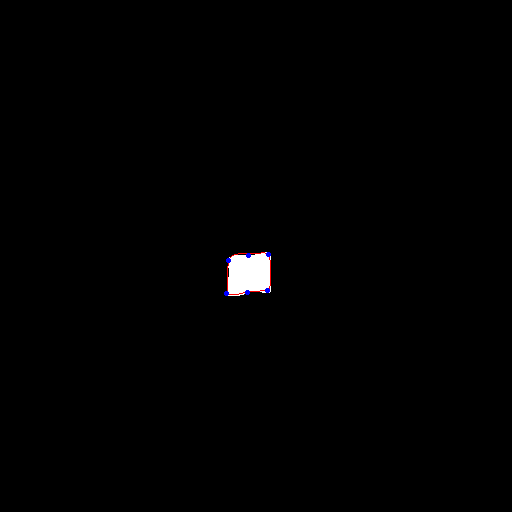

MR_0054_L_0.png


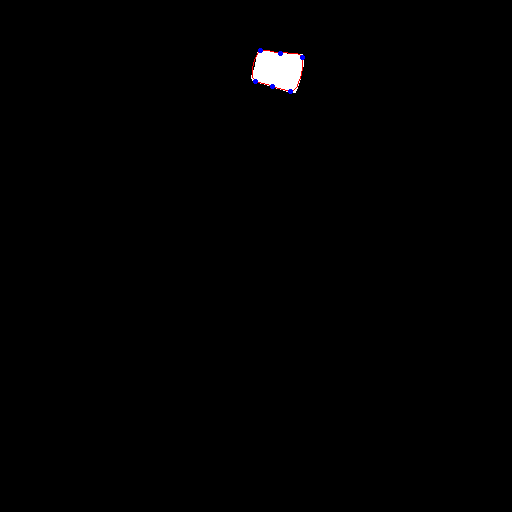

MR_1824_L_5.png


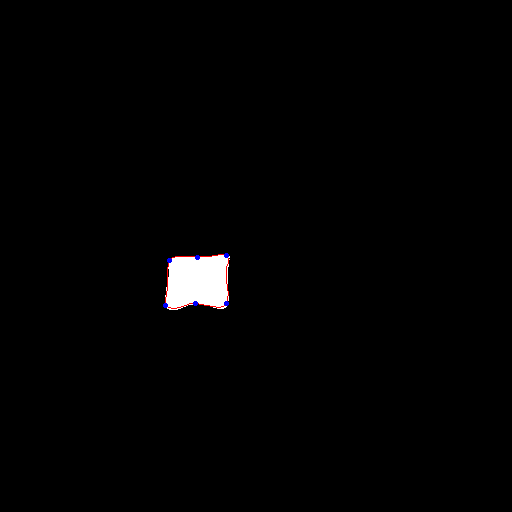

MR_0443_L_4.png


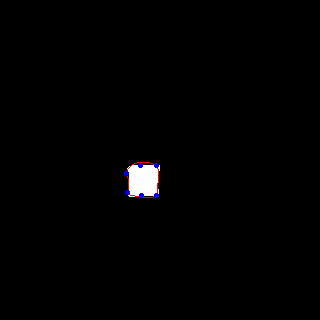

MR_1642_L_6.png


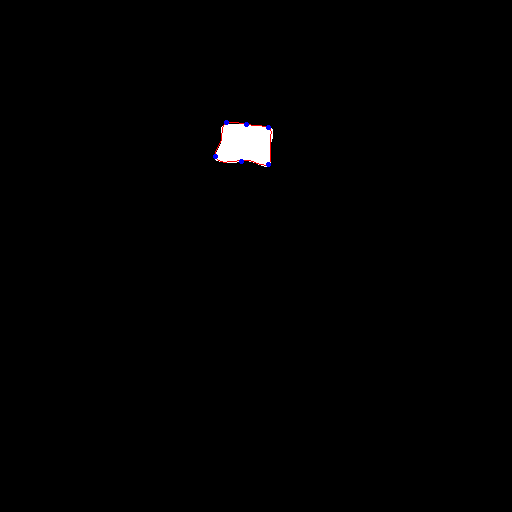

MR_0841_L_1.png


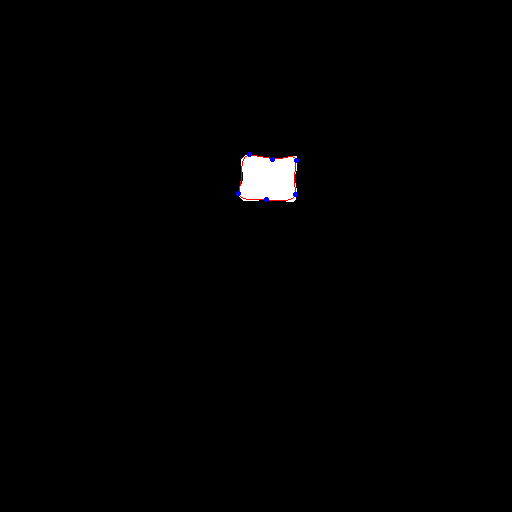

MR_2047_L_2.png
list index out of range
MR_1245_L_2.png


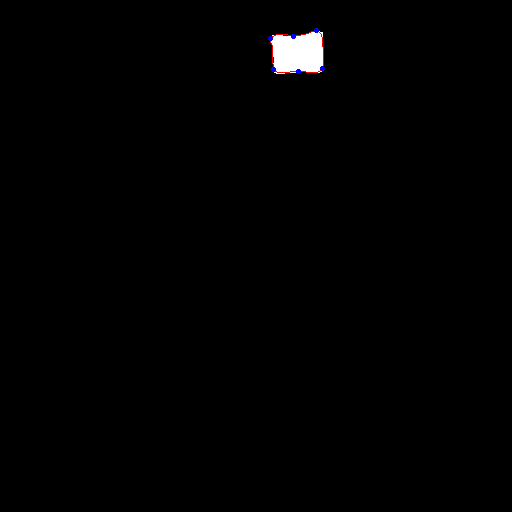

MR_1652_L_6.png


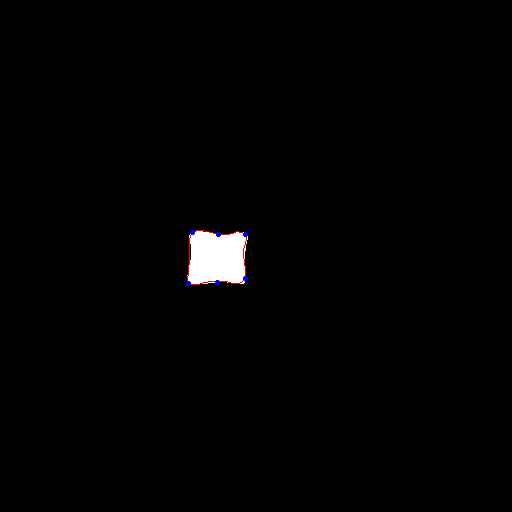

MR_0453_L_4.png
list index out of range
MR_2057_L_2.png


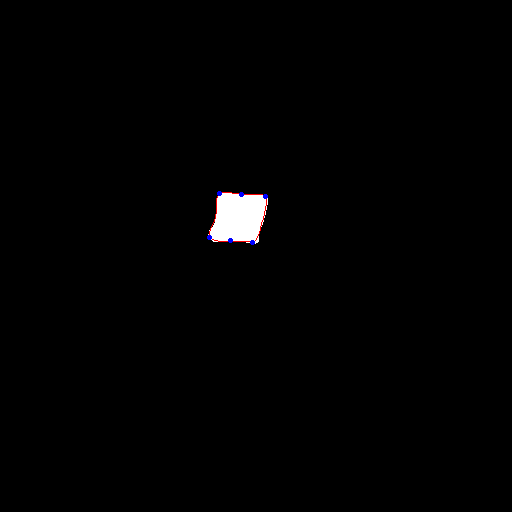

MR_0851_L_1.png


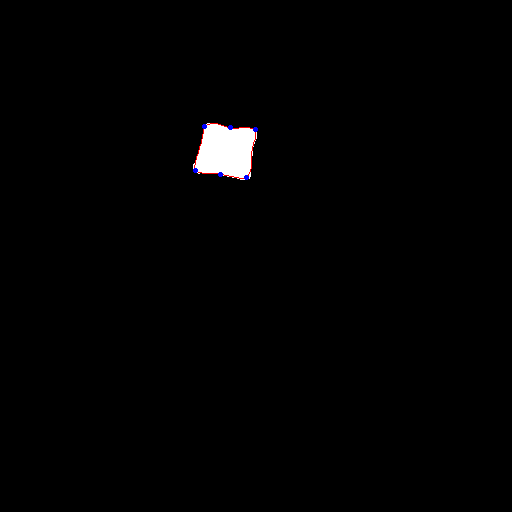

MR_1436_L_0.png


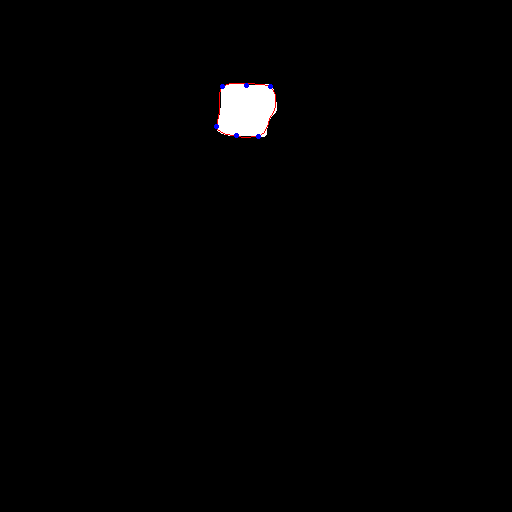

MR_0637_L_2.png


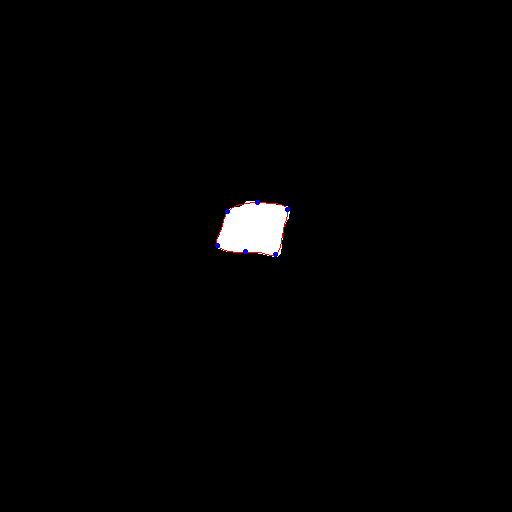

MR_2233_L_4.png


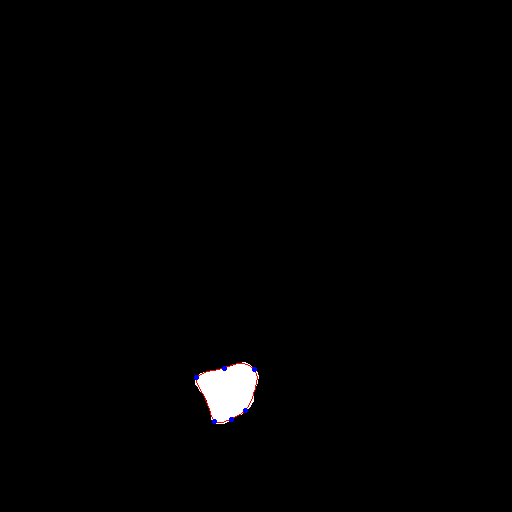

MR_0428_L_7.png


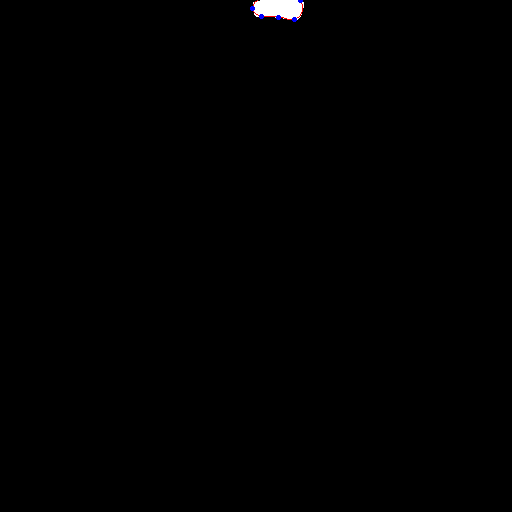

MR_1629_L_5.png


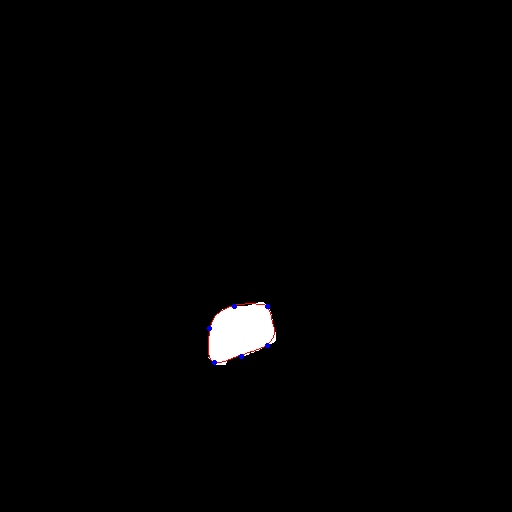

MR_0667_L_8.png


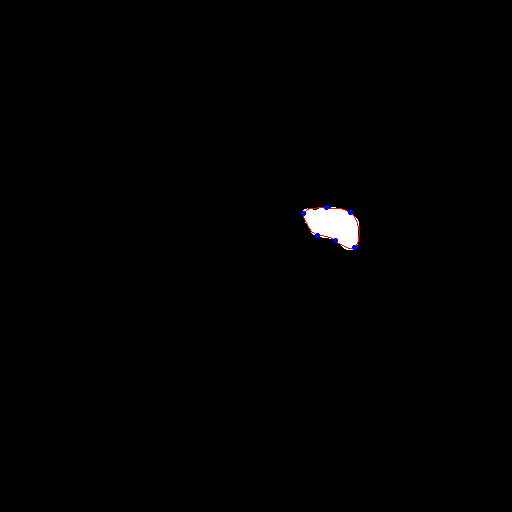

MR_2248_L_7.png
list index out of range
MR_0550_L_7.png


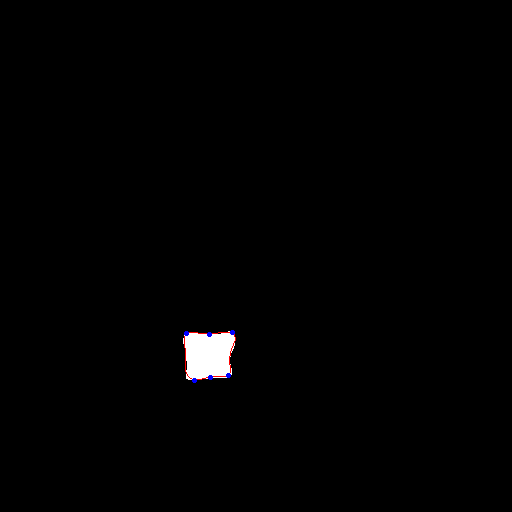

MR_2154_L_1.png


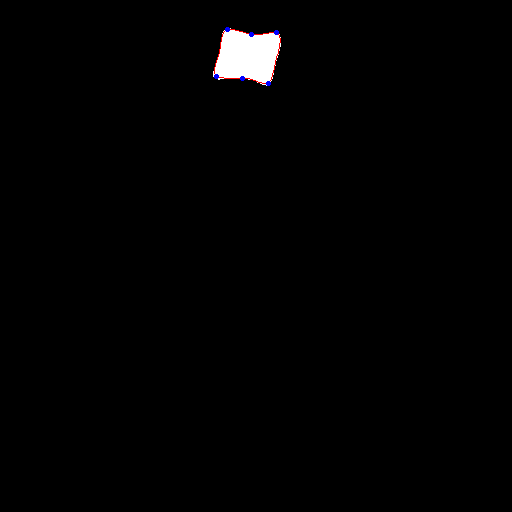

MR_0952_L_2.png


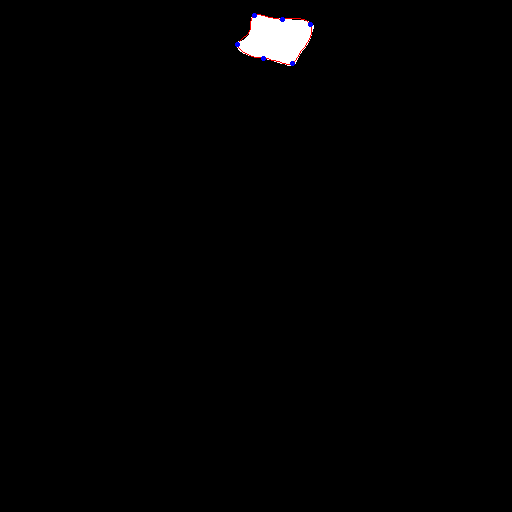

MR_1535_L_3.png


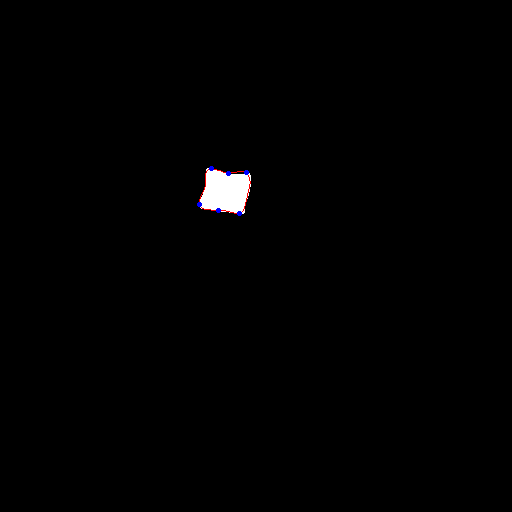

MR_1356_L_1.png


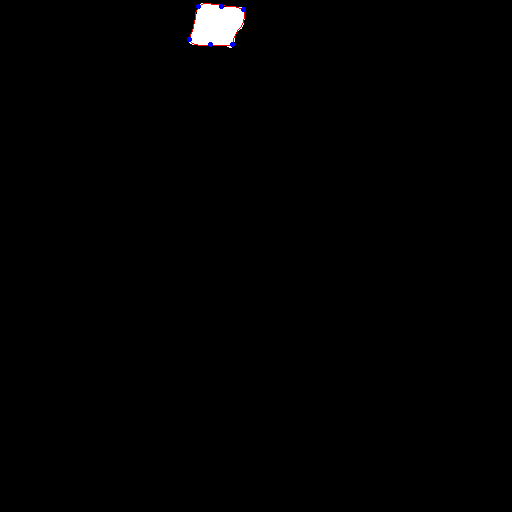

MR_1525_L_3.png


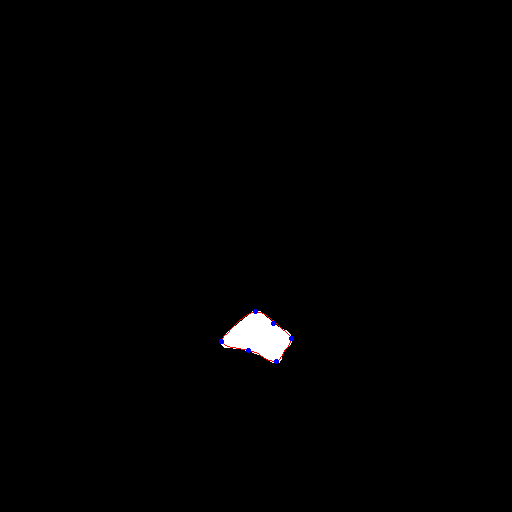

MR_1927_L_6.png


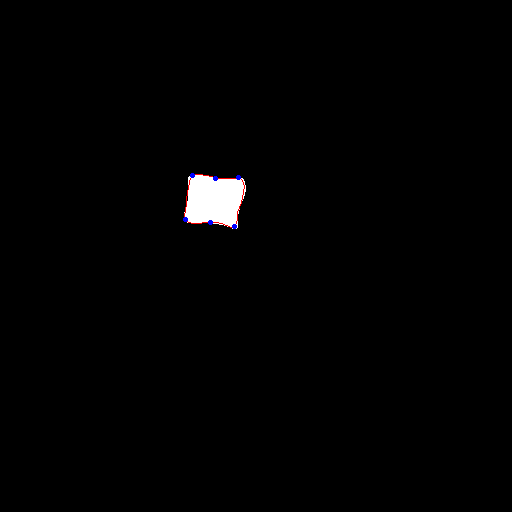

MR_2144_L_1.png


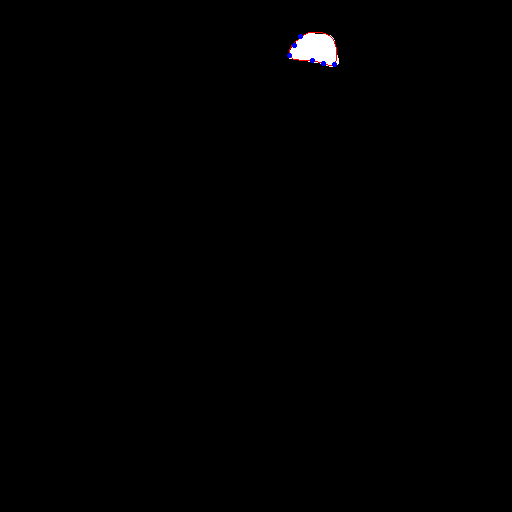

MR_2172_L_3.png


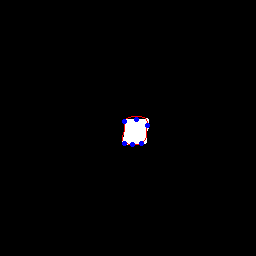

MR_1911_L_4.png


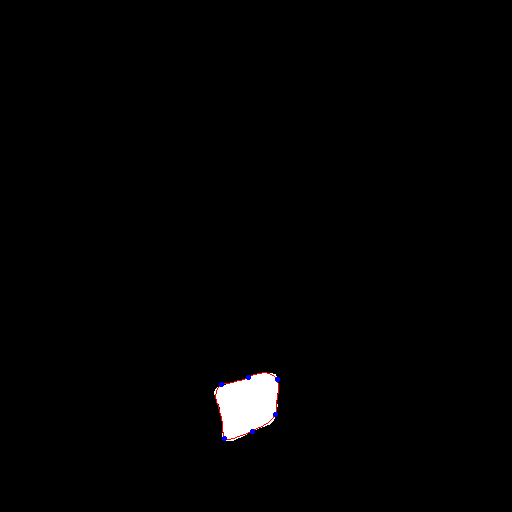

MR_1513_L_1.png


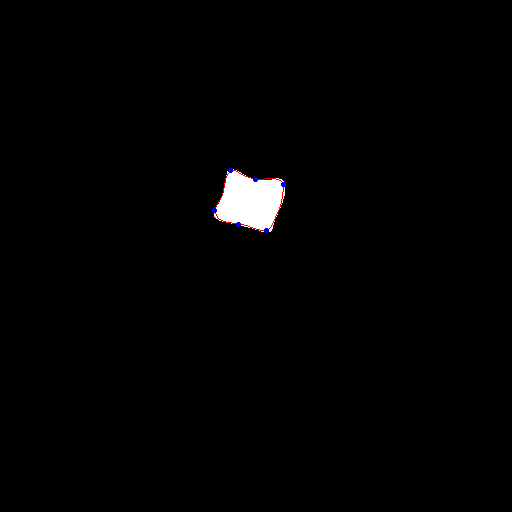

MR_1360_L_3.png


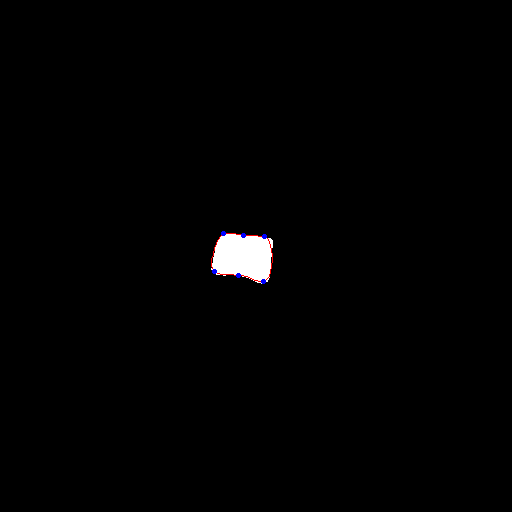

MR_1394_L_2.png
list index out of range
MR_1869_L_4.png


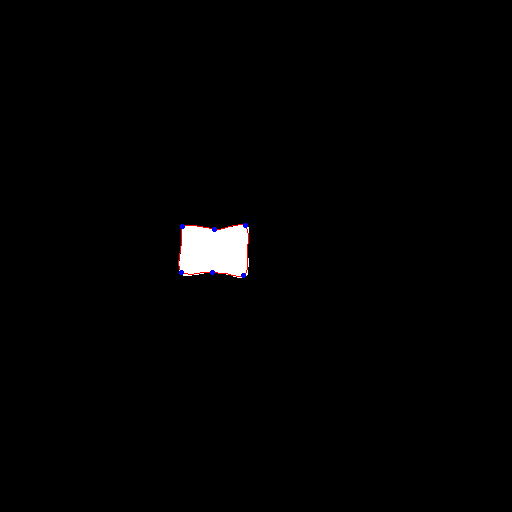

MR_0827_L_9.png


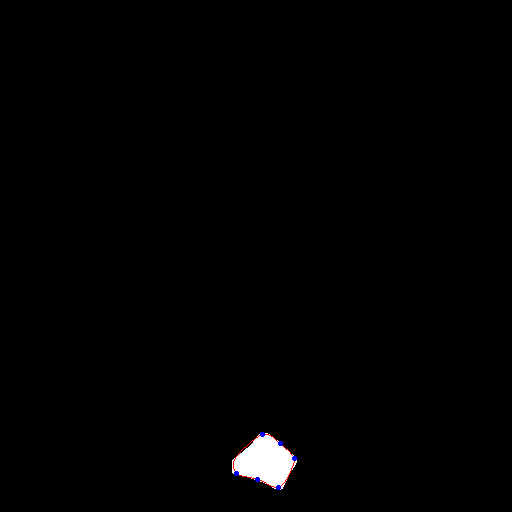

MR_0964_L_0.png


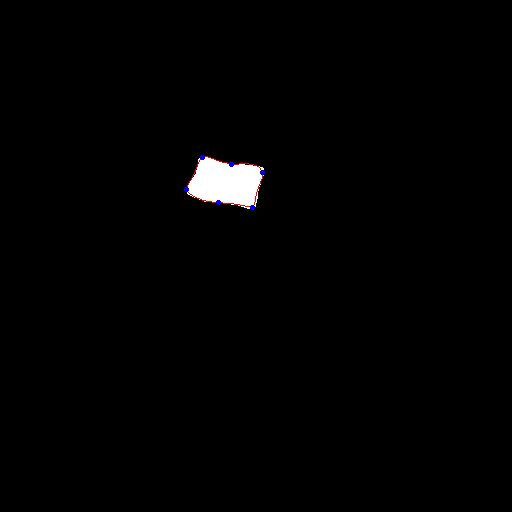

MR_0990_L_1.png


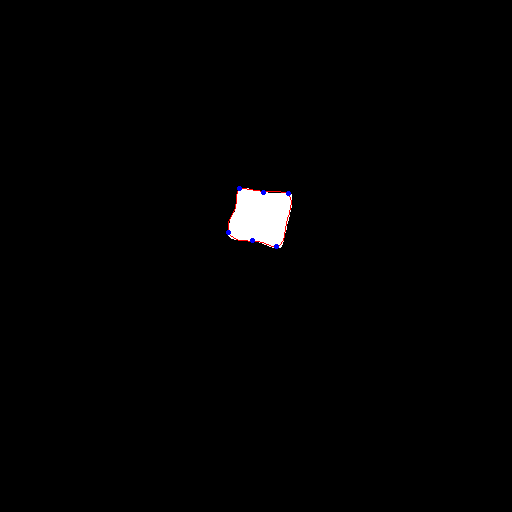

MR_2162_L_3.png


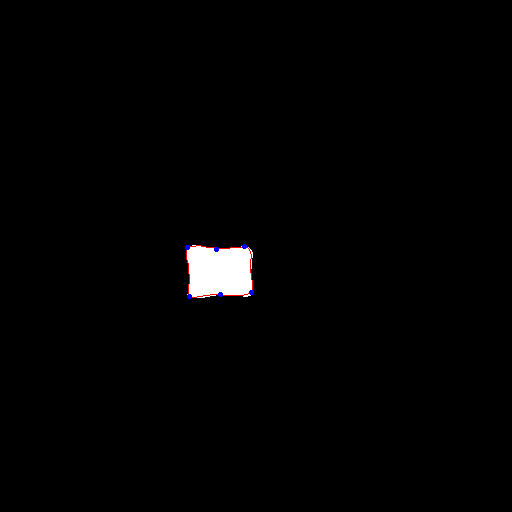

MR_2196_L_2.png


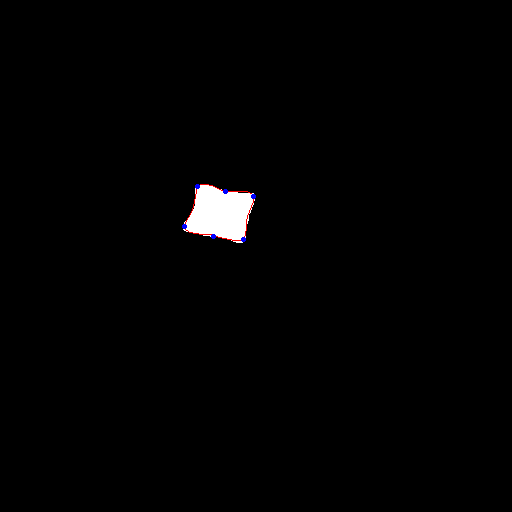

MR_0566_L_5.png


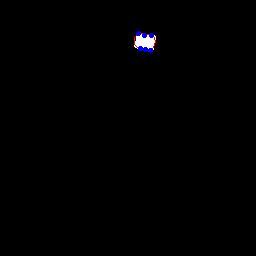

MR_1370_L_3.png


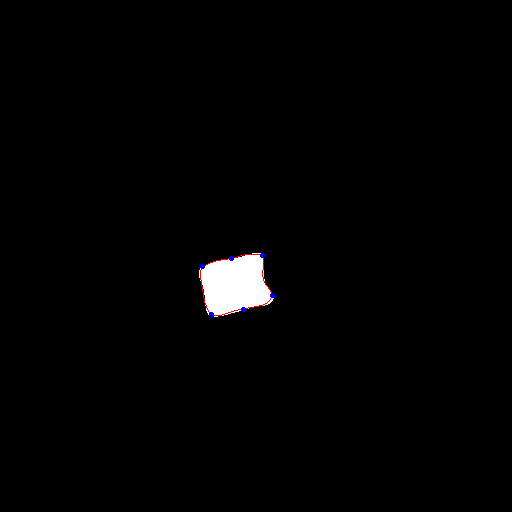

MR_1681_L_0.png


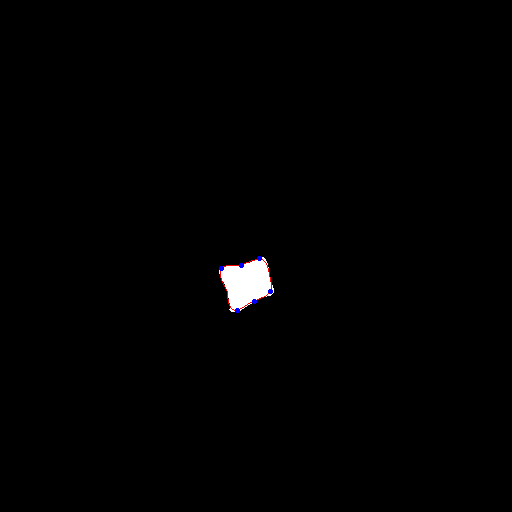

MR_0480_L_2.png


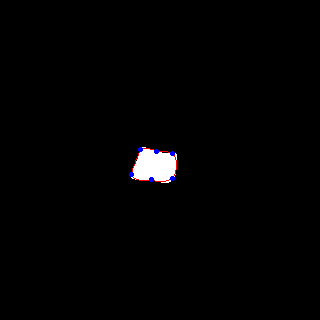

MR_2070_L_5.png


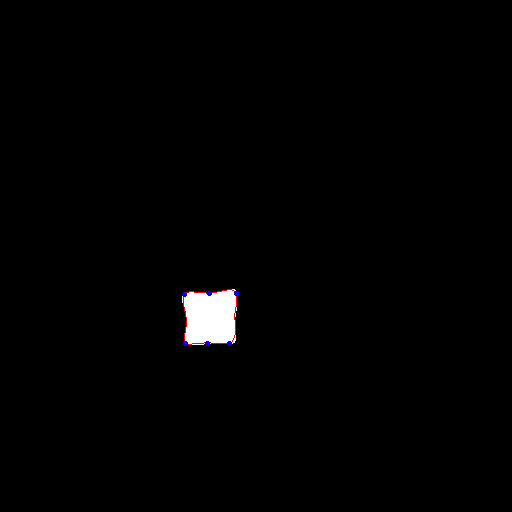

MR_2084_L_4.png


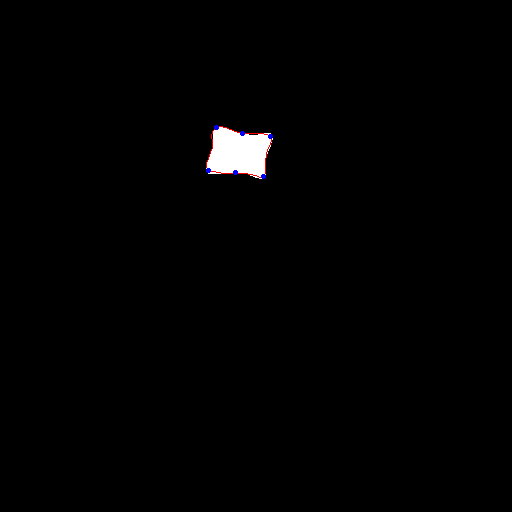

MR_0882_L_7.png


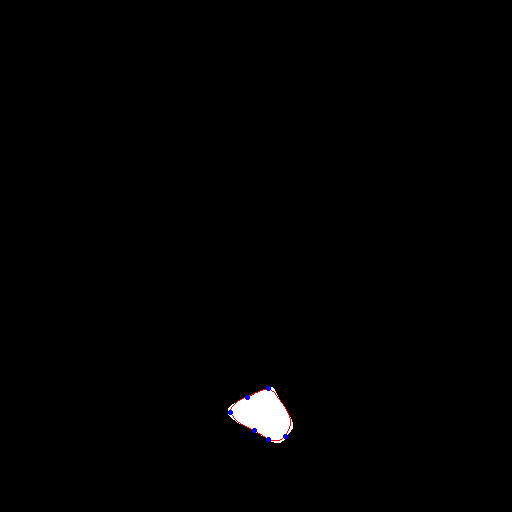

MR_0610_L_5.png


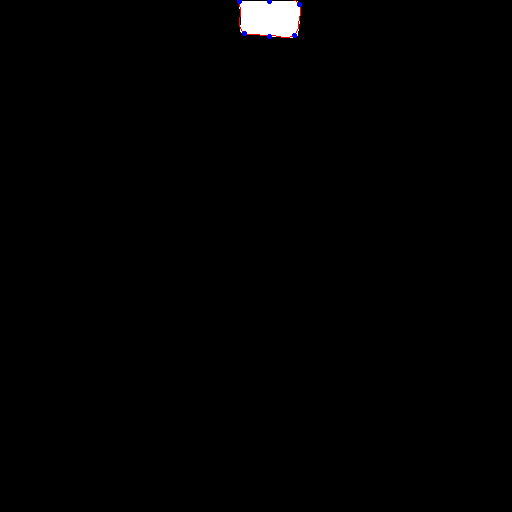

MR_2214_L_3.png


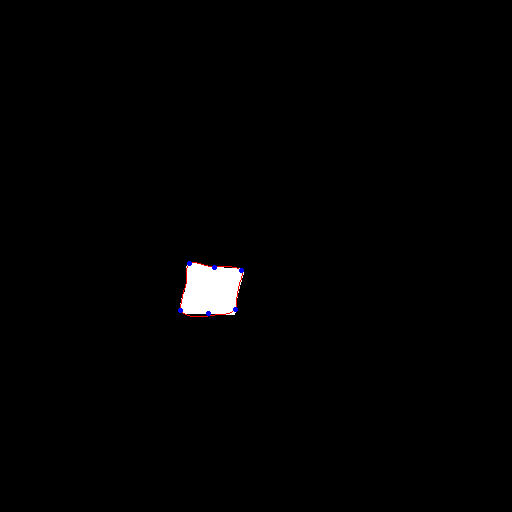

MR_1006_L_3.png


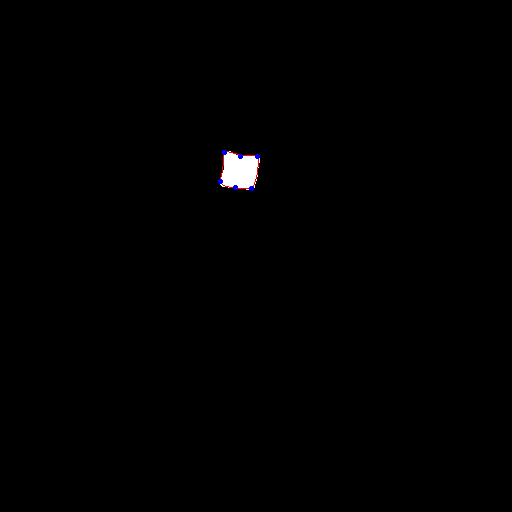

MR_0768_L_5.png


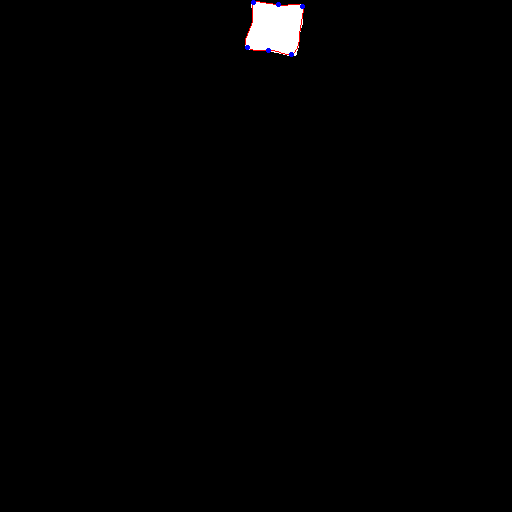

MR_0600_L_5.png


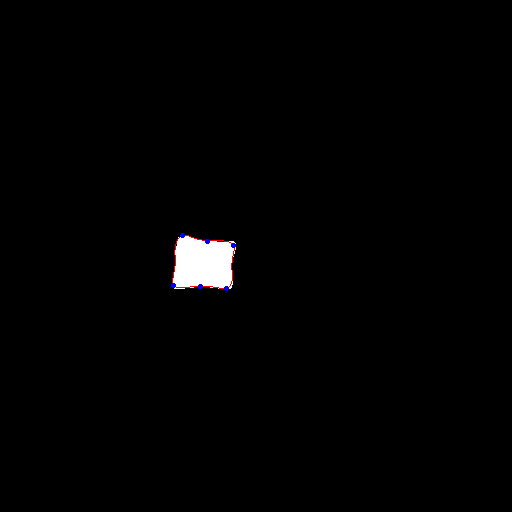

MR_2204_L_3.png


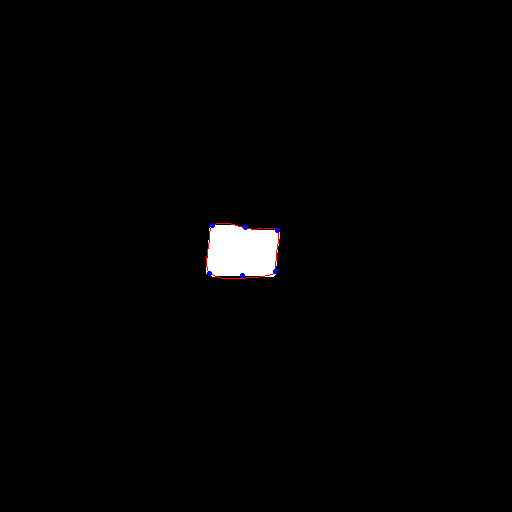

MR_1665_L_1.png


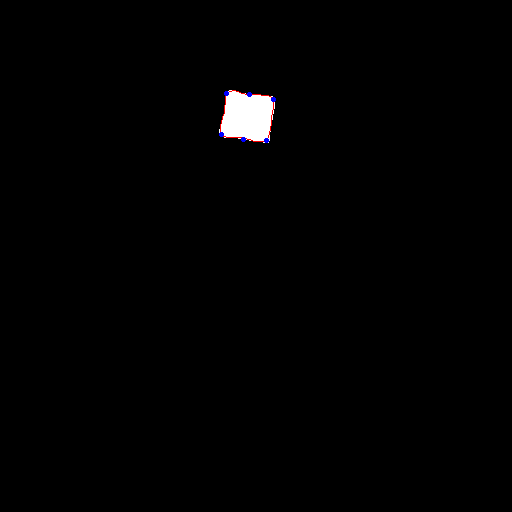

MR_2094_L_4.png


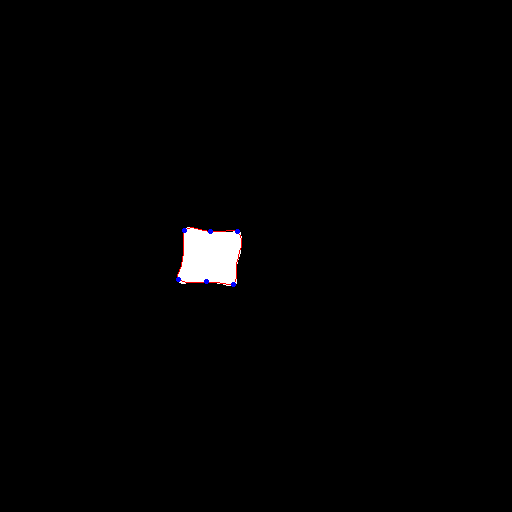

MR_0778_L_5.png


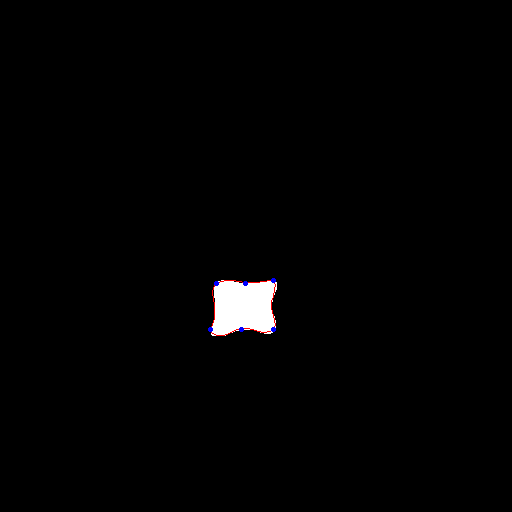

MR_2118_L_5.png


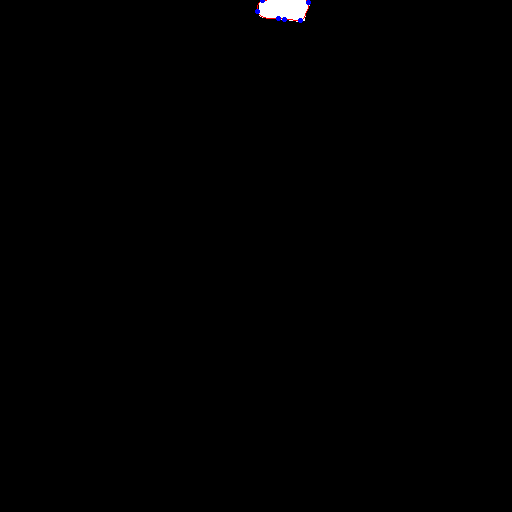

MR_0217_L_1.png


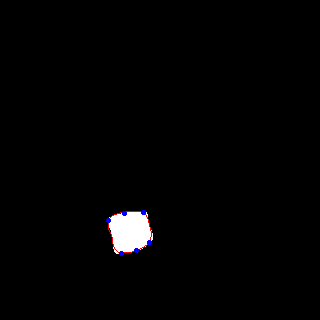

MR_0928_L_4.png


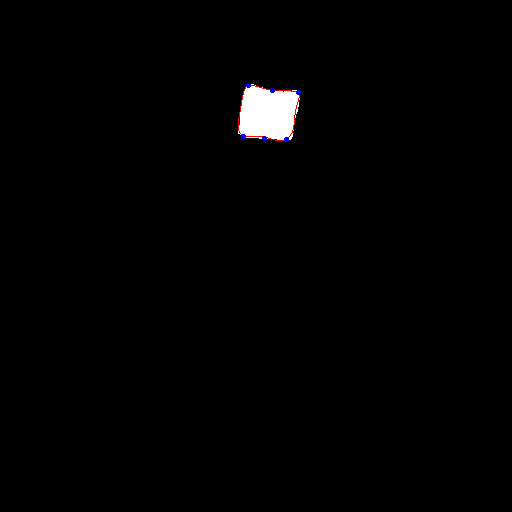

MR_2361_L_8.png


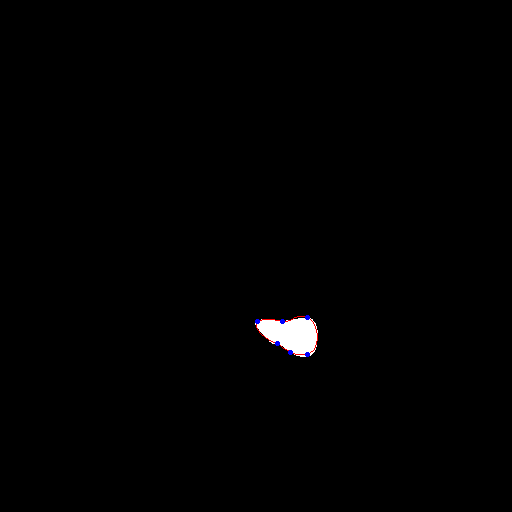

MR_1835_L_0.png


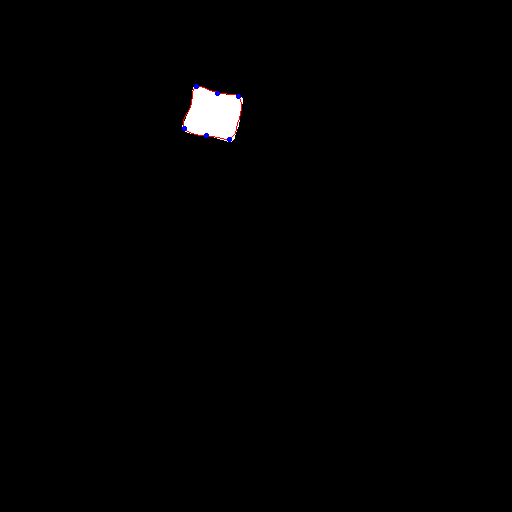

MR_1437_L_5.png


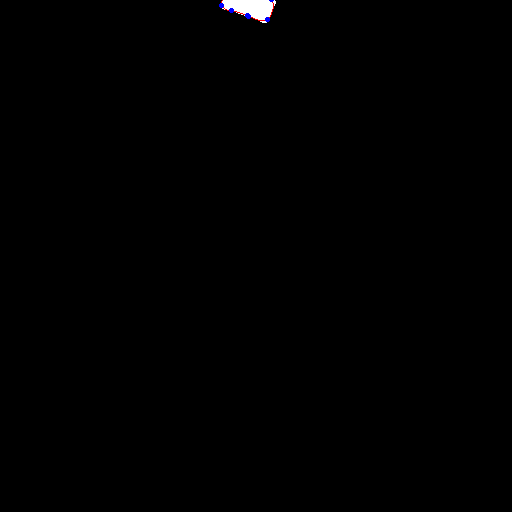

MR_0055_L_5.png


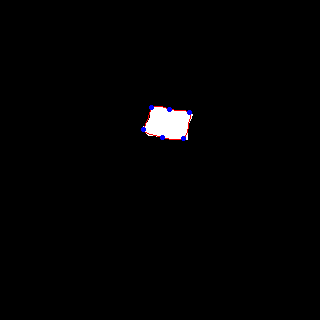

MR_2222_L_1.png


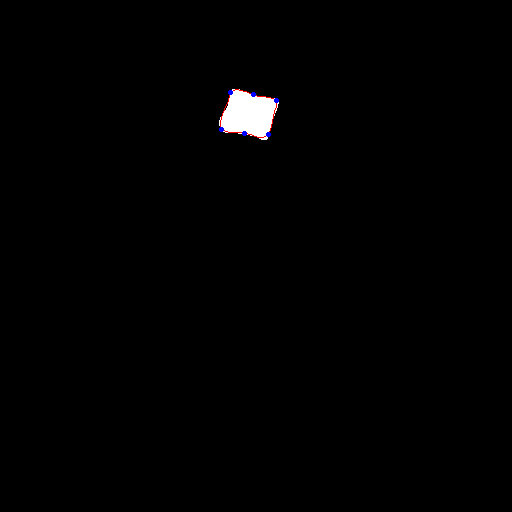

MR_1825_L_0.png


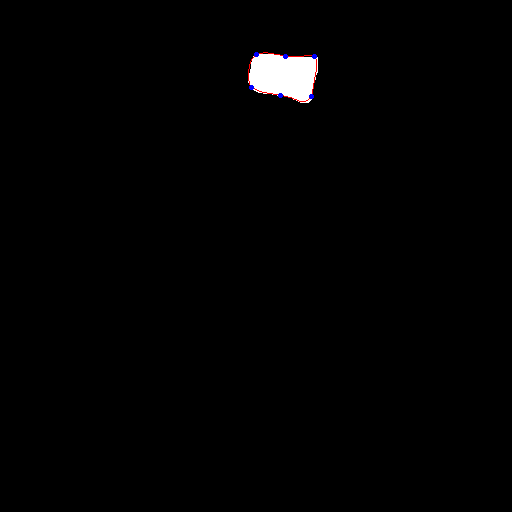

MR_0626_L_7.png


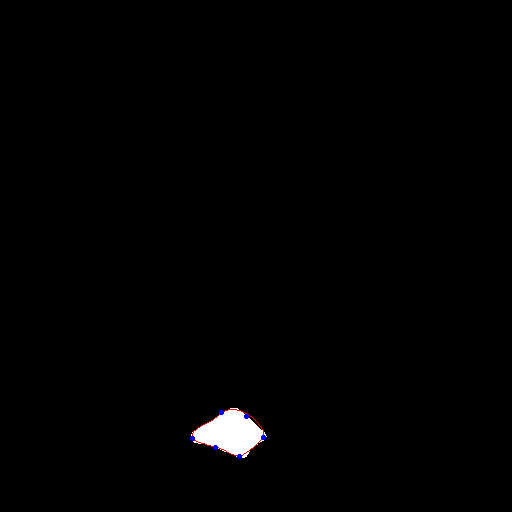

MR_1427_L_5.png
list index out of range
MR_1148_L_1.png


KeyboardInterrupt: 

In [270]:
for x in os.listdir('generated_masks'):
    print(x)
    try:
        makemask('generated_masks/{}'.format(x))
    except Exception as e:
        print(e)